# Notebook analysing the band model script

In [2]:
%autoreload 1
%matplotlib inline

In [3]:
%aimport band_model.utils.absorption
%aimport band_model.utils.utilities
%aimport band_model.qd_base_data
from band_model import qd_base_data as qbd
from band_model.utils import absorption as ab
from band_model.utils import utilities as utils
from band_model.utils.absorption import envolute_matrix_element as eme
from band_model.utils.absorption import avg_trn_elements as ate
from band_model.pso.pso import particle_swarm

from scipy import special
import scipy.constants as scc
import scipy.integrate as sci
import scipy.interpolate as scin
import scipy.optimize as sco

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import math
import numpy as np
import pandas as pd

import h5py
import importlib

from itertools import product
from pyevtk.hl import gridToVTK

import warnings
warnings.filterwarnings('ignore')

import time
import timeit
import logging
import os
from functools import partial
import multiprocessing
from multiprocessing import Pool

In [4]:
logging.basicConfig(filename="output.log",
                    format='%(asctime)s - [%(levelname)s]:%(name)s[%(funcName)s]: %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("band_model").setLevel(logging.DEBUG)

## Calculating the normalized envolutes

In [3]:
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB1")

/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:67: RuntimeWarning: divide by zero encountered in true_divide
  f_E = 1.0 / np.tan(arg_cot) + np.sqrt(-(m2 / m1) * (energy /
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: divide by zero encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:74: RuntimeWarning: divide by zero encountered in true_divide
  h_term = np.sqrt(-(m2 / m1) * (energy / (energy + V0))) * np.real(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: invalid value encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:192: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(
/home/cemop/Documents/Python/Miguel/PhD/b

In [4]:
qd_wavefunction.e_levels

l0        l1        l2        l3
0 -1.520441 -1.131609 -0.653472 -0.105484
1 -0.455799       NaN       NaN       NaN

### Check wavefunction from the normal calculation

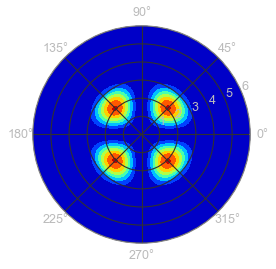

In [5]:
#angular momentum value
l = 2
#index of the energy level
k = 0
#z angular momentum
m = 1

#Calculate the radial part of the wavefunction
r,f_r = qd_wavefunction.norm_radial_wavefunction(l,k)
phi = np.linspace(0,2*np.pi,100)
#Angular part of the wavefunction
y_lm = np.absolute(special.sph_harm(m,l,0,phi))**2
#Combine both radial and angular parts
psi = np.array([y_lm*f_r_i for f_r_i in f_r])

#actual plotting
ax = plt.subplot(111, polar=True)
ctf = ax.contourf(phi,r,psi, cmap=cm.jet)

### Check for the 3D Cartesian plot Results

Normalization
0.9967307027571376


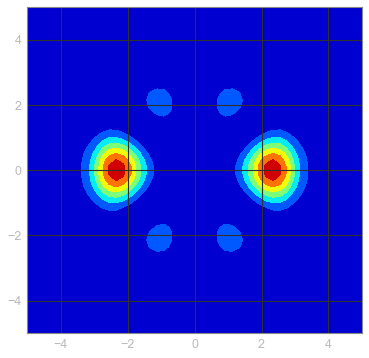

In [6]:
# l/m/n values
l = 3
m = 0
n = 0
n_points = 50
x = np.linspace(-5, 5, n_points)
y = np.linspace(-5, 5, n_points)
z = np.linspace(-5, 5, n_points)
XX, YY, ZZ, norm_wavefunction = qd_wavefunction.norm_wavefunction(x, y, z, l, m, n)
print("Normalization")
print(np.sum(np.abs(norm_wavefunction)**2)*(x[1]-x[0])**3)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(XX[:, :, int(n_points/2)], ZZ[int(n_points/2)].T, np.abs(norm_wavefunction[:, int(n_points/2), :])**2, cmap=cm.jet)
plt.show()
# Export Results
exp_data = {"X": XX.flatten(), "Y": YY.flatten(), "Z": ZZ.flatten(), "env": (np.abs(norm_wavefunction)**2).flatten()}
exp_df = pd.DataFrame(exp_data)
exp_df.to_csv(f"wavefunction_{l}_{m}_{n}.csv", index=False)

### Calculate envolute

In [3]:
XX_env, YY_env, ZZ_env, envolute, t_matrix = qd_wavefunction.norm_envolute(10, 0.2, "L6mb", 0, 0, 1, 2.5, (1e-25, 1e-25))

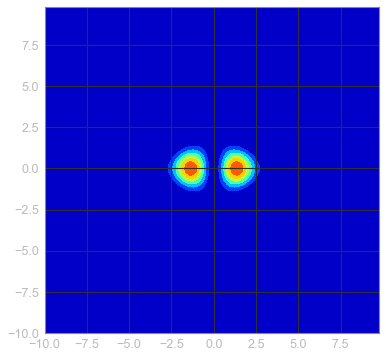

In [4]:
# l/m/n values
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(XX_env[:, :, 50], ZZ_env[50].T, np.abs(envolute[:, 50])**2, cmap=cm.jet)
plt.show()

### Check envolute normalization for all bands (CB1, CB2, VB1, VB2)

In [6]:
# Setup parameters
sim_size = 10
lat_size = 0.2
l = 2
m = 1
n = 0
Eg = 2.2
P = (1e-25, 1e-25)
# Guarantee normalization for the CB
qd_wavefunction_cb = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_cb = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_cb:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("CB1 Normalization\n", norm_factor)

# Normalization for Light Holes
norm_factor = 0
qd_wavefunction_lh = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_lh = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_lh:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("CB2 Normalization\n", norm_factor)

# Normalization for Heavy Holes
norm_factor = 0
qd_wavefunction_hh = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_hh = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_hh:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("VB1 Normalization\n", norm_factor)

norm_factor = 0
qd_wavefunction_so = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_so = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_so:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("VB2 Normalization\n", norm_factor)

CB1 Normalization
 0.9999977420365855
CB2 Normalization
 0.9999977420365855
VB1 Normalization
 0.9999977420365855
VB2 Normalization
 0.9999977420365855


## Visualizing envolutes

In [7]:
# Setup parameters
sim_size = 10
lat_size = 0.15
l = 2
m = 0
n = 0
Eg = 1.42
P = (1e-25, 1e-25)
center = int(sim_size/lat_size/2)
print(center)

33


For the conduction band 1

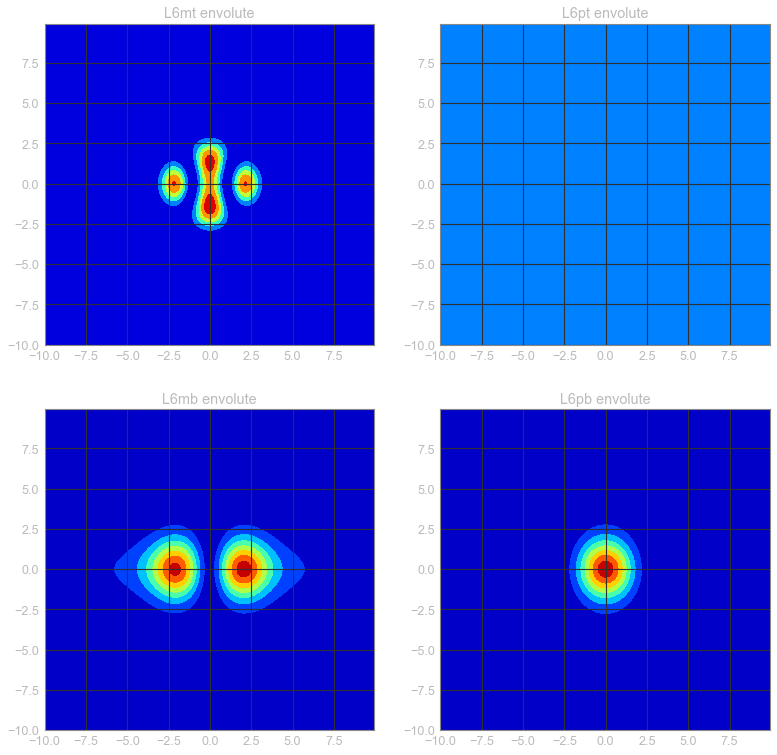

In [8]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

For the CB 2

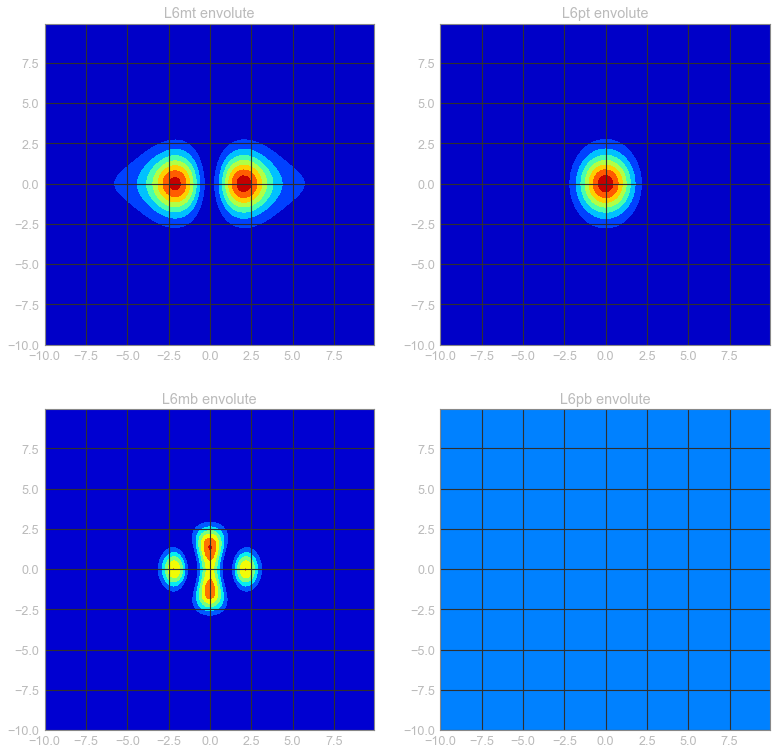

In [9]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

For the VB1 band

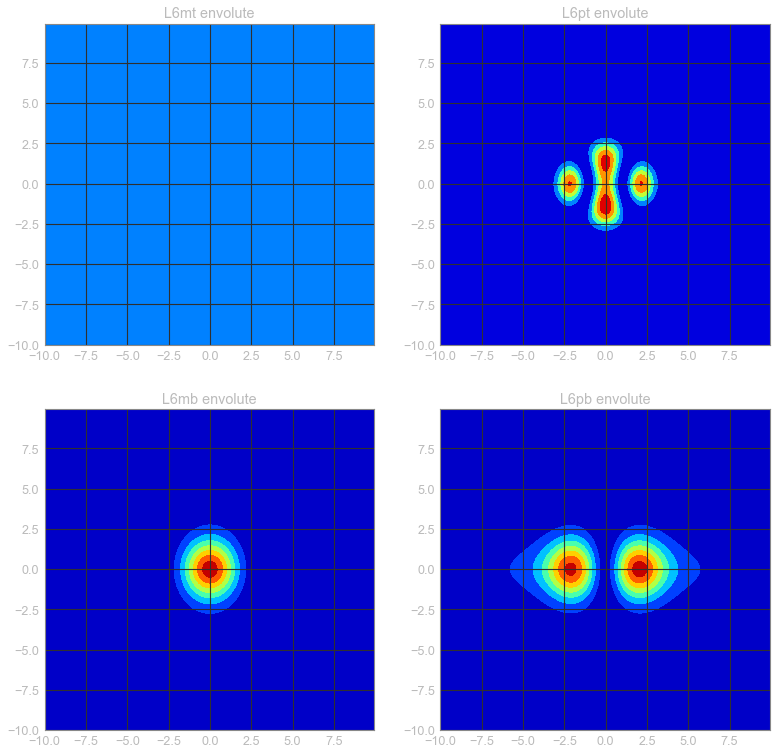

In [10]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

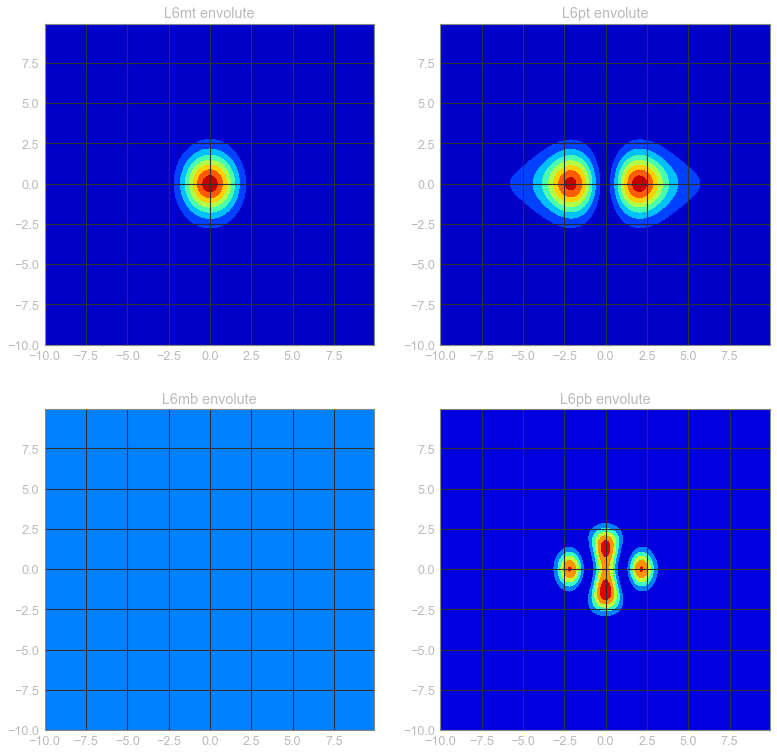

In [11]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

## Visualization testing

In [ ]:
## sim_size = 10
lat_size = 0.2
l = 0
m = 0
n = 0
Eg = 0.4
P = (1e-25, 1e-25)
env = "L6pb"
band = "VB1"
center = int(sim_size/lat_size/2)
print(center)
qd_wavefunction = qbd.qd_results(3, 1, 0.08, 0.08, band)
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, env, l, m, n, Eg, P)
fig, ax = plt.subplots(figsize=(13, 13))
ax.contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[10])**2, cmap=cm.jet)
ax.set_title("L6mt envolute")
plt.show()
# exp_data = {"X": XX_env_S.flatten(), "Y": YY_env_S.flatten(), "Z": ZZ_env_S.flatten(), "env": (np.abs(envolute_S)**2).flatten()}
# exp_df = pd.DataFrame(exp_data)
# exp_df.to_csv(f"{env}_envolute_{l}_{m}_{n}_{band}.csv", index=False)
x = np.arange(-sim_size, sim_size, lat_size)
gridToVTK(f"Article_2_Results/band_{band}_envolute_{env}_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_S)**2})

# Calculation of the Absorption Coefficients

### Determine the matrix elements

The dipole matrix ruling the photon-electron interaction is given by

\begin{equation}
\langle \Theta | \epsilon \cdot r | \Theta' \rangle \approx \langle \Psi_S | \epsilon \cdot r | \Psi_S' \rangle + \langle \Psi_X | \epsilon \cdot r | \Psi_X' \rangle + \langle \Psi_Y | \epsilon \cdot r | \Psi_Y' \rangle + \langle \Psi_Z | \epsilon \cdot r | \Psi_Z' \rangle
\end{equation}

This equation uses the integral factorization rule and the orthonormal properties of GBFs.

From here it is possible to define the polarization via its Euler angles ($\theta, \phi$)
\begin{equation}
\langle\Theta |\epsilon\cdot r|\Theta'\rangle = cos(\phi)sin(\theta)\langle \Theta|x|\Theta'\rangle + sin(\phi)sin(\theta)\langle\Theta|y|\Theta'\rangle + cos(\theta)\langle\Theta|z|\Theta'\rangle
\end{equation}

For this first case I will consider vertical unpolarized radiation such that the above equation is $\phi$ integrated (between [0, 2$\pi$]) and $\theta$ is defined as 2$\pi$, resulting in

\begin{equation}
\langle\Theta |\epsilon\cdot r|\Theta'\rangle = ( \langle\Theta|x|\Theta'\rangle + \langle\Theta|y|\Theta'\rangle ) / 2
\end{equation}

Code implemented in the band_model module

```python
def envolute_matrix_element(qd_i, e_i, qd_f, e_f, sim_properties):
    """
    Determines the envolute matrix elements between qd_1 and qd_2
    """
    # assert qd_i.band != qd_f.band, "Bands should be different"
    envolutes = ["L6mt", "L6mb", "L6pt", "L6pb"]
    sim_size, lat_size, Eg, P = sim_properties
    ni, li = e_i
    nf, lf = e_f
    Mx_array = []
    My_array = []
    Mz_array = []
    # Define the iterator from the input values
    if li != 0 and lf != 0:
        iterator = product(range(-li, li + 1), range(-lf, lf + 1))
    elif li == 0 and lf != 0:
        iterator = product([0], range(-lf, lf + 1))
    elif li != 0 and lf == 0:
        iterator = product(range(-li, li + 1), [0])
    else:
        iterator = zip([0], [0])
    # Loop through all possible m value combinations
    for m_i_i, m_f_i in iterator:
        # print("Calculating....")
        # print(m_i_i, m_f_i)
        # Calculate the matrix element for transition between 2 elements (for a specific m value)
        # This element is determined from the sum of the elements from the 4 envolutes
        Mx, My, Mz = 0, 0, 0
        for envolute in envolutes:
            XX, YY, ZZ, env_i, _ = qd_i.norm_envolute(sim_size, lat_size, envolute, li, m_i_i, ni, Eg, P)
            _, _, _, env_f, _ = qd_f.norm_envolute(sim_size, lat_size, envolute, lf, m_f_i, nf, Eg, P)
            # Function integration
            Mx += np.sum(env_i * XX * np.conjugate(env_f)) * lat_size ** 3
            My += np.sum(env_i * YY * np.conjugate(env_f)) * lat_size ** 3
            Mz += np.sum(env_i * ZZ * np.conjugate(env_f)) * lat_size ** 3
        # Determine the matrix element from n1, l1, m1 to n2, l2, m2
        Mx_array.append(np.abs(Mx))
        My_array.append(np.abs(My))
        Mz_array.append(np.abs(Mz))
    # Put all Mx/My/Mz values under 1e-7 to 0
    Mx_array = np.array(Mx_array)
    My_array = np.array(My_array)
    Mz_array = np.array(Mz_array)
    # print("Mx Values", Mx_array, "My_values", My_array, "Mz Values", Mz_array, sep="\n")
    # Obtain the mean of the non-zero values
    # Create a mask for the weigths
    mx_zeros = Mx_array > 10e-5
    my_zeros = My_array > 10e-5
    mz_zeros = Mz_array > 10e-5
    # Check if the mask does not sum to 0 and determine the average
    if True in mx_zeros:
        Mx_final = np.average(Mx_array, weights=mx_zeros)
    else:
        Mx_final = 0
    if True in my_zeros:
        My_final = np.average(My_array, weights=my_zeros)
    else:
        My_final = 0
    if True in mz_zeros:
        Mz_final = np.average(Mz_array, weights=mz_zeros)
    else:
        Mz_final = 0
    return Mx_final, My_final, Mz_final


p = 1e-25
qd_test_1 = qbd.qd_results(5, 1.1, 0.08, 0.08, "CB1")
qd_test_2 = qbd.qd_results(5, 0.6, 0.08, 0.08, "VB1")
envolute_matrix_element(qd_test_2, (0, 0), qd_test_1, (0, 2), (8, 0.2, 2.5, (p, p)))
```

Testing the magnitude of severall transitions

In [ ]:
sizes = np.linspace(1, 5, 5)
sim_properties = (10, 0.3, 2.3, (1e-25, 1e-25))
levels = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3)]
for size in sizes:
    print("Calculation for size: ", size, "\n")
    qd1 = qbd.qd_results(size, 1.2, 0.08, 0.08, "VB1")
    if qd1.e_levels.empty:
        continue
    print("QD1 Energy Levels:")
    print(qd1.e_levels)
    qd2 = qbd.qd_results(size, 0.7, 0.1, 0.1, "CB1")
    if qd2.e_levels.empty:
        continue
    print("QD2 Energy Levels:")
    print(qd2.e_levels)
    print("\n")
    for state_lh, state_cb in product(levels, levels):
        try:
            Mx, My, Mz = ab.envolute_matrix_element(qd1, state_lh, qd2, state_cb, sim_properties)
            print("Calculating from:", state_lh, state_cb)
            print("Mx: ", Mx, "My: ", My, "Mz: ", Mz)
        except IndexError:
            continue

### Cicle through all present energy levels

Code implemented in the band_model module

```python
def interband_transition_elements(qd1, qd2, sim_properties):
    """
    Calculates all the interband transition elements between qd1 and qd2
    Returns:
        transition_list (list): List with the transition elements (Transition energy, (Mx, My, Mz))
    """
    # Create a list with all the present (n, l) level combinations for each qd
    qd1_e_values = qd1.e_levels.values
    qd1_levels = list(product(range(qd1_e_values.shape[0]), range(qd1_e_values.shape[1])))
    qd2_e_values = qd2.e_levels.values
    qd2_levels = list(product(range(qd2_e_values.shape[0]), range(qd2_e_values.shape[1])))
    transition_list = []
    # Cicle through all the (n, l) combination of both qds, coupled with each particular energy level
    for ((qd1_level, qd2_level), (qd1_energy, qd2_energy)) in zip(
        product(qd1_levels, qd2_levels), 
        product(qd1_e_values.flatten(), qd2_e_values.flatten())):
        # Ignore all combinations where either the energy of qd1 or qd2 is nan
        if math.isnan(qd1_energy) or math.isnan(qd2_energy):
            continue
        transition_list.append((sim_properties[2] + qd1_energy + qd2_energy,
                                eme(qd1, qd1_level, qd2, qd2_level, sim_properties)))
    return transition_list
```

Update to the absorption_ij script to ignore the calculation of the qd_density, thus calculating the absorption per coefficient density

```python
def absorption_ij(energy,
                  t_energy,
                  matrix_elements,
                  gauss_dispersion=0.025,
                  n_index=2.5):
    """Gaussian absorption density profile for energy transition from an initial to a
    final state
    Args:
        energy (array): Base array [eV]
        t_energy (double): Transition energy (energy difference between the
                            initial and final states) [eV]
        gauss_dispersion (double): Dispersion value for the Gaussian profile
                            (default - 0.025 eV)
        matrix_elements (tuple): Matrix elements for the different
                            polarizations [nm]
        qd_density (tuple): Linear qd density for the 3 different dimensions
                        (default - (1/50nm, 1/50nm, 1/50nm)) [nm-1]
        n_index (array): Refractive index array - should be the same shape
                        as the energy or single valued (default = 2)
    Returns:
        abs_ij (array): Absorption density for the transition i->j [cm-1nm-3]
    """
    # Initialize necessary constants
    # C, J.s, m/s, C^2/(N.m^2) the powers cut in the fraction
    q, h, c, e0 = 1.6022, 6.626, 2.9979, 8.8542
    # Calculate the fraction responsible for the units
    constant_fraction = ((2 * np.pi**2 * q**2 * energy) /
                         (n_index * c * h * e0))
    # Approximate the delta function
    delta = (1 / (np.sqrt(np.pi) * gauss_dispersion)) * \
        np.exp(-((energy - t_energy) / gauss_dispersion)
               ** 2)
    # Calculate absorption coefficient
    # The 1e7 normalizes the units to nm3/cm
    abs_ij = 2 * matrix_elements**2 * constant_fraction * \
        delta * 1e7
    return abs_ij
```

Calculate the absorption coefficient per density for a QD with specific properties
(does not take into account polarization - simply uses the Mz component for the calculation)

/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:67: RuntimeWarning: divide by zero encountered in true_divide
  f_E = 1.0 / np.tan(arg_cot) + np.sqrt(-(m2 / m1) * (energy /
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: divide by zero encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:74: RuntimeWarning: divide by zero encountered in true_divide
  h_term = np.sqrt(-(m2 / m1) * (energy / (energy + V0))) * np.real(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: invalid value encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:192: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(
/home/cemop/Documents/Python/Miguel/PhD/b

         l0        l1       l2       l3
0 -0.982689 -0.759327 -0.48327 -0.16309
1 -0.364990 -0.011186      NaN      NaN
         l0        l1        l2
0 -0.501797 -0.302648 -0.066993
1 -0.008217       NaN       NaN
Transition from  (0, 0) to  (0, 0)
Transition from  (0, 0) to  (0, 1)
Transition from  (0, 0) to  (0, 2)
Transition from  (0, 0) to  (1, 0)
Transition from  (0, 1) to  (0, 0)
Transition from  (0, 1) to  (0, 1)
Transition from  (0, 1) to  (0, 2)
Transition from  (0, 1) to  (1, 0)
Transition from  (0, 2) to  (0, 0)
Transition from  (0, 2) to  (0, 1)
Transition from  (0, 2) to  (0, 2)
Transition from  (0, 2) to  (1, 0)
Transition from  (0, 3) to  (0, 0)
Transition from  (0, 3) to  (0, 1)
Transition from  (0, 3) to  (0, 2)
Transition from  (0, 3) to  (1, 0)
Transition from  (1, 0) to  (0, 0)
Transition from  (1, 0) to  (0, 1)
Transition from  (1, 0) to  (0, 2)
Transition from  (1, 0) to  (1, 0)
Transition from  (1, 1) to  (0, 0)
Transition from  (1, 1) to  (0, 1)
Transition fro

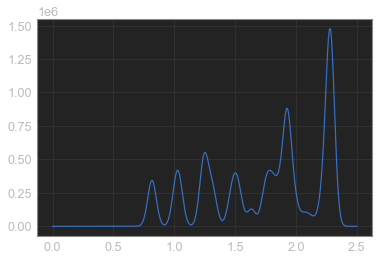

In [7]:
qd1 = qbd.qd_results(4, 1.2, 0.08, 0.08, "CB1")
qd2 = qbd.qd_results(4, 0.7, 0.08, 0.08, "VB1")
sim_properties = (20, 0.4, 2.3, (2e-25, 1e-25))
print(qd1.e_levels)
print(qd2.e_levels)
energy = np.linspace(0, 2.5, 300)
absorption = np.zeros_like(energy)
transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
for transition in transitions:
    t_energy = transition[0]
    matrix_element = transition[1][2]
    absorption += ab.absorption_ij(energy, t_energy, matrix_element, gauss_dispersion=0.05)
    
plt.plot(energy, absorption)

### Check transitions for different band combinations

The properties of used from here on

me-PbS = 0.08 me

mh-PbS = 0.08 me

Pt = 4.7e-25 Kg m/s[Kang]

Pl = 3.4e-25 Kg m/s [Kang]

Eg (if needed) = 2.3 eV

Eg-PbS = 0.4 eV

Vcb and Vvb are equal


I considered ml = mt (the values are relatively close to each other - 0.08 to 0.105 with errors around 0.015 [Dalven 1974])

In [33]:
me = 0.08
mh = 0.08
Pt = 4.7e-25
Pl = 3.4e-25
size = 4
Eg = 2.3
sim_properties = (10, 0.15, Eg, (Pl, Pt))
qdcb1 = qbd.qd_results(size, 0.85, me, me, "CB1")
qdcb2 = qbd.qd_results(size, 0.85, me, me, "CB2")
qdvb1 = qbd.qd_results(size, 0.85, mh, mh, "VB1")
qdvb2 = qbd.qd_results(size, 0.85, mh, mh, "VB2")
print(qdcb1.e_levels)
print(qdcb2.e_levels)
print(qdvb1.e_levels)
print(qdvb2.e_levels)

/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:67: RuntimeWarning: divide by zero encountered in true_divide
  f_E = 1.0 / np.tan(arg_cot) + np.sqrt(-(m2 / m1) * (energy /
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:72: RuntimeWarning: divide by zero encountered in true_divide
  j_term = special.spherical_jn(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:74: RuntimeWarning: divide by zero encountered in true_divide
  h_term = np.sqrt(-(m2 / m1) * (energy / (energy + V0))) * np.real(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:72: RuntimeWarning: invalid value encountered in true_divide
  j_term = special.spherical_jn(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:192: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:198: Integ

         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN
         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN
         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN
         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN


In [34]:
e_i = (0, 0)
e_f = (0, 0)
dummy = ab.envolute_matrix_element(qdcb1, e_i, qdvb1, e_f, sim_properties)
print("CB1 → VB1: ", dummy)
dummy = ab.envolute_matrix_element(qdcb1, e_i, qdvb2, e_f, sim_properties)
print("CB1 → VB2: ", dummy)
dummy = ab.envolute_matrix_element(qdcb2, e_i, qdvb1, e_f, sim_properties)
print("CB2 → VB1: ", dummy)
dummy = ab.envolute_matrix_element(qdcb2, e_i, qdvb2, e_f, sim_properties)
print("CB2 → VB2: ", dummy)

CB1 → VB1:  (0, 0, 0.07595954994639179)
CB1 → VB2:  (0.10609489540627426, 0, 0)
CB2 → VB1:  (0.10612760830256131, 0.10612760830256128, 0)
CB2 → VB2:  (0, 0, 0.07595954994639179)


# Article Results

The properties of used from here on:

|me-Pbs|mh-PbS|Pt[Kang]|Pl[Kang]|Eg-Psk|Eg-PbS|Vcb|Vvb|
|------|------|--|--|------|------|---|---|
|0.08|0.08|4.7e-25|3.4e-25|2.3|0.4|0.4|1.5|


I considered ml = mt (the values are relatively close to each other - 0.08 to 0.105 with errors around 0.015 [Dalven 1974])

The value for Vcb was determined by aligning the Electron Affinity levels for both perovskite with 2.3 eV [Tao 2019] and PbS [Gokalinska 2010] (4.6 - 4.2 = 0.4).
The value for Vvb is obtained from the difference between the bandgap and Vcb

## Convergence tests for calculating the M values

Determine the Mx, My and Mz values with the variation of several parameters.

This study is similar to the convergence test, where the objective is to see the ideal spot to do the simulations (lattice size and simulation size-wise)

The several studies included here:

- QSize vs Num Elevels - To check for QSize boundaries
- Potential barrier vs Num Elevels - To check for Potential barrier boundaries

Note: The following studies are made for all the interband transitions and for the first 2 transitions

- Lattice size vs Mx, My, Mz (for all the different parameters) [0.4:1.5] nm
- Simulation size vs Mx, My, Mz (for all the different parameters) [10:30] nm
- Execution time with increased lattice size and simulation size

In [14]:
dir_prefix = "Article_2_Results"
def update_step(it_num, total_it):
    """Helper function to print the iteration number
    in a for loop"""
    if it_num == total_it:
        print(f"\rIteration {it_num:04d}/{total_it:04d}")
    else:
        print(f"\rIteration {it_num:04d}/{total_it:04d}", end="")
    pass

### QSize vs Num Elevels / Barrier vs Num Elevels

In [16]:
# Calculate number of energy levels for different QD size
# and different potential Barriers
# This serves to define the default QDSize and the buffer size
# for the potential barrier for later use
n_size = 150
v_size = 150
qd_size = np.linspace(0.5, 10, n_size)
Vcb = np.linspace(0.1, 2.3, v_size)
me = 0.08
band = "CB1"
it = 0
n_levels = list()
for qd_size_i, V_i in product(qd_size, Vcb):
    it += 1
    update_step(it, n_size*v_size)
    qd1 = qbd.qd_results(qd_size_i, V_i, me, me, band)
    n_levels.append(np.isfinite(qd1.e_levels.values).sum())

n_levels = np.array(n_levels).reshape(n_size, v_size)
export_file = f"{dir_prefix}/QSize_PBarrier_NLevels_CB1.csv"
df = pd.DataFrame(n_levels, columns=Vcb, index=qd_size).to_csv(export_file, sep=" ")

Iteration 22500/22500

### Lattice size vs M_avg

In [27]:
## Helper functions to reduce the code/copy paste size
def single_convergence_sweep_sim(df, sim_size, qd_size=3,
                                 me=0.08,
                                 mh=0.08,
                                 Pt=4.7e-25,
                                 Pl=3.4e-25,
                                 Eg=2.3,
                                 Vcb=0.4,
                                 Vvb=1.5,
                                 lat_size=0.65):
    qd1_prop = (qd_size, Vvb, mh, mh)
    qd2_prop = (qd_size, Vcb, me, me)
    for sim_size_i in sim_size:
        sim_properties = (sim_size_i, lat_size, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.avg_trn_elements(qd1_prop, qd2_prop, sim_properties, 0)
        stop = timeit.default_timer()
        df.loc[sim_size_i, "Avg_Transition"] = transitions[0]
        df.loc[sim_size_i, "Energy"] = transitions[3][0] if len(transitions[3]) > 0 else 0
        df.loc[sim_size_i, "Time"] = stop-start

def single_convergence_sweep_lat(df, lat_size, qd_size=3,
                                 me=0.08,
                                 mh=0.08,
                                 Pt=4.7e-25,
                                 Pl=3.4e-25,
                                 Eg=2.3,
                                 Vcb=0.4,
                                 Vvb=1.5,
                                 sim_size=25):
    # Calculate the QD classes
    qd1_prop = (qd_size, Vvb, mh, mh)
    qd2_prop = (qd_size, Vcb, me, me)
    for lat_size_i in lat_size:
        sim_properties = (sim_size, lat_size_i, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.avg_trn_elements(qd1_prop, qd2_prop, sim_properties, 0)
        stop = timeit.default_timer()
        df.loc[lat_size_i, "Avg_Transition"] = transitions[0]
        df.loc[lat_size_i, "Energy"] = transitions[3][0] if len(transitions[3]) > 0 else 0
        df.loc[lat_size_i, "Time"] = stop-start

In [28]:
# Define the constant variables
# Number of points to simulate
n_lat = 50; n_param = 5

# Changing variables
lat_size = np.linspace(0.6, 1.5, n_lat)
export_name = lambda name: f"Convergence_065_25/LSize_{name}.csv"

# Export columns (for DataFrame)
columns = ["Avg_Transition", "Energy", "Time"]
df = pd.DataFrame(index=lat_size, columns=columns)
df.index.name="LSize"

# Loop values
param = np.linspace(1e-25, 1e-24, n_param)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_lat(df, lat_size, Pl=param_i)
    df.to_csv(export_name(f"Pl_{param_i:.2g}"))

param = np.linspace(1e-25, 1e-24, n_param)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_lat(df, lat_size, Pt=param_i)
    df.to_csv(export_name(f"Pt_{param_i:.2g}"))

param = np.round(np.linspace(0.05, 0.15, n_param), 2)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_lat(df, lat_size, me=param_i)
    df.to_csv(export_name(f"me_{param_i}"))

param = np.round(np.linspace(0.05, 0.15, n_param), 2)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_lat(df, lat_size, mh=param_i)
    df.to_csv(export_name(f"mh_{param_i}"))

param = np.round(np.linspace(1.5, 5, n_param), 1)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_lat(df, lat_size, qd_size=param_i)
    df.to_csv(export_name(f"QSize_{param_i}"))

param = np.round(np.linspace(10, 30, n_param), 1)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_lat(df, lat_size, sim_size=param_i)
    df.to_csv(export_name(f"SSize_{param_i}"))

param_i=1e-25
param_i=3.2499999999999995e-25
param_i=5.499999999999999e-25
param_i=7.749999999999999e-25
param_i=1e-24
param_i=1e-25
param_i=3.2499999999999995e-25
param_i=5.499999999999999e-25
param_i=7.749999999999999e-25
param_i=1e-24
param_i=0.05
param_i=0.08
param_i=0.1
param_i=0.12
param_i=0.15
param_i=0.05
param_i=0.08
param_i=0.1
param_i=0.12
param_i=0.15
param_i=1.5
param_i=2.4
param_i=3.2
param_i=4.1
param_i=5.0
param_i=10.0
param_i=15.0
param_i=20.0
param_i=25.0
param_i=30.0


### Simulation size vs M

In [30]:
# Define the constant variables
# Number of points to simulate
n_lat = 50; n_param = 5

sim_size = np.linspace(10, 25, n_lat)
export_name = lambda name: f"Convergence_065_25/SSize_{name}.csv"

# Export columns (for DataFrame)
columns = ["Avg_Transition", "Energy", "Time"]
df = pd.DataFrame(index=sim_size, columns=columns)
df.index.name="SSize"

# Loop values
param = np.linspace(1e-25, 1e-24, n_param)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_sim(df, sim_size, Pl=param_i)
    df.to_csv(export_name(f"Pl_{param_i:.2g}"))

param = np.linspace(1e-25, 1e-24, n_param)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_sim(df, sim_size, Pt=param_i)
    df.to_csv(export_name(f"Pt_{param_i:.2g}"))

param = np.round(np.linspace(0.05, 0.15, n_param), 2)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_sim(df, sim_size, me=param_i)
    df.to_csv(export_name(f"me_{param_i}"))

param = np.round(np.linspace(0.05, 0.15, n_param), 2)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_sim(df, sim_size, mh=param_i)
    df.to_csv(export_name(f"mh_{param_i}"))

param = np.round(np.linspace(1.5, 5, n_param), 1)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_sim(df, sim_size, qd_size=param_i)
    df.to_csv(export_name(f"QSize_{param_i}"))

param = np.round(np.linspace(0.6, 1.5, n_param), 1)
for param_i in param:
    print(f"{param_i=}")
    single_convergence_sweep_sim(df, sim_size, lat_size=param_i)
    df.to_csv(export_name(f"LSize_{param_i}"))

param_i=1e-25
param_i=3.2499999999999995e-25
param_i=5.499999999999999e-25
param_i=7.749999999999999e-25
param_i=1e-24
param_i=1e-25
param_i=3.2499999999999995e-25
param_i=5.499999999999999e-25
param_i=7.749999999999999e-25
param_i=1e-24
param_i=0.05
param_i=0.08
param_i=0.1
param_i=0.12
param_i=0.15
param_i=0.05
param_i=0.08
param_i=0.1
param_i=0.12
param_i=0.15
param_i=1.5
param_i=2.4
param_i=3.2
param_i=4.1
param_i=5.0
param_i=0.6
param_i=0.8
param_i=1.0
param_i=1.3
param_i=1.5


## Main Properties Study

### Old Method

In [30]:
# Global properties
band_i = "VB2"; band_f = "CB2"
transition = 0
n_param = 100

In [50]:
# me
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(0.05, 0.15, n_param)

for me in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_me"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_me"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_me"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_me"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_me"), sep=" ")

Iteration 0044/0100

KeyboardInterrupt: 

In [32]:
# mh
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(0.05, 0.15, n_param)

for mh in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_mh"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_mh"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_mh"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_mh"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_mh"), sep=" ")

Iteration 0100/0100


In [33]:
# Pt
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)

for Pt in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_Pt"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_Pt"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_Pt"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_Pt"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_Pt"), sep=" ")

Iteration 0100/0100


In [34]:
# Pl
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)

for Pl in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_Pl"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_Pl"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_Pl"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_Pl"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_Pl"), sep=" ")

Iteration 0100/0100


In [35]:
#Qsize
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(2, 7, n_param)

for qd_size in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_QSize"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_QSize"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_QSize"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_QSize"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_QSize"), sep=" ")

Iteration 0100/0100


### New Method

Since there are many transitions to consider, when doing these simulations:
- The angular element due to the incidence of light
- The transition between band combinations

It was chosen to average everything out, in order to simplify the calculation and data aquisition process.
Hence the data was averaged, in order to obtain a single component that represents the overall transition

This function calculates the average transition elements for a particular transition trn

For all transition elements it is better to use the all_avg_trn_elements function

```python
def avg_trn_elements(qd1_prop, qd2_prop, sim_properties, trn=0):
    """
    Function to determine the averaged transition element for a particular set
    of QD Properties
    This function only calculates the values for a certain transition as well
    as provides all the information for that particular transition
    """
    # Unpack parameters for each QD
    qd1_size, Vvb, mh, mh = qd1_prop
    logging.debug(f"{qd1_size=}\t{Vvb=}\t{mh=}\t{mh=}")
    qd2_size, Vcb, me, me = qd2_prop
    logging.debug(f"{qd2_size=}\t{Vcb=}\t{me=}\t{me=}")
    bi = ["VB1", "VB2"]
    bf = ["CB1", "CB2"]
    avg_elements = []
    trn_elements = []
    trn_energy = []
    # Create a list with the transition elements for each band transition
    for b_i, b_f in product(bi, bf):
        logging.debug(f"{b_i=} {b_f=}")
        qd1 = qbd.qd_results(qd1_size, Vvb, mh, mh, b_i)
        qd2 = qbd.qd_results(qd2_size, Vcb, me, me, b_f)
        transition = interband_transition_elements(qd1,
                                                   qd2,
                                                   sim_properties,
                                                   count=trn + 1)
        logging.debug(f"{transition=}")
        # Average the results of each band transition
        if len(transition) > trn:
            band_trn = np.pi / 4 * transition[trn][1][
                0]**2 + np.pi / 4 * transition[trn][1][
                    1]**2 + np.pi / 2 * transition[trn][1][2]**2
            trn_elements.append([
                transition[trn][1][0], transition[trn][1][1],
                transition[trn][1][2]
            ])
            avg_elements.append(band_trn)
        else:
            logging.info(f"{trn=} is outside the number of valid transitions")
            trn_elements.append(np.NaN)
            avg_elements.append(np.NaN)
            break
    # Also export all the transition energies
    trn_energy = [trn[0] for trn in transition]
    logging.debug(f"{trn_energy = }")
    logging.debug(f"{avg_elements = }")
    avg_elements = np.array(avg_elements)
    avg_trn_final = np.average(avg_elements)
    # else:
    #     avg_trn_final = 0
    return avg_trn_final, avg_elements, trn_elements, trn_energy
```

The objective with this part is to determine how the total avg transition properties change
with the severall parameters.\
These results show the changes for:
- The first 4 energy levels
- The relevant properties (QSize, me, mh, Pl, Pt)
- The results for different mesh conditions (0.8/15, 0.65/15, 0.65/25)

In [55]:
lat_size = [0.65, 0.8]; sim_size = [15, 25]; level = [0, 1, 2]
list(product(lat_size, sim_size, level))

[(0.65, 15, 0),
 (0.65, 15, 1),
 (0.65, 15, 2),
 (0.65, 25, 0),
 (0.65, 25, 1),
 (0.65, 25, 2),
 (0.8, 15, 0),
 (0.8, 15, 1),
 (0.8, 15, 2),
 (0.8, 25, 0),
 (0.8, 25, 1),
 (0.8, 25, 2)]

In [15]:
n_points = 100 # Number of points to calculate for each element
# Header to export the data
header = "Variable TAvg AAvg_VB1_CB1 AAvg_VB1_CB2 AAvgVB2_CB1 AAvgVB2_CB2 Mx_VB1_CB1 My_VB1_CB1 Mz_VB1_CB1"+\
         " Mx_VB1_CB2 My_VB1_CB2 Mz_VB1_CB2 Mx_VB2_CB1 My_VB2_CB1 Mz_VB2_CB1 Mx_VB2_CB2 My_VB2_CB2 Mz_VB2_CB2"
# Default values
Eg = 2.3; Pt = 4.7e-25; Pl = 3.4e-25
me = 0.08; mh = 0.08; Vcb = 0.4; Vvb = 1.5; qd_size = 3;

# Level to calculate the properties
lat_size_array = [0.8, 0.65]; sim_size_array = [15, 25]; level_array = [0, 1, 2, 3]

for lat_size, sim_size, level in product(lat_size_array, sim_size_array, level_array):
    logging.info(f"{lat_size=}::{sim_size=}::{level=}")
    run_i = 0
    # Arrays to store the final results
    total_avg = np.zeros(n_points)
    individual_trn = np.ones(shape=(n_points,4))
    individual_elements = np.ones(shape=(n_points, 4, 3))

    # Calculate for changing me
    logging.info("Changing me")
    logging.info(f"{Eg=} {Pt=} {Pl=} {lat_size=} {sim_size=}")
    for i, me_i in enumerate(np.linspace(0.05, 0.15, n_points)):
        update_step(i+1, n_points)
        qd1_prop = (qd_size, Vvb, mh, mh)
        qd2_prop = (qd_size, Vcb, me_i, me_i)
        sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
        avg_trn, avg_ang_trn, trn_elements, trn_energy = ate(qd1_prop, qd2_prop, sim_properties, trn=level)
        if avg_trn > 0:
            total_avg[i] = avg_trn
            individual_trn[i] = np.array(avg_ang_trn)
            individual_elements[i] = np.array(trn_elements)
        else:
            total_avg[i] = np.NaN; individual_trn[i] = np.NaN; individual_elements[i] = np.NaN

    logging.debug(f"{total_avg=}\n{individual_trn=}\n{individual_elements=}")
    export_data = np.concatenate(
        (np.linspace(0.05, 0.15, n_points)[:, np.newaxis],
         total_avg.T[:, np.newaxis],
         individual_trn,
         individual_elements.reshape(n_points, 4*3)),
        axis=1)
    np.savetxt(f"me_L{level}_LSize{lat_size}_SSize{sim_size}_TAvg_AAvg_Mx_My_Mz.csv", export_data, header=header)

    # Calculate for changing mh
    logging.info("Changing mh")
    logging.info(f"{Eg=} {Pt=} {Pl=} {lat_size=} {sim_size=}")
    for i, mh_i in enumerate(np.linspace(0.05, 0.15, n_points)):
        update_step(i+1, n_points)
        qd1_prop = (qd_size, Vvb, mh_i, mh_i)
        qd2_prop = (qd_size, Vcb, me, me)
        sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
        avg_trn, avg_ang_trn, trn_elements, trn_energy = ate(qd1_prop, qd2_prop, sim_properties, trn=level)
        if avg_trn > 0:
            total_avg[i] = avg_trn
            individual_trn[i] = np.array(avg_ang_trn)
            individual_elements[i] = np.array(trn_elements)
        else:
            total_avg[i] = np.NaN; individual_trn[i] = np.NaN; individual_elements[i] = np.NaN

    logging.debug(f"{total_avg=}\n{individual_trn=}\n{individual_elements=}")
    export_data = np.concatenate(
        (np.linspace(0.05, 0.15, n_points)[:, np.newaxis],
         total_avg.T[:, np.newaxis],
         individual_trn,
         individual_elements.reshape(n_points, 4*3)),
        axis=1)
    np.savetxt(f"mh_L{level}_LSize{lat_size}_SSize{sim_size}_TAvg_AAvg_Mx_My_Mz.csv", export_data, header=header)

    # Calculate for changing Pl
    logging.info("Changing Pl")
    logging.info(f"{Eg=} {Pt=} {Pl=} {lat_size=} {sim_size=}")
    for i, Pl_i in enumerate(np.linspace(1e-25, 1e-24, n_points)):
        update_step(i+1, n_points)
        qd1_prop = (qd_size, Vvb, mh, mh)
        qd2_prop = (qd_size, Vcb, me, me)
        sim_properties = (sim_size, lat_size, Eg, (Pl_i, Pt))
        avg_trn, avg_ang_trn, trn_elements, trn_energy = ate(qd1_prop, qd2_prop, sim_properties, trn=level)
        if avg_trn > 0:
            total_avg[i] = avg_trn
            individual_trn[i] = np.array(avg_ang_trn)
            individual_elements[i] = np.array(trn_elements)
        else:
            total_avg[i] = np.NaN; individual_trn[i] = np.NaN; individual_elements[i] = np.NaN

    logging.debug(f"{total_avg=}\n{individual_trn=}\n{individual_elements=}")
    export_data = np.concatenate(
        (np.linspace(1e-25, 1e-24, n_points)[:, np.newaxis],
         total_avg.T[:, np.newaxis],
         individual_trn,
         individual_elements.reshape(n_points, 4*3)),
        axis=1)
    np.savetxt(f"Pl_L{level}_LSize{lat_size}_SSize{sim_size}_TAvg_AAvg_Mx_My_Mz.csv", export_data, header=header)

    # Calculate for changing Pt
    logging.info("Changing Pt")
    logging.info(f"{Eg=} {Pt=} {Pl=} {lat_size=} {sim_size=}")
    for i, Pt_i in enumerate(np.linspace(1e-25, 1e-24, n_points)):
        update_step(i+1, n_points)
        qd1_prop = (qd_size, Vvb, mh, mh)
        qd2_prop = (qd_size, Vcb, me, me)
        sim_properties = (sim_size, lat_size, Eg, (Pl, Pt_i))
        avg_trn, avg_ang_trn, trn_elements, trn_energy = ate(qd1_prop, qd2_prop, sim_properties, trn=level)
        if avg_trn > 0:
            total_avg[i] = avg_trn
            individual_trn[i] = np.array(avg_ang_trn)
            individual_elements[i] = np.array(trn_elements)
        else:
            total_avg[i] = np.NaN; individual_trn[i] = np.NaN; individual_elements[i] = np.NaN

    logging.debug(f"{total_avg=}\n{individual_trn=}\n{individual_elements=}")
    export_data = np.concatenate(
        (np.linspace(1e-25, 1e-24, n_points)[:, np.newaxis],
         total_avg.T[:, np.newaxis],
         individual_trn,
         individual_elements.reshape(n_points, 4*3)),
        axis=1)
    np.savetxt(f"Pt_L{level}_LSize{lat_size}_SSize{sim_size}_TAvg_AAvg_Mx_My_Mz.csv", export_data, header=header)

    # Calculate for changing QSize
    logging.info("Changing QSize")
    logging.info(f"{Eg=} {Pt=} {Pl=} {lat_size=} {sim_size=}")
    for i, qd_size_i in enumerate(np.linspace(1, 10, n_points)):
        update_step(i+1, n_points)
        qd1_prop = (qd_size_i, Vvb, mh, mh)
        qd2_prop = (qd_size_i, Vcb, me, me)
        sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
        avg_trn, avg_ang_trn, trn_elements, trn_energy = ate(qd1_prop, qd2_prop, sim_properties, trn=level)
        if avg_trn > 0:
            total_avg[i] = avg_trn
            individual_trn[i] = np.array(avg_ang_trn)
            individual_elements[i] = np.array(trn_elements)
        else:
            total_avg[i] = np.NaN; individual_trn[i] = np.NaN; individual_elements[i] = np.NaN

    logging.debug(f"{total_avg=}\n{individual_trn=}\n{individual_elements=}")
    export_data = np.concatenate(
        (np.linspace(1.5, 10, n_points)[:, np.newaxis],
         total_avg.T[:, np.newaxis],
         individual_trn,
         individual_elements.reshape(n_points, 4*3)),
        axis=1)
    
    np.savetxt(f"QSize_L{level}_LSize{lat_size}_SSize{sim_size}_TAvg_AAvg_Mx_My_Mz.csv", export_data, header=header)

Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100
Iteration 0100/0100


## Check all info for a single system

Determine Mx/My/Mz for all possible 4 transitions for the default QD System

In [2]:
# Bands
bi = ["VB1", "VB2"]; bf = ["CB1", "CB2"]
# Default Values
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5;
sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
# Results
for b_i, b_f in product(bi, bf):
    print(b_i, b_f)
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, b_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, b_f)
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    print(transitions)
    results_df = pd.DataFrame([[i+1, trn, mx, my, mz] for i, (trn, (mx, my, mz)) in enumerate(transitions)])
    results_df.to_csv(f"M_default_{b_i}_{b_f}.csv", sep=" ")

VB1 CB1
[(1.0229957252515653, (0.00034665568323333473, 0.0003466556832333318, 0.12280716976280871)), (1.3933784997325513, (0.0004547416457147179, 0.0002291608080698295, 0.08215533512218344)), (1.841660362705014, (0.0001430232432437704, 0.00015383453650168183, 0.053480881266087785)), (2.002479686947818, (0, 0, 0.051897038300611875))]
VB1 CB2
[(1.0229957252515653, (0.18426939576669857, 0.18431505232433698, 0.00031135370350126245)), (1.3933784997325513, (0.13010467155946784, 0.10325650091329146, 0.0002639233326682529)), (1.841660362705014, (0.10295981561831924, 0.07557752156591822, 0)), (2.002479686947818, (0.07626961011876067, 0.07626608160601063, 0))]
VB2 CB1
[(1.0229957252515653, (0.18204732131599077, 0.030798873891170492, 0.001898515203256452)), (1.3933784997325513, (0.1588420909713445, 0.10416502437772746, 0.005468900189660523)), (1.841660362705014, (0.1807532626279083, 0.17608663269298003, 0.006609330987092052)), (2.002479686947818, (0.07416899888984071, 0.4014204484574553, 0.002162

Calculate envolutes for the basic system

Get the wavefunction and 4 envolutes for the single level in the CB

In [3]:
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5;
l = 0; m = 0; n = 0
env = ["L6pb", "L6pt", "L6mb", "L6mt"]
band = "CB1"
x = np.arange(-sim_size, sim_size, lat_size)
qd_wavefunction = qbd.qd_results(qd_size, Vcb, me, me, band)
XX, YY, ZZ, WVFC = qd_wavefunction.norm_wavefunction(x, x, x, l, m, n)
gridToVTK(f"Article_2_Results/band_{band}_wavefunction_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(WVFC)**2})
for env_i in env:
    XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, env_i, l, m, n, Eg, (Pl, Pt))
    gridToVTK(f"Article_2_Results/band_{band}_envolute_{env_i}_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_S)**2})

## Matrix elements variation with angle

VB1 CB1
VB1 CB2
VB2 CB1
VB2 CB2


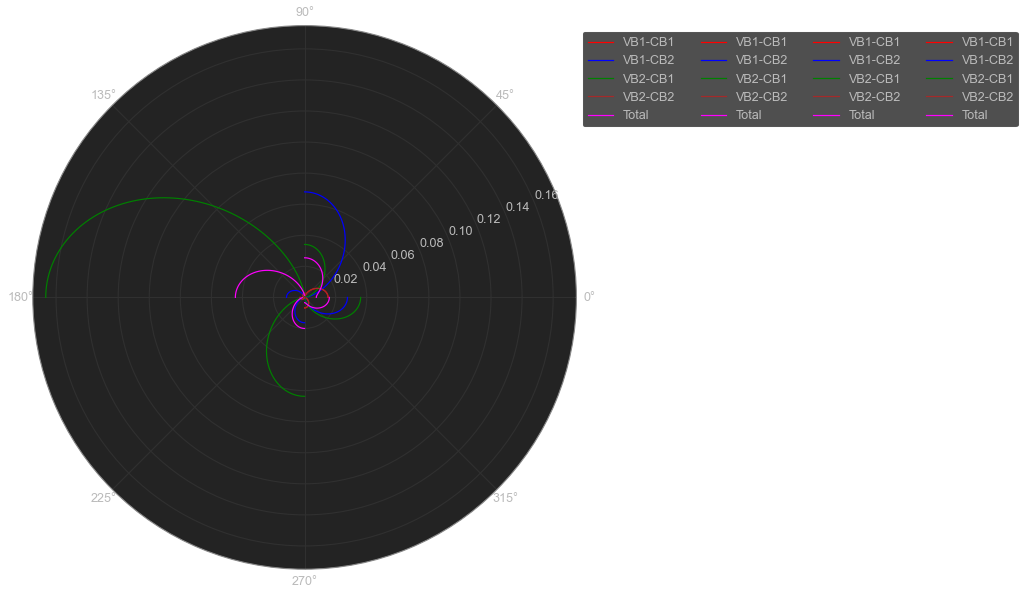

In [12]:
# Bands
bi = ["VB1", "VB2"]; bf = ["CB1", "CB2"]
# Default Values
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5;
sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
band_list = list()
# Results
for b_i, b_f in product(bi, bf):
    print(b_i, b_f)
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, b_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, b_f)
    band_list.append(ab.interband_transition_elements(qd1, qd2, sim_properties))

theta = np.linspace(0, np.pi/2, 100)
angular_elements = list()
trn = 3
plt.figure(figsize=(10,10))
ax = plt.subplot(projection="polar")
for t_i in range(trn+1):
    export_data = np.array(theta[:, np.newaxis])
    angular_elements = list()
    for b_i in band_list:
        trn_2 = np.sin(theta)**2*b_i[t_i][1][0]**2 + np.sin(theta)**2*b_i[t_i][1][1]**2 + np.cos(theta)**2*b_i[t_i][1][2]**2
        export_data = np.concatenate((export_data, trn_2[:, np.newaxis]), axis=1)
        angular_elements.append(trn_2)
    avg_trn = (angular_elements[0]+angular_elements[1]+angular_elements[2]+angular_elements[3])/4
    export_data = np.concatenate((export_data, avg_trn[:, np.newaxis]), axis=1)
    ax.plot(theta-np.pi*t_i/2, angular_elements[0], 'red', label="VB1-CB1")
    ax.plot(theta-np.pi*t_i/2, angular_elements[1], 'blue', label="VB1-CB2")
    ax.plot(theta-np.pi*t_i/2, angular_elements[2], 'green', label="VB2-CB1")
    ax.plot(theta-np.pi*t_i/2, angular_elements[3], 'brown', label="VB2-CB2")
    ax.plot(theta-np.pi*t_i/2, avg_trn, 'magenta', label="Total")
    df = pd.DataFrame(export_data, columns=["theta", "VB1-CB1", "VB1-CB2", "VB2-CB1", "VB2-CB2", "AVG"])
    df.to_csv(f"Angular_Band_Trn_{t_i}.csv", sep=" ", index=False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=4)
plt.show()

## Testing Eg/V variation

In [3]:
def V_offset(Host_Eg, QD_Eg, offset_ratio):
    """ Return the adequately offseted Vcv/Vvb values """
    Vcb = (Host_Eg - QD_Eg)*offset_ratio
    Vvb = (Host_Eg - QD_Eg)*(1-offset_ratio)
    return Vcb, Vvb

Iteration 4000/4000


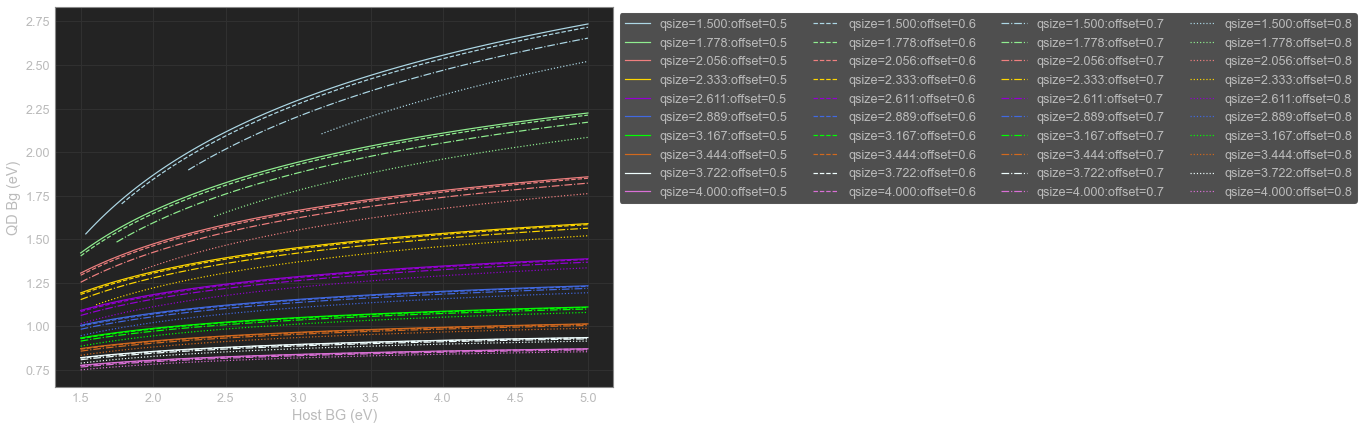

In [35]:
me=0.08; mh=0.08; Pt=4.7e-25; Pl=3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
run_i = 0
Eg = np.linspace(1.5, 5, 100)
qd_size = np.linspace(1.5, 4, 10)
band_i = "VB1"; band_f = "CB1"
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'darkviolet', 'royalblue', 'lime', 'chocolate', 'azure', 'orchid']
lt_list = ['-', '--', '-.', ':']
plt.figure(figsize=(10,7))
for lt, offset in enumerate([0.5, 0.6, 0.7, 0.8]):
    results = [list() for i in qd_size]
    Vcb, Vvb = V_offset(Eg, 0.4, offset)
    for result_i, qd_size_i in zip(results, qd_size):
        for Eg_i, Vcb_i, Vvb_i in zip(Eg, Vcb, Vvb):
            ## Calculate
            run_i+=1
            update_step(run_i, 4*10*100)
            qd1 = qbd.qd_results(qd_size_i, Vvb_i, mh, mh, band_i)
            qd2 = qbd.qd_results(qd_size_i, Vcb_i, me, me, band_f)
            try:
                trn = ab.interband_transition_elements(qd1, qd2, (sim_size, lat_size, Eg_i, (Pl, Pt)), count=1)[0][0]
            except IndexError:
                trn = np.nan
            result_i.append(trn)
        result_i = np.array(result_i)
        df = pd.DataFrame(result_i, columns=["QD_BG"], index=Eg)
        df["QD_Size"] = qd_size_i; df["Offset"] = offset
        df.to_csv(f"QD_BG_{qd_size_i:0.3f}_{offset}.csv", sep=" ", na_rep="NaN")
    ## Plot
    for i, qsize in enumerate(qd_size):
        plt.plot(Eg, results[i], colors[i], linestyle=lt_list[lt], label=f"{qsize=:0.3f}:{offset=}")

plt.xlabel("Host BG (eV)")
plt.ylabel("QD Bg (eV)")
plt.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=4)

Iteration 2000/4000

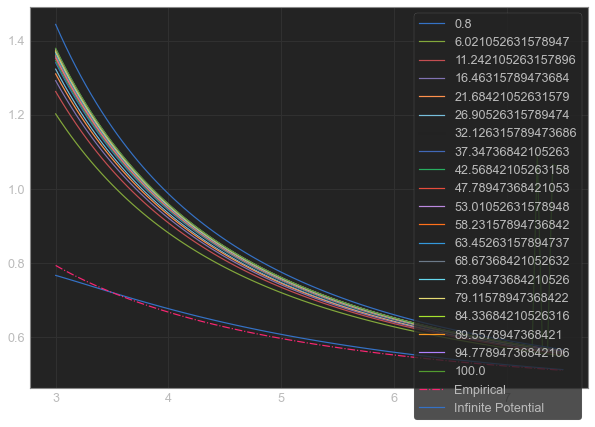

In [7]:
me=0.08; mh=0.08; Pt=4.7e-25; Pl=3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
run_i = 0
Eg = np.linspace(0.8, 100, 20)
qd_size = np.linspace(3, 7.5, 100)
band_i = "VB1"; band_f = "CB1"
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'darkviolet', 'royalblue', 'lime', 'chocolate', 'azure', 'orchid']
lt_list = ['-', '--', '-.', ':']
plt.figure(figsize=(10,7))
res_df = pd.DataFrame()
res_df["QSize"] = qd_size
for eg_i in Eg:
    Vcb, Vvb = V_offset(eg_i, 0.4, 0.5)
    results = []
    for qd_size_i in qd_size:
        ## Calculate
        run_i+=1
        update_step(run_i, 4*10*100)
        qd1 = qbd.qd_results(qd_size_i, Vvb, mh, mh, band_i)
        qd2 = qbd.qd_results(qd_size_i, Vcb, me, me, band_f)
        try:
            trn = ab.interband_transition_elements(qd1, qd2, (sim_size, lat_size, eg_i, (Pl, Pt)), count=1)[0][0]
        except IndexError:
            trn = np.nan
        results.append(trn)
    res_df[f"{eg_i=}"] = results
    plt.plot(qd_size, results, label=f"{eg_i}")
res_df.to_csv("QDEg_QSize.csv", sep=" ", index=False)
plt.plot(qd_size, 0.41+1/(0.0252*(2*qd_size)**2+0.283*(2*qd_size)), '-.', label="Empirical")
plt.plot(qd_size, 0.4 + 2*9.87/(26.26*0.08*qd_size**2), label="Infinite Potential")
plt.legend()
plt.show()

## The absorption coefficient

### Helper functions

```python
def all_avg_trn_elements(qd1_prop, qd2_prop, sim_properties):
    """
    Function to determine all the avg transition elements for 2 qds
    Args:
        qd1_prop/qd2_prop (tuple): (qd_size, V, me, me)
        sim_properties (tuple): (s_size, l_size, Eg, (Pl, Pt))
    Returns:
        - e_trn (list): List with all the transition energies
        - band_elements (list): List with all the averaged transition elements
    """
    # Unpack parameters for each QD
    qd1_size, Vvb, mh, mh = qd1_prop
    logging.debug(f"{qd1_size=}\t{Vvb=}\t{mh=}\t{mh=}")
    qd2_size, Vcb, me, me = qd2_prop
    logging.debug(f"{qd2_size=}\t{Vcb=}\t{me=}\t{me=}")
    bi = ["VB1", "VB2"]
    bf = ["CB1", "CB2"]
    band_elements = []
    # Create a list with the transition elements for each band transition
    for b_i, b_f in product(bi, bf):
        logging.debug(f"{b_i=} {b_f=}")
        qd1 = qbd.qd_results(qd1_size, Vvb, mh, mh, b_i)
        qd2 = qbd.qd_results(qd2_size, Vcb, me, me, b_f)
        # List with all the transitions
        transition = interband_transition_elements(qd1, qd2, sim_properties)
        logging.debug(f"{transition=}")
        # Average the results of each band transition and for each transition
        band_trn = [
            np.pi / 4 * trn[1][0]**2 + np.pi / 4 * trn[1][1]**2 +
            np.pi / 2 * trn[1][2]**2 for trn in transition
        ]
        band_elements.append(band_trn)
    # Get all the transition energies
    e_trn = [trn[0] for trn in transition]
    logging.debug(f"{e_trn = }")
    band_elements = np.array(band_elements)
    logging.debug(f"{band_elements=}")
    # Check if there are transitions
    if band_elements.shape[1] < 1:
        logging.debug("No transition determined for this system")
        return np.nan, np.nan
    avg_trn_final = np.average(band_elements, axis=0)
    return e_trn, avg_trn_final
```

In [44]:
# Check if everything is ok
Eg = 2.3; Pt = 4.7e-25; Pl = 3.4e-25; lat_size = 0.8; sim_size = 15
me = 0.08; mh = 0.08; Vcb = 0.6; Vvb = 1.5; qd_size = 3;
sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
ab.all_avg_trn_elements((qd_size, Vcb, me, me), (qd_size, Vvb, mh, mh), sim_properties)

([0.8604529966248198,
  1.1263177183537414,
  1.2308357711058058,
  1.4967004928347274,
  1.6791176340782685,
  1.8399369583210725,
  1.9449823558071901,
  2.105801680049994],
 array([0.04437713, 0.02739157, 0.02434689, 0.04070482, 0.02126494,
        0.02852503, 0.02784243, 0.05210766]))

### The complete interband absorption for a particular system

```python
def interband_absorption(e_array,
                         qd_cb,
                         qd_vb,
                         sim_properties,
                         n_index=2.5,
                         peak_dispersion=0.025):
    """ Calculate the interdand absorption given 2 qds and the simulation conditions
    Args:
        e_array (array): x-array with the energy values
        qd_cb/qd_vb (tuple): (q_size, V, m, m)
        sim_properties (tuple): (Ssize, LSize, Eg, (Pl, Pt))
        n_index (float/array): Array with the refractive index values
        peak_dispersion (float): Dispersion of the absorption peal
    Returns:
        absorption_per_density (nm3/cm): final total absorption coefficient per density
        absorption_per_peak: array with absorption coefficient for each peak
    
    """
    # Initialize necessary constants
    # C, J.s, m/s, C^2/(N.m^2) the powers cut in the fraction
    q, h, c, e0 = 1.6022, 6.626, 2.9979, 8.8542
    # Calculate the fraction responsible for the units
    constant_fraction = ((2 * np.pi**2 * q**2 * e_array) /
                         (n_index * c * h * e0))
    trn_energies, trn_elements = all_avg_trn_elements(qd_vb, qd_cb,
                                                      sim_properties)
    logging.debug(f"{trn_energies=}\n{trn_elements}")
    results = pd.DataFrame()
    results["Energy"] = e_array
    if np.all(np.isnan(trn_energies)):
        logging.warning(
            f"No transitions for qd: {qd_cb=} {qd_vb=} {sim_properties=}")
        results["Total"] = np.nan
        return results
    results["Total"] = np.zeros_like(e_array)
    for (index, trn_energy), trn_element in zip(enumerate(trn_energies),
                                                trn_elements):
        logging.debug(f"Transition: {trn_energy = } and {trn_element = }")
        # Determine the gaussian approximation of the delta peak
        delta_peak = (1 / (np.sqrt(np.pi) * peak_dispersion)) * np.exp(-(
            (e_array - trn_energy) / peak_dispersion)**2)
        delta_peak *= 2 * trn_element * constant_fraction * 1e7
        results[f"T{index}({trn_energy:.3f})"] = delta_peak
        # Absorption (the 1e7 term moves the units to nm3cm-1)
        results["Total"] += delta_peak
    return results
```

In [33]:
# Check if everything is ok
Eg = 2.3; Pt = 4.7e-25; Pl = 3.4e-25; lat_size = 0.8; sim_size = 15
me = 0.08; mh = 0.08; Vcb = 0.4; Vvb = 1.5; qd_size = 3;
sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
data = ab.interband_absorption(np.linspace(0.5, 2.5, 200), (qd_size, Vcb, me, me), (qd_size, Vvb, mh, mh), sim_properties)

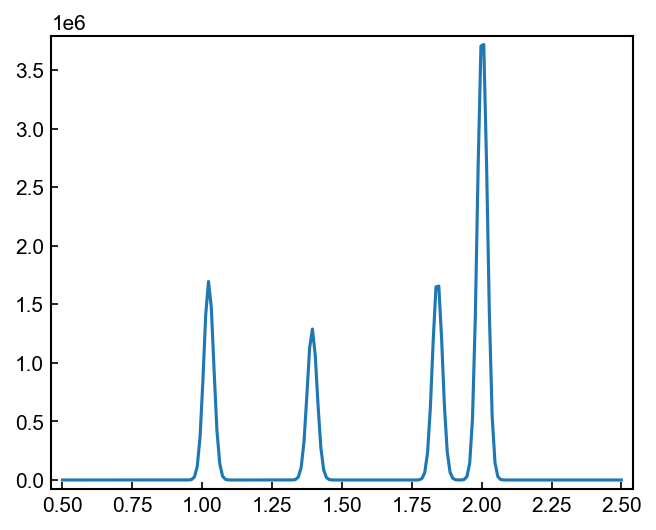

In [34]:
plt.plot(data["Energy"], data["Total"])

<AxesSubplot:xlabel='Energy'>

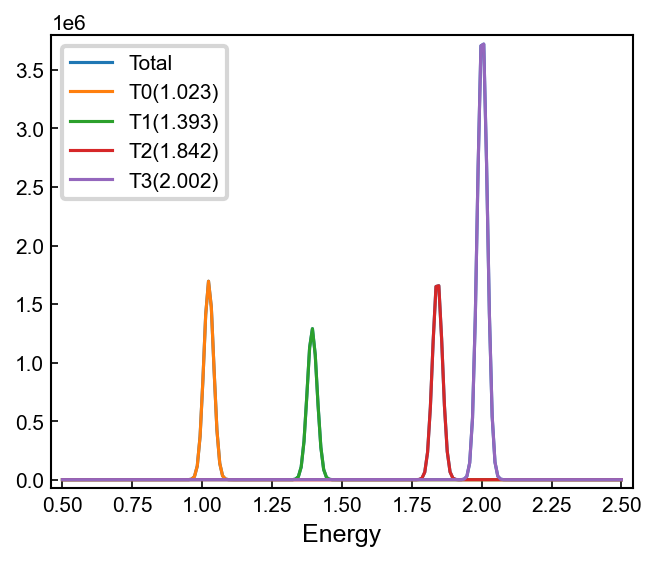

In [43]:
data.plot("Energy")

## Optimization

Code to perform a particle swarm optimization.
Essentialy there are 2 parts necessary:
- A dictionary with the several parameters (same name as defined in the function)
    - The should be defined as a list with the lower and upper bound for the parameters
- An optional dictionary with the some of the optional parameters
- The particle swarm function that does the actial optimization

In [57]:
param_dict = {
    "qd_size": [1.5, 3],
    "me": [0.05, 0.15],
    "mh": [0.05, 0.15],
    "Pl": [1e-25, 1e-24],
    "Pt": [1e-25, 1e-24],
    "Eg": [1, 2.5],
    "offset": [0.2, 0.8]
}
const_args = {
    "energy": np.linspace(0.5, 4, 600),
    "lat_size": 0.65,
    "sim_size": 25
}
res = particle_swarm(ab.opt_function, param_dict,
                     n_particles=15, n_iter=30,
                     export=True, swarm_properties=(0.3, 1.5, 1.5),
                     **const_args)

Helper function to summarize all the optimization results into 5 different plots

```python
def pso_summary(results_folder, columns, iterations, export=False, **plot_kwargs):
    """ Make a summary of all the optimization results.
    Args:
        - results folder: folder where the results where stored
        - columns: a list with the column names from the optimization (should have FoM for the FoM)
        - iterations: the number of iterations
        - export: whether to export data or not (it export as svg)
        - **plot_kwargs: mostly to pass the figure size of the different plots
    It will plot:
        - Parameter histogram
        - Particle movement for each parameter
        - FOM variation for all particles
        - The first two but for the velocities
    """
    if !os.path.isdir(results_folder):
        raise Exception("Provided path is not a directory!")
    if len(columns) % 2 != 1:
        raise Exception("Invalid number of columns....")
    # Import data into a pandas DF
    import_data = []
    for i in range(iterations):
        import_data.append(pd.read_csv(f"{results_folder}/results_{i}", sep=" ", names=columns))
    data = pd.concat(import_data, keys=list(range(n_iter)))
    n_params = int(len(columns) - 1/2)
    # Plot the histograms
    fig, ax = plt.subplots(1, n_params, **plot_kwargs)
    plt.subplots_adjust(wspace=0.15, left=0.05, right=0.95)
    # Plot the histograms
    for index, variable in enumerate(columns[:n_params]):
        chart = sns.histplot(data=data,y=variable,color=colors[index], kde=True, bins=50, ax=ax[index])
        ax[index].tick_params(axis="y", rotation=90)
        ax[index].set_ylabel("")
        ax[index].set_title(variable)
    ax[0].set_ylabel("Variable")
    if export:
        plt.savefig(f"{results_folder}/pso_property_hist.svg", transparent=True)

    # Plot values per iteration
    fig, ax = plt.subplots(1, n_params, **plot_kwargs)
    plt.subplots_adjust(wspace=0.15, left=0.05, right=0.95)
    # Plot the histograms
    for index, variable in enumerate(columns[:n_params]):
        for it in range(iterations):
            ax[index].scatter(np.zeros(15) + it, data.loc[it, variable], color=colors[index])
        ax[index].tick_params(axis="y", rotation=90)
        ax[index].set_ylabel("")
        ax[index].set_title(variable)
    ax[0].set_ylabel("Variable")
    if export:
        plt.savefig(f"{results_folder}/pso_property_iter.svg", transparent=True)

    # Plot the FoM for the various iterations
    fig, ax = plt.subplots(1, 1)
    for it in range(iterations):
        ax.scatter(np.zeros(15) + it, data.loc[it, "FoM"], color=colors[index])
    ax.set_ylabel("FoM")
    ax.set_xlabel("Iteration")
    if export:
        plt.savefig(f"{results_folder}/pso_FoM.svg", transparent=True)

    # Plot for the velocities
    fig, ax = plt.subplots(1, n_params, **plot_kwargs)
    for index, variable in enumerate(columns[8:]):
        chart = sns.histplot(data=data,y=variable,color=colors[index], kde=True, bins=50, ax=ax[index])
        ax[index].tick_params(axis="y", rotation=90)
        ax[index].set_ylabel("")
        ax[index].set_title(variable)
    ax[0].set_ylabel("Variable")
    if export:
        plt.savefig(f"{results_folder}/pso_property_vhist.svg", transparent=True)

    # Plot values per iteration
    fig, ax = plt.subplots(1, n_params, **plot_kwargs)
    plt.subplots_adjust(wspace=0.15, left=0.05, right=0.95)
    # Plot the histograms
    for index, variable in enumerate(columns[n_params+1:]):
        for it in range(n_iter):
            ax[index].scatter(np.zeros(15) + it, data.loc[it, variable], color=colors[index])
        ax[index].tick_params(axis="y", rotation=90)
        ax[index].set_ylabel("")
        ax[index].set_title(variable)
    ax[0].set_ylabel("Variable")
    if export:
        plt.savefig(f"{results_folder}/pso_property_viter.svg", transparent=True)
```

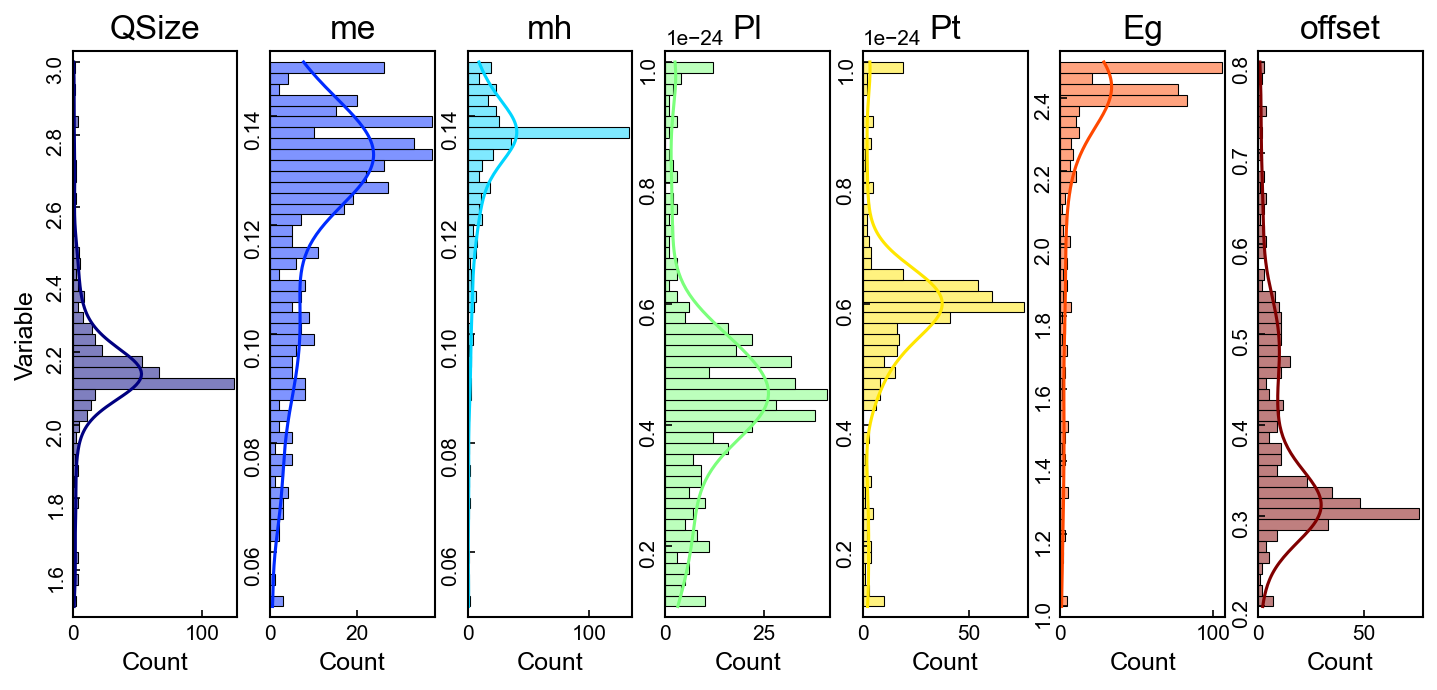

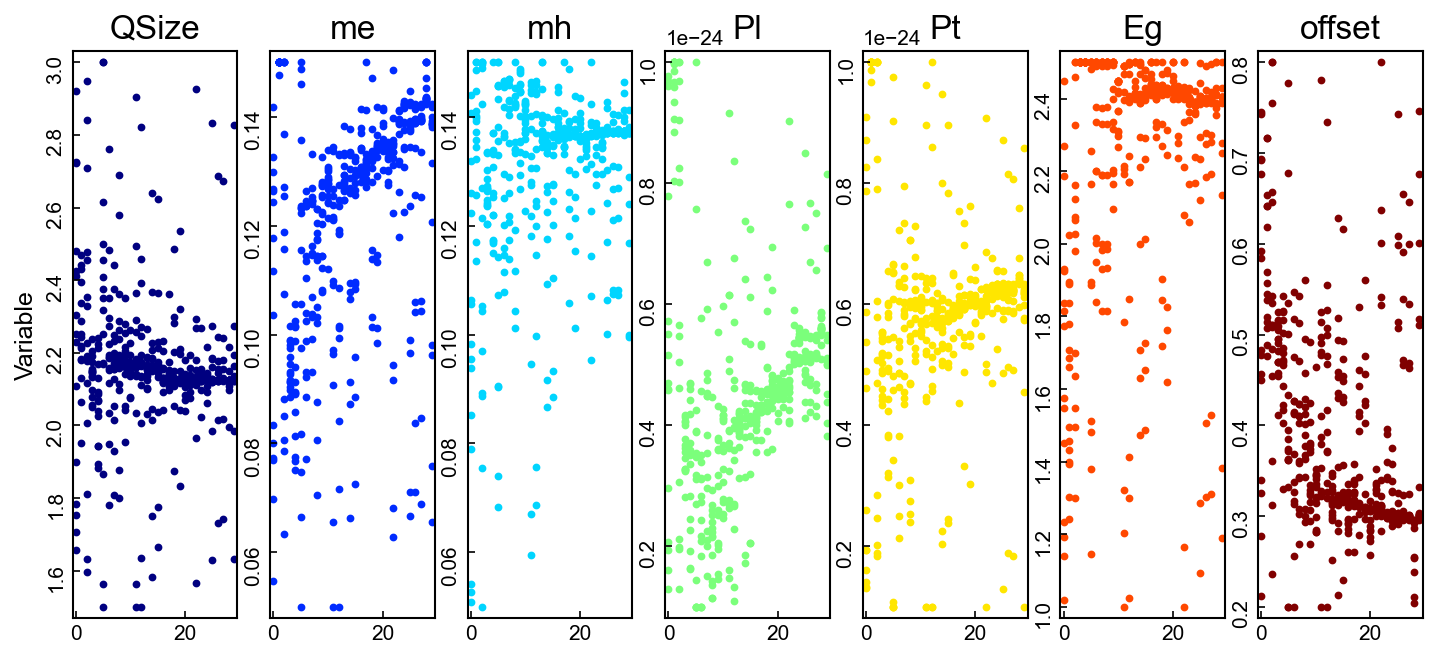

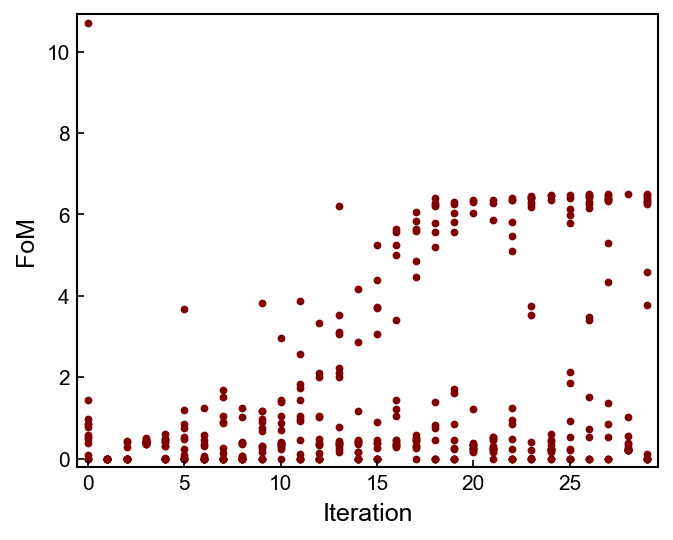

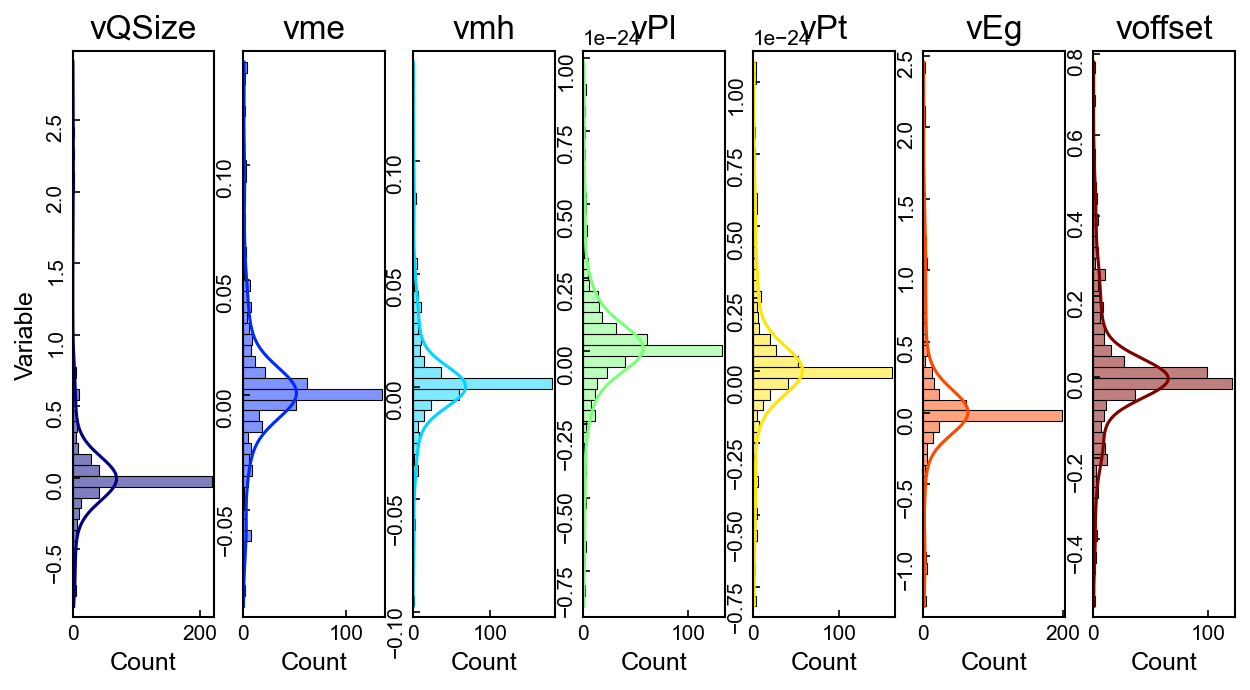

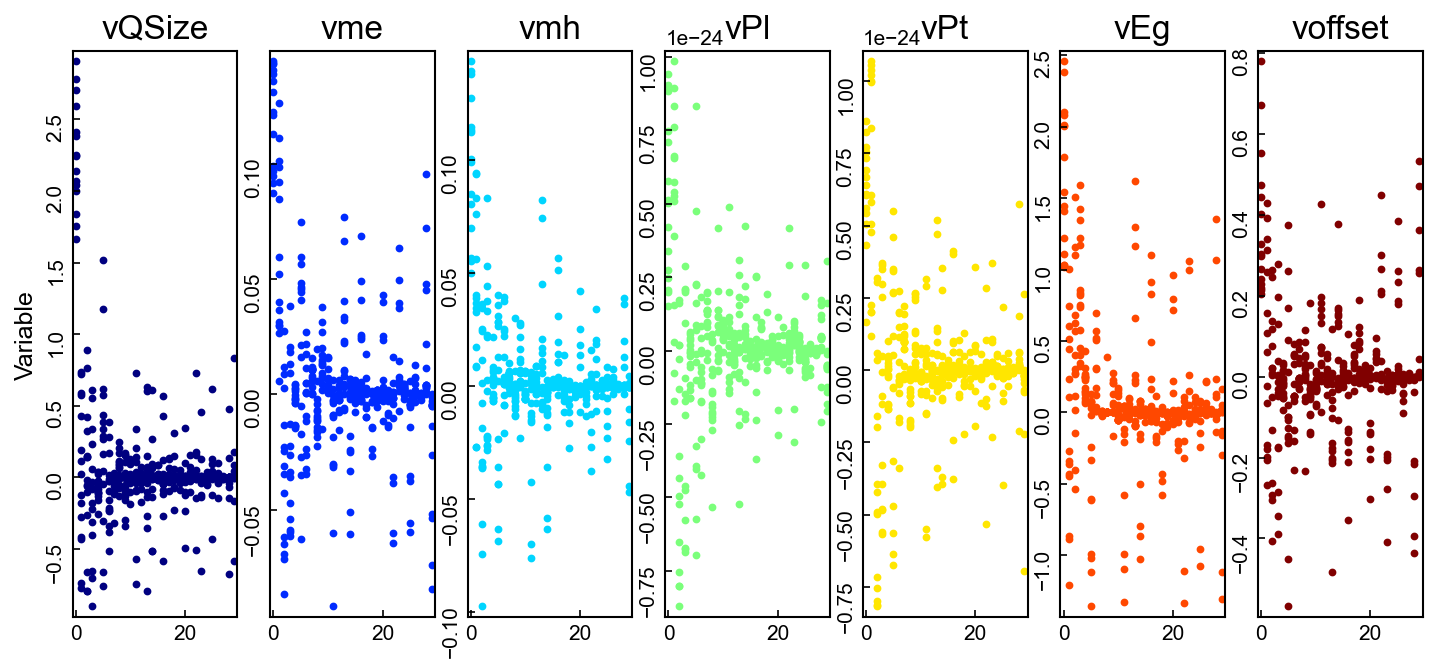

In [30]:
columns=["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
utils.pso_summary("PSO_Results", columns=columns, iterations=30, **{"figsize": (10, 5)})

### Utility functions for handling some of the optimization results

Plot the best absorption, given a specific optimization file (it_name)
```python
def pso_best_abs(it_name, energy=np.linspace(0.5, 4, 600), save=False, savename="PSO_Best_2.svg"):
    """ Plot the best optimization result """
    # Get all the parameters from the best optimization result
    columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
    data = pd.read_csv(it_name, sep=" ", names=columns)
    data.sort_values(by="FoM", ascending=False, ignore_index=True, inplace=True)
    # Unpack into the several variables
    qsize, me, mh, Pl, Pt, Eg, offset, *_ = tuple(data.loc[0])
    # Contruct the best qds and properties
    sim_setup = (25, 0.65, Eg, (Pl, Pt))
    qd1_prop = (qsize, (Eg - 0.4)*offset, me, me)
    qd2_prop = (qsize, (Eg - 0.4)*(1-offset), mh, mh)
    # Calculate the best properties
    trn = ab.all_avg_trn_elements(qd1_prop, qd2_prop, sim_setup)
    best_abs = ab.interband_absorption(energy, qd1_prop, qd2_prop, sim_setup)
    # Plot the best optimization absorption profile
    plt.figure(figsize=(10,8))
    plt.plot(energy, best_abs.iloc[:, 1:])
    plt.xlabel("Absorption Coefficient", fontsize=18)
    plt.ylabel("Energy (eV)", fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlim(0, 3)
    for index, (name, value) in enumerate(zip(columns, data.loc[0])):
        if index > 7:
            break
        plt.annotate(f"$\\bf{name}$={value:.3g}$\pm${value*0.05:.2f}", (0.02, 0.9-index/14), xycoords="axes fraction", fontsize=16)
    if save:
        plt.savefig(savename, transparent=True)
```

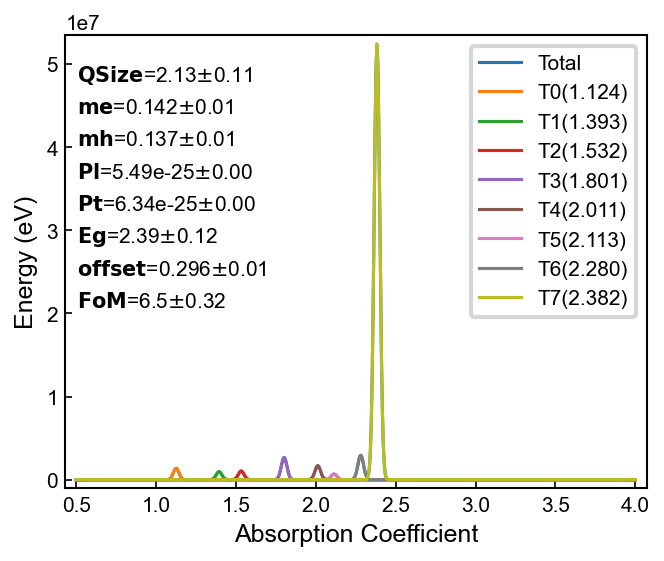

In [59]:
utils.pso_best_abs("PSO_Results/results_29")

Function that visualizes all the energy bands for a specific iteration of the optimization
```python
def pso_it_energy_profile(ax, it_name, save=False, savename="Band_diagrams.svg"):
    """
    Utility function to grab the data for all the particles in a iteration
    and then create a profile of the energy levels for each particle
    Args:
        ax: list with the axes (obtained from plt.subplots)
        it_name: name for the particular iteration
        save: wether to save the file
        savename: Name to save the file
    """
    # Columns for the optimization
    columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
    data = pd.read_csv(it_name, sep=" ", names=columns)
    ordered_data = data.apply(tuple, axis=1).values.reshape(ax.shape)
    # Normalized x to organize the standar information
    x = np.linspace(0, 1, 50)
    for i, line in enumerate(ordered_data):
        for j, column in enumerate(line):
            Vcb = (column[5] - 0.4)*column[6]
            Vvb = (column[5] - 0.4)*(1-column[6])
            qd_cb = qbd.qd_results(column[0], Vcb, column[1], column[1], band="CB1")
            qd_vb = qbd.qd_results(data_i[0], Vvb, column[2], column[2], band="VB1")
            # Define plot limits
            ax[i, j].set_ylim(0, column[5])
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(False)
            # Create the band diagram from Eg, Vcb, Vvb
            # Left/Righ sides of the bands
            ax[i, j].axhline(0, xmin=0, xmax=0.25, color="k")
            ax[i, j].axhline(column[5], xmin=0, xmax=0.25, color="k")
            ax[i, j].axhline(0, xmin=0.65, xmax=1, color="k")
            ax[i, j].axhline(column[5], xmin=0.65, xmax=1, color="k")
            # Mid Line
            ax[i, j].axhline(Vvb, xmin=0.25, xmax=0.65, color="k")
            ax[i, j].axhline(Vvb+0.4, xmin=0.25, xmax=0.65, color="k")
            # Add vertical bariers
            ax[i, j].axvline(0.25, ymin=0, ymax=Vvb/column[5], color="k")
            ax[i, j].axvline(0.65, ymin=0, ymax=Vvb/column[5], color="k")
            ax[i, j].axvline(0.25, ymin=(Vvb+0.4)/column[5], ymax=1, color="k")
            ax[i, j].axvline(0.65, ymin=(Vvb+0.4)/column[5], ymax=1, color="k")
            ax[i, j].set_xticks(ticks=[])
            ax[i, j].tick_params(axis="y", labelsize=16)
            # Plot the energy spectrum (from -0.25 to 0.25)
            for e_cb in qd_cb.e_levels.values.flatten():
                ax[i, j].axhline(column[5] + e_cb, xmin=0.25, xmax=0.65)
            for e_vb in qd_vb.e_levels.values.flatten():
                ax[i, j].axhline(-e_vb, xmin=0.25, xmax=0.65)
    if save:
        plt.savefig(savename, transparent=True)
```

Function to facilitate the visualization of the absorption profiles for a particular optimization iteration
```python
def pso_it_abs_preview(ax, it_name, energy=np.linspace(0.4, 3, 600), save=False):
    """ Import data from a particular PSO optimization and plot the absorption for all particles """
    columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
    data = pd.read_csv(it_name, sep=" ", names=columns)
    results = []
    # Import the data all the info to a list of Dataframes with the severall absorptions
    for data_i in data.apply(tuple, axis=1):
        Vcb = (data_i[5] - 0.4)*data_i[6]
        Vvb = (data_i[5] - 0.4)*(1-data_i[6])
        qd_cb = (data_i[0], Vcb, data_i[1], data_i[1])
        qd_vb = (data_i[0], Vvb, data_i[2], data_i[2])
        sim_properties = (15, 0.65, data_i[5], (data_i[3], data_i[4]))
        results.append(ab.interband_absorption(energy, qd_cb, qd_vb, sim_properties))
    # Create the array with the flat indexes
    flat_index = np.arange(0, np.prod(ax.shape)).reshape(ax.shape)
    for i in range(ax.shape[0]):
        for k in range(ax.shape[1]):
            ax[i, k].plot(results[0]["Energy"], results[flat_index[i, k]]["Total"])
            ax[i, k].set_title(f"FoM={data['FoM'][flat_index[i, k]]:.2f}", fontsize=18)
            ax[i, k].tick_params(labelsize=14)
            if k == 0:
                ax[i, k].set_ylabel("Absorption Coef (nm$^3$/cm)", fontsize=16)
            if i == 2:
                ax[i, k].set_xlabel("Energy (eV)", fontsize=16)
    if save:
        plt.savefig("Absorption_Coefs.svg", transparent=True)
 ```

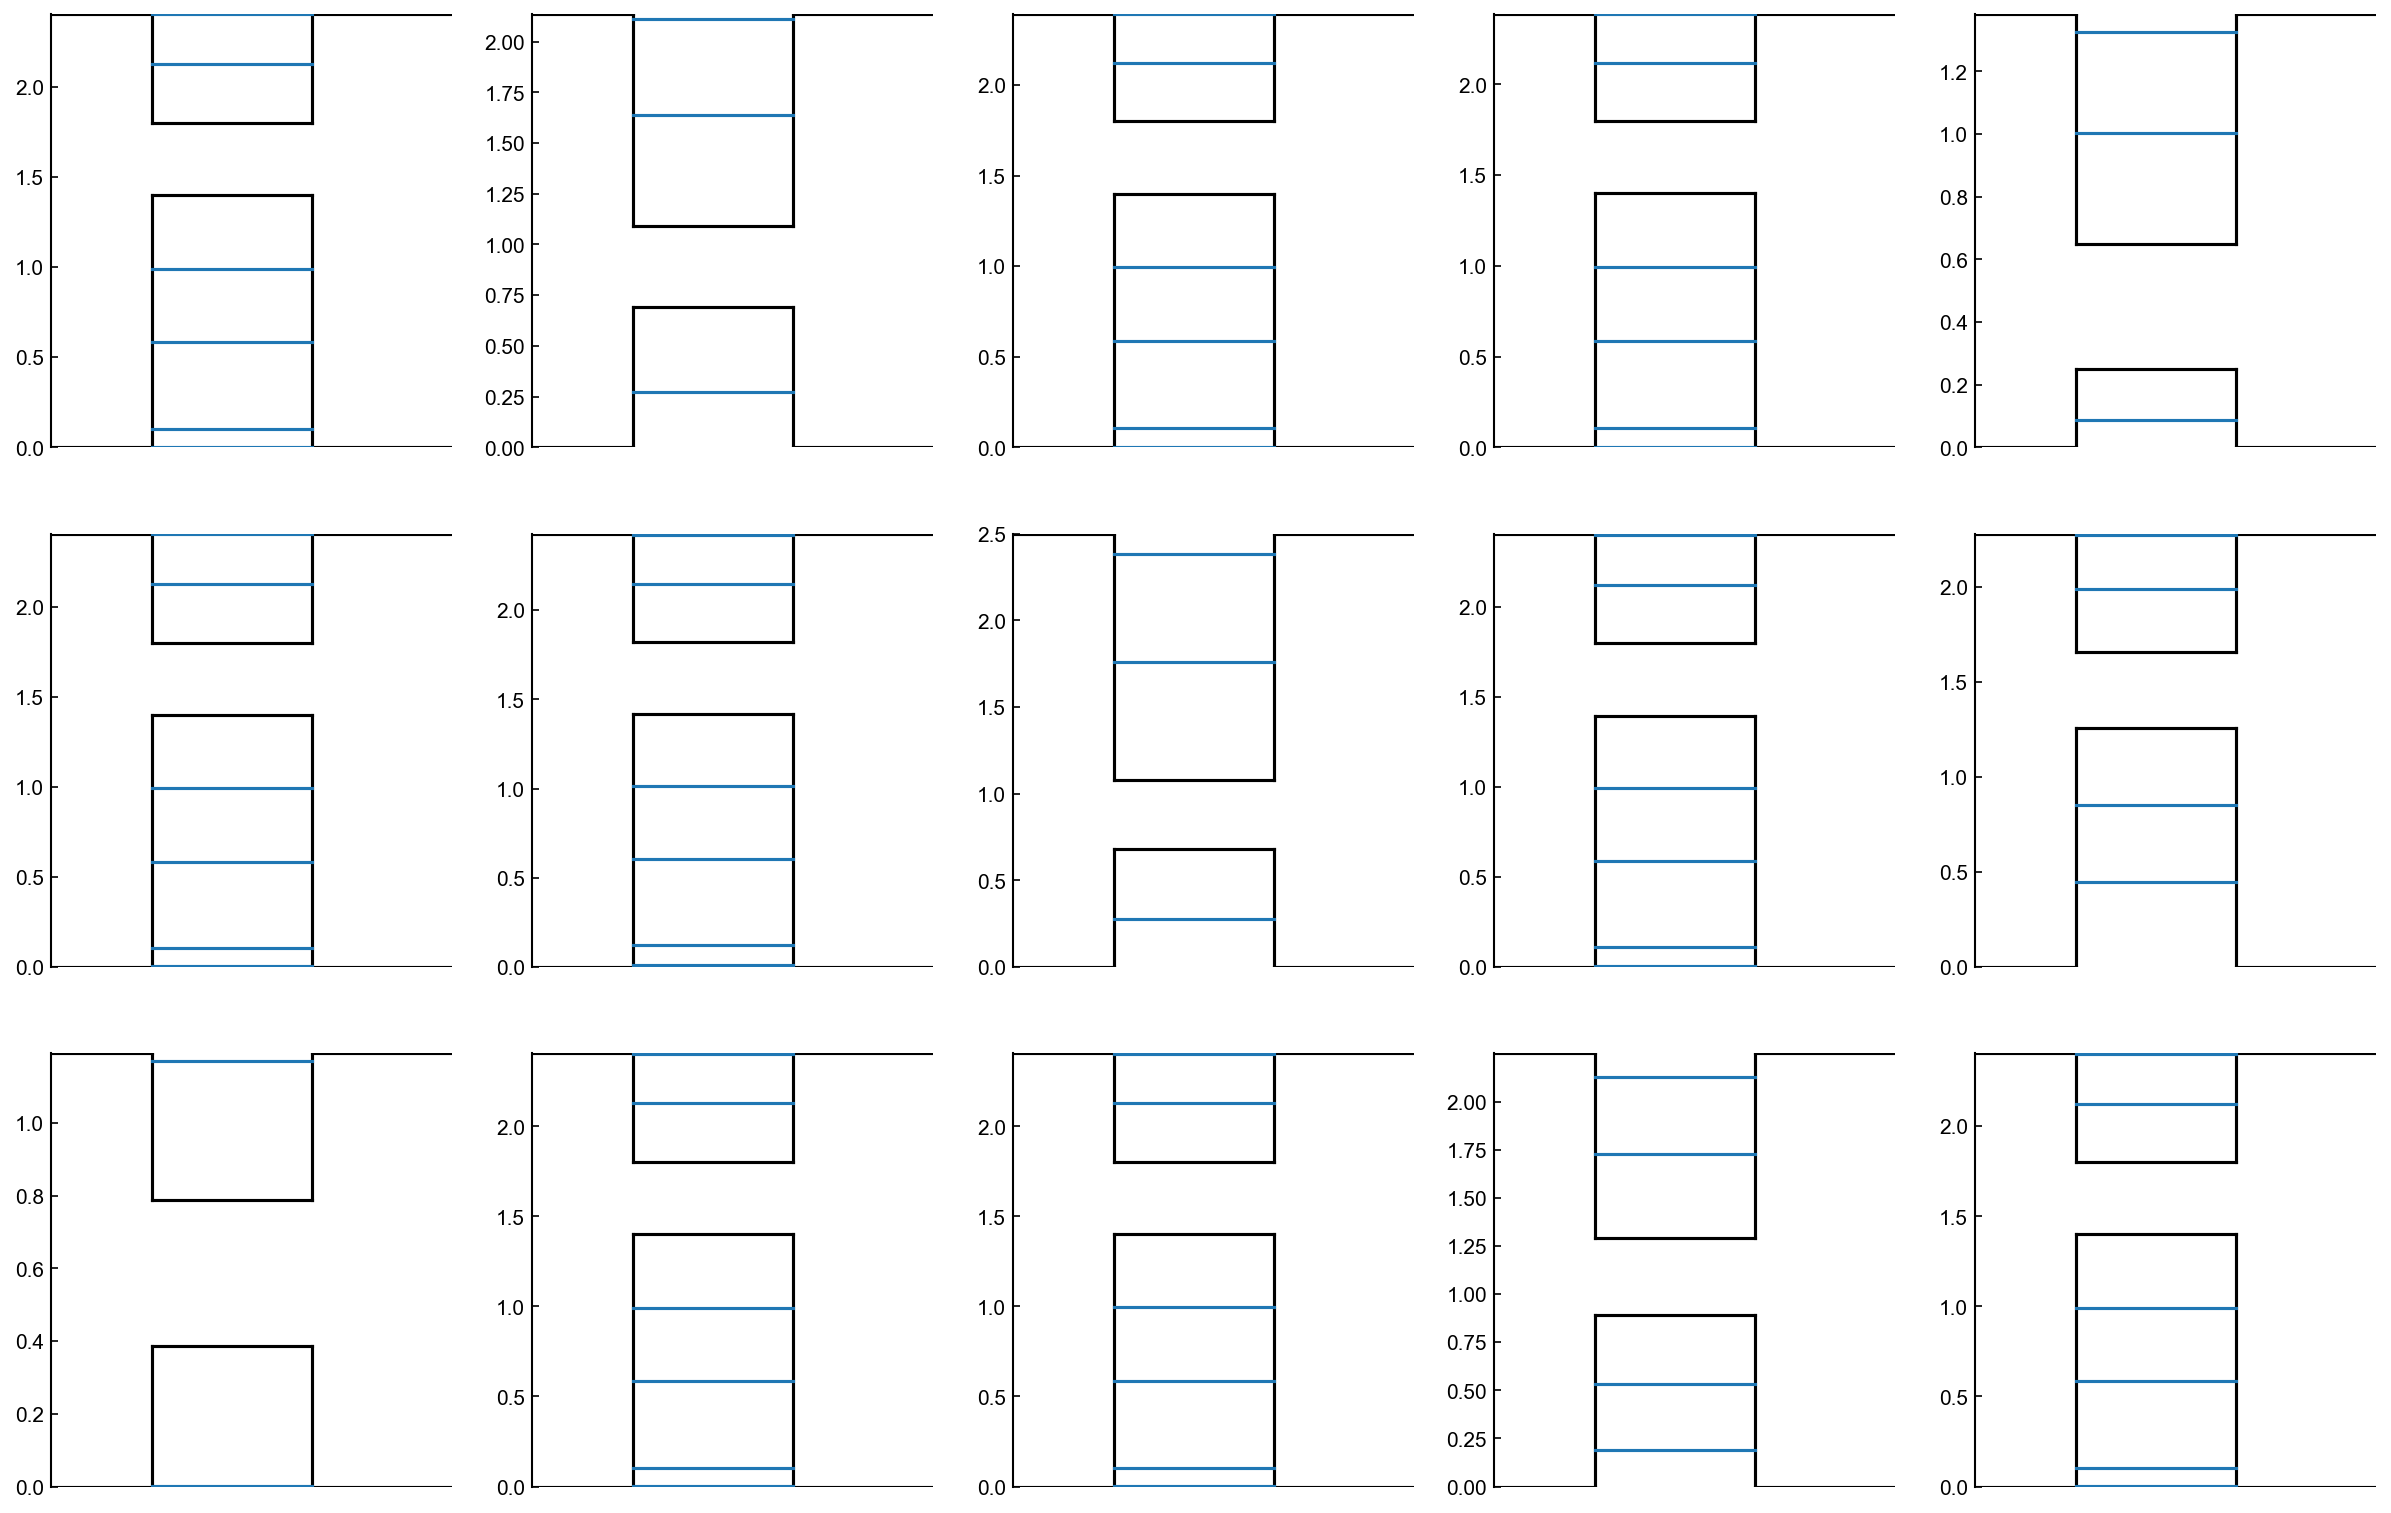

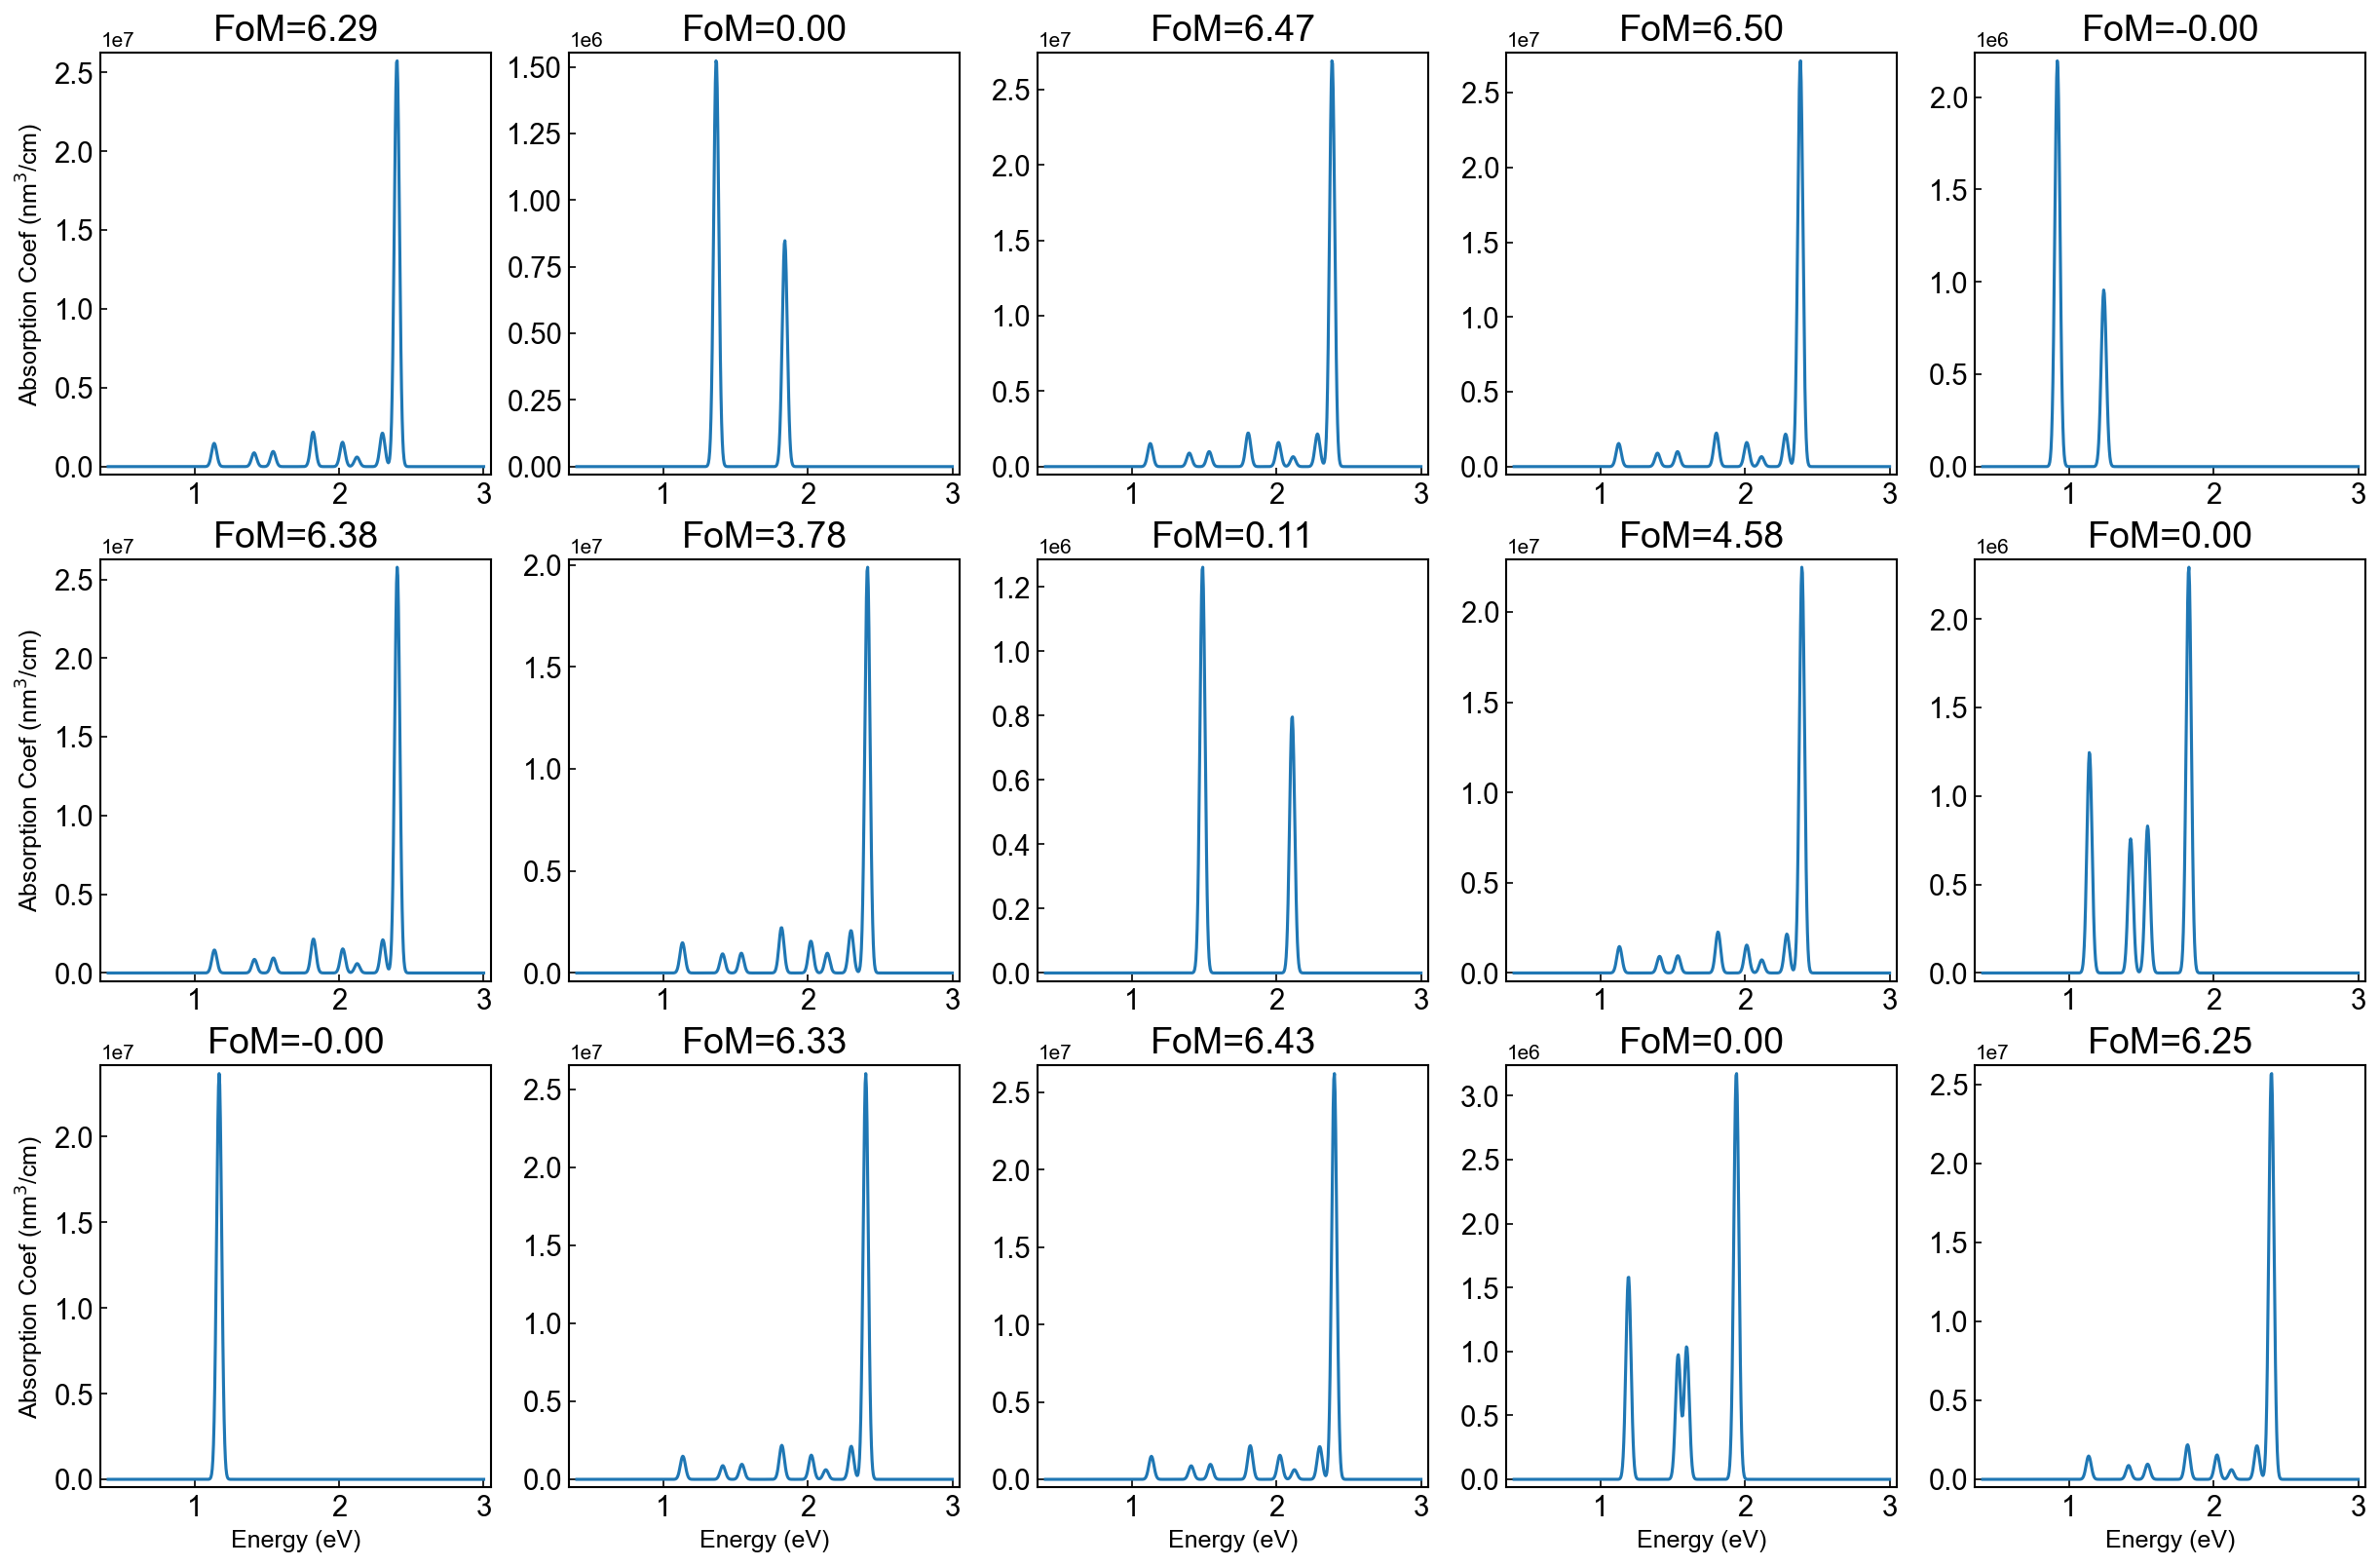

In [61]:
# Run to see the optimization results
fig, ax = plt.subplots(3, 5, figsize=(20,13))
utils.pso_it_energy_profile(ax, "PSO_Results/results_29")
fig, ax = plt.subplots(3, 5, figsize=(20,13))
utils.pso_it_abs_preview(ax, "PSO_Results/results_29")

### Running Monte Carlo Analysis around the best values

Monte Carlo analysis od the best set of parameters
It will calculate n_rnd values around the values provided
using a tol of tol
```python
def mc_random(qd_size,
              me,
              mh,
              Pl,
              Pt,
              Eg,
              offset,
              tol=0.1,
              n_rnd=500,
              **kwargs):
    """ Calculate n_rnd simulations tol% around the given values
    Args: Basically the optimization variables
    """
    logging.info(f"Random MC...{tol=} {n_rnd=}")
    me_rnd = np.random.uniform((1 - tol) * me, (1 + tol) * me, size=(n_rnd))
    mh_rnd = np.random.uniform((1 - tol) * mh, (1 + tol) * mh, size=(n_rnd))
    qd_size_rnd = np.random.uniform((1 - tol) * qd_size, (1 + tol) * qd_size,
                                    size=(n_rnd))
    Pl_rnd = np.random.uniform((1 - tol) * Pl, (1 + tol) * Pl, size=(n_rnd))
    Pt_rnd = np.random.uniform((1 - tol) * Pt, (1 + tol) * Pt, size=(n_rnd))
    Eg_rnd = np.random.uniform((1 - tol) * Eg, (1 + tol) * Eg, size=(n_rnd))
    offset_rnd = np.random.uniform((1 - tol) * offset, (1 + tol) * offset,
                                   size=(n_rnd))

    # Run all the random iterations
    mc_res = opt_function(qd_size_rnd, me_rnd, mh_rnd, Pl_rnd, Pt_rnd, Eg_rnd,
                          offset_rnd, **kwargs)
    return mc_res
```

Monte Carlo simulation for each of the optimization parameters
It changes each of the best parameters individualy, maintaining the rest constant
```python
def mc_pso_best_param(best_it, n_rnd=1000, tol=0.05, save=False, savename="best_particles.txt", **const_args):
    """ Take the best result of the optimization and do a mc analysis around
    the maximum value for each parameter """
    # Import the respective data from the given iteration
    columns = ["qd_size", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
    data = pd.read_csv(best_it, sep=" ", names=columns)
    data.sort_values(by="FoM", ascending=False, ignore_index=True, inplace=True)
    # Create a dictionary with the list of best parameters
    best_res = data.loc[0][:7].to_dict()
    best_res_array = {key: value*np.ones(n_rnd) for key, value in best_res.items()}
    # Copy the best dictionary and change each parameter for the random sweep at a time
    results = []
    for key in best_res_array.keys():
        logging.info(f"Running... {key=}")
        sim_array = best_res_array.copy()
        sim_array[key] = np.random.uniform((1-tol)*best_res[key], (1+tol)*best_res[key], size=(n_rnd))
        sim_array.update(const_args)
        results.append(ab.opt_function(**sim_array))
    if save:
        np.savetxt(savename, np.array(results), comments=" ".join(list(best_res_array.keys())))
```

In [ ]:
columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
data = pd.read_csv("results_29", sep=" ", names=columns)
data.sort_values(by="FoM", ascending=False, ignore_index=True, inplace=True)
# Test different dispersions around the maximum value
# The ideia is to try and determine how much the maximum realy
# depends on each value...
const_args = {
    "energy": np.linspace(0.5, 4, 400),
    "lat_size": 0.65,
    "sim_size": 15
}
best_res = data.loc[0][:7].to_dict()
# Change only QSize to qd_size
best_res["qd_size"] = best_res["QSize"]
best_res.pop("QSize")

# Call severall versions of the random variation around the maximum
print("Random 0.1%")
best_res.update({"tol": 0.001, "n_rnd": 1000})
rnd_01 = utils.mc_random(**best_res, **const_args)
print("Random 0.5%")
best_res.update({"tol": 0.005, "n_rnd": 1000})
rnd_05 = utils.mc_random(**best_res, **const_args)
print("Random 1%")
best_res.update({"tol": 0.01, "n_rnd": 1000})
rnd_1 = utils.mc_random(**best_res, **const_args)
print("Random 5%")
best_res.update({"tol": 0.05, "n_rnd": 1000})
rnd_5 = utilsa.mc_random(**best_res, **const_args)
np.savetxt("Random_calculations.csv", np.c_[rnd_01, rnd_05, rnd_1, rnd_5], header="# Rnd_0.1 Rnd_0.5 Rnd_1 Rnd_5")

In [ ]:
## Preview results of individual iterations
fig, ax = plt.subplots(1, 7, figsize=(15, 10))
colors = ["red", "green", "blue", "purple", "yellow", "brown", "rosybrown"]
columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
for index, rnd_i in enumerate(results):
    chart = sns.histplot(y=rnd_i,color=colors[index], kde=True, bins=150, ax=ax[index])
    ax[index].tick_params(axis="y", rotation=90, labelsize=12, pad=1)
    ax[index].set_ylabel("")
    ax[index].set_xlabel("Count", fontsize=18)
    ax[index].set_title(columns[index], fontsize=18)
npres = np.column_stack(tuple(results))
np.savetxt("Param_Dist_1000.csv", npres, header=" ".join(columns[:7]))
plt.savefig("Param_Dist_1000.svg", transparent=True)

### Solving the big peak problem

Essentialy as the transition energy tends to the BG there seems to be a significant increase of the transition rate.\
This is particularly noticeable, when the transition energy ~ BG where a massive spike appears, that essentialy dwarves the remaining peaks, and that creates a very complicated simulation setup, since the particles will simply tend to this strange points

The objective here is to try and determine the reason for such peak. I will try to do several different studies:
- Monte Carlo analysis around the maximum value (several cases have already been tried - 0.1, 0.5%+ without too much luck)
- A scoped Monte Carlo with a very small tolerance around the maximum value (<0.01%)
- Try and determine how the energies are being calculated - to see if there is a strange behaviour near the 0 value
- Try and zoom in the actual value calculation to determine the source of the spike, computation-wise

So the process will be to make severall optimizations first... Check the results and then do the monte carlo around the maximum value

In [2]:
# Perform single optimization
param_dict = {
    "qd_size": [1.5, 3],
    "me": [0.05, 0.15],
    "mh": [0.05, 0.15],
    "Pl": [1e-25, 1e-24],
    "Pt": [1e-25, 1e-24],
    "Eg": [1, 2.5],
    "offset": [0.2, 0.8]
}
const_args = {
    "energy": np.linspace(0.5, 4, 600),
    "lat_size": 0.65,
    "sim_size": 25
}
res = particle_swarm(ab.opt_function, param_dict,
                     n_particles=15, n_iter=30,
                     export=True, swarm_properties=(0.3, 1.5, 1.5),
                     **const_args)

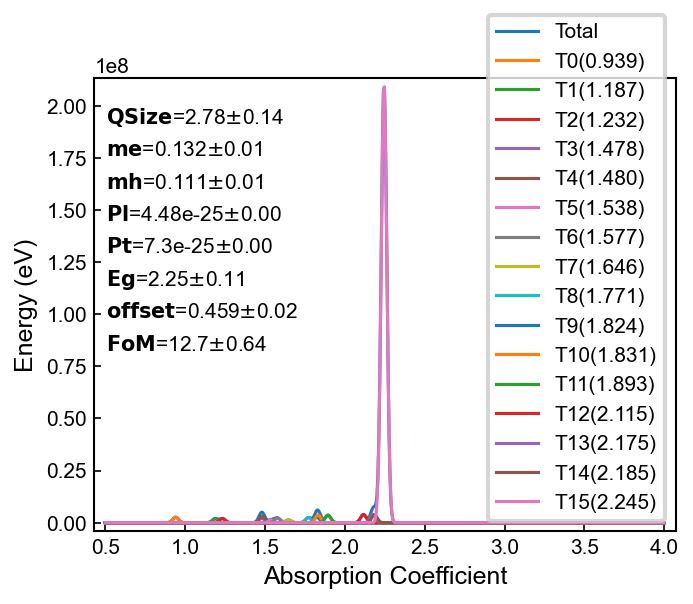

In [3]:
# Plot the best optimization result
utils.pso_best_abs("PSO_Results/results_29", save=True)

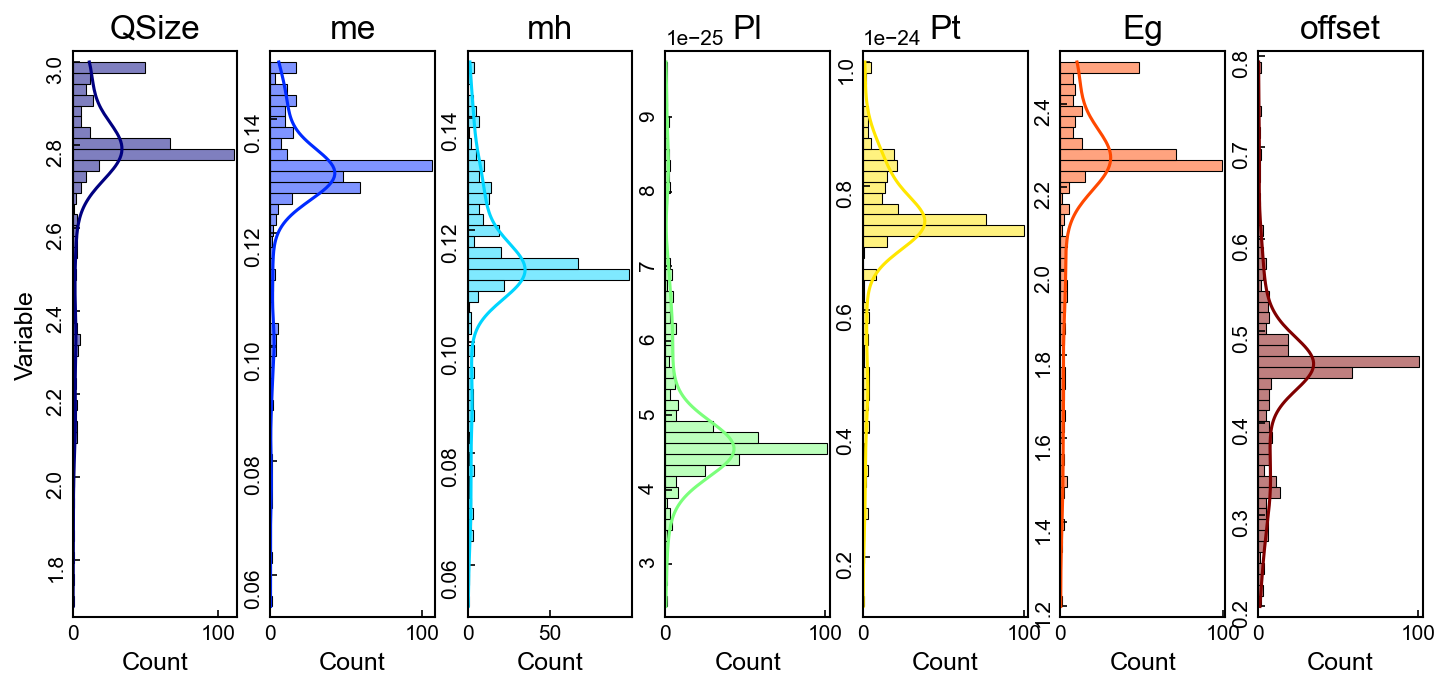

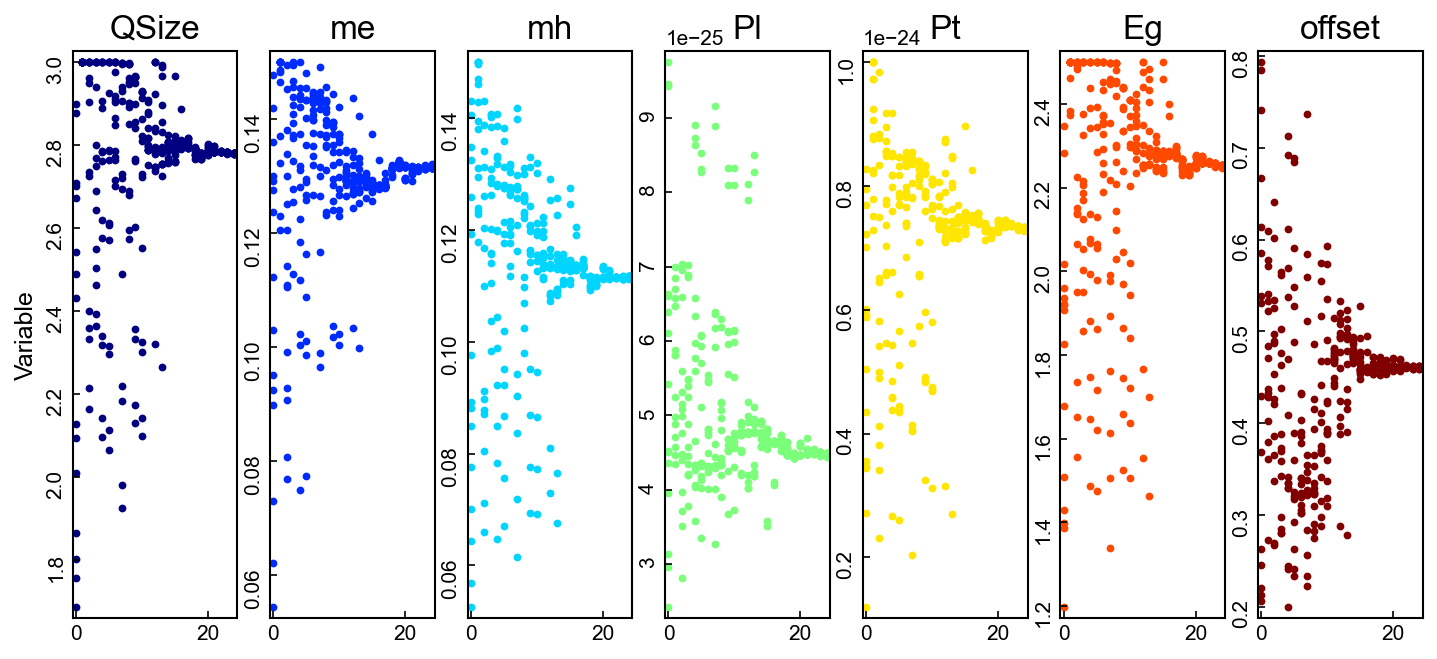

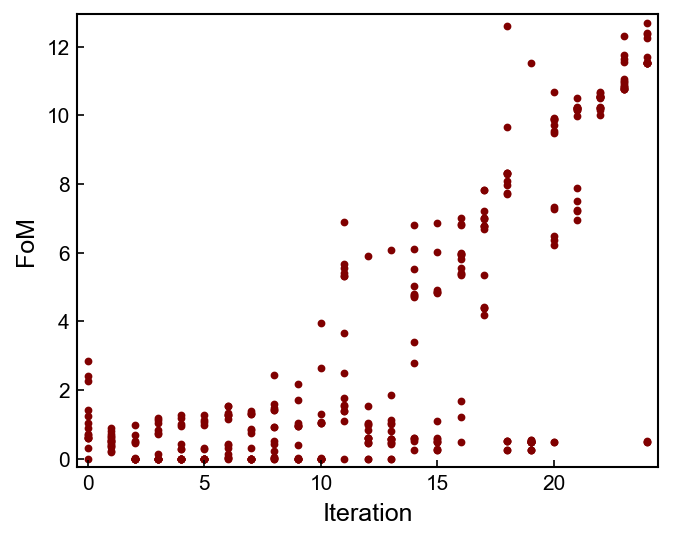

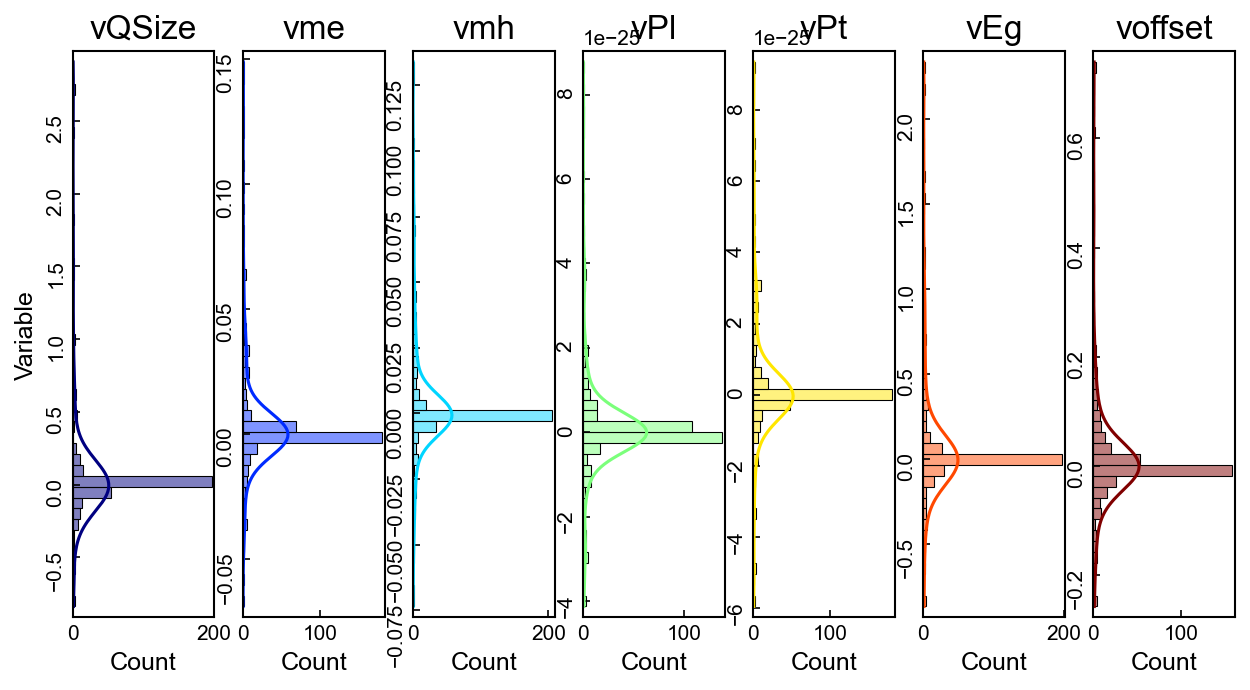

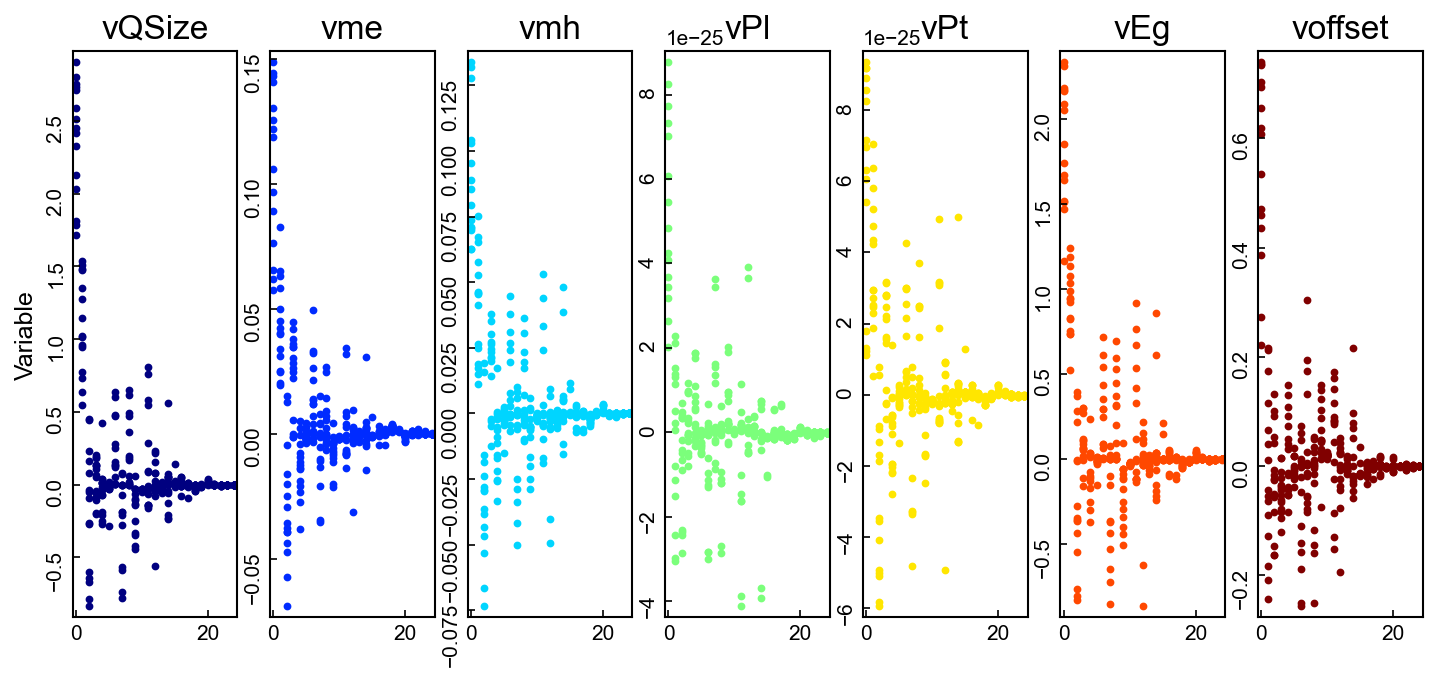

In [4]:
columns=["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
utils.pso_summary("PSO_Results", columns=columns, iterations=25, export=True, **{"figsize": (10, 5)})

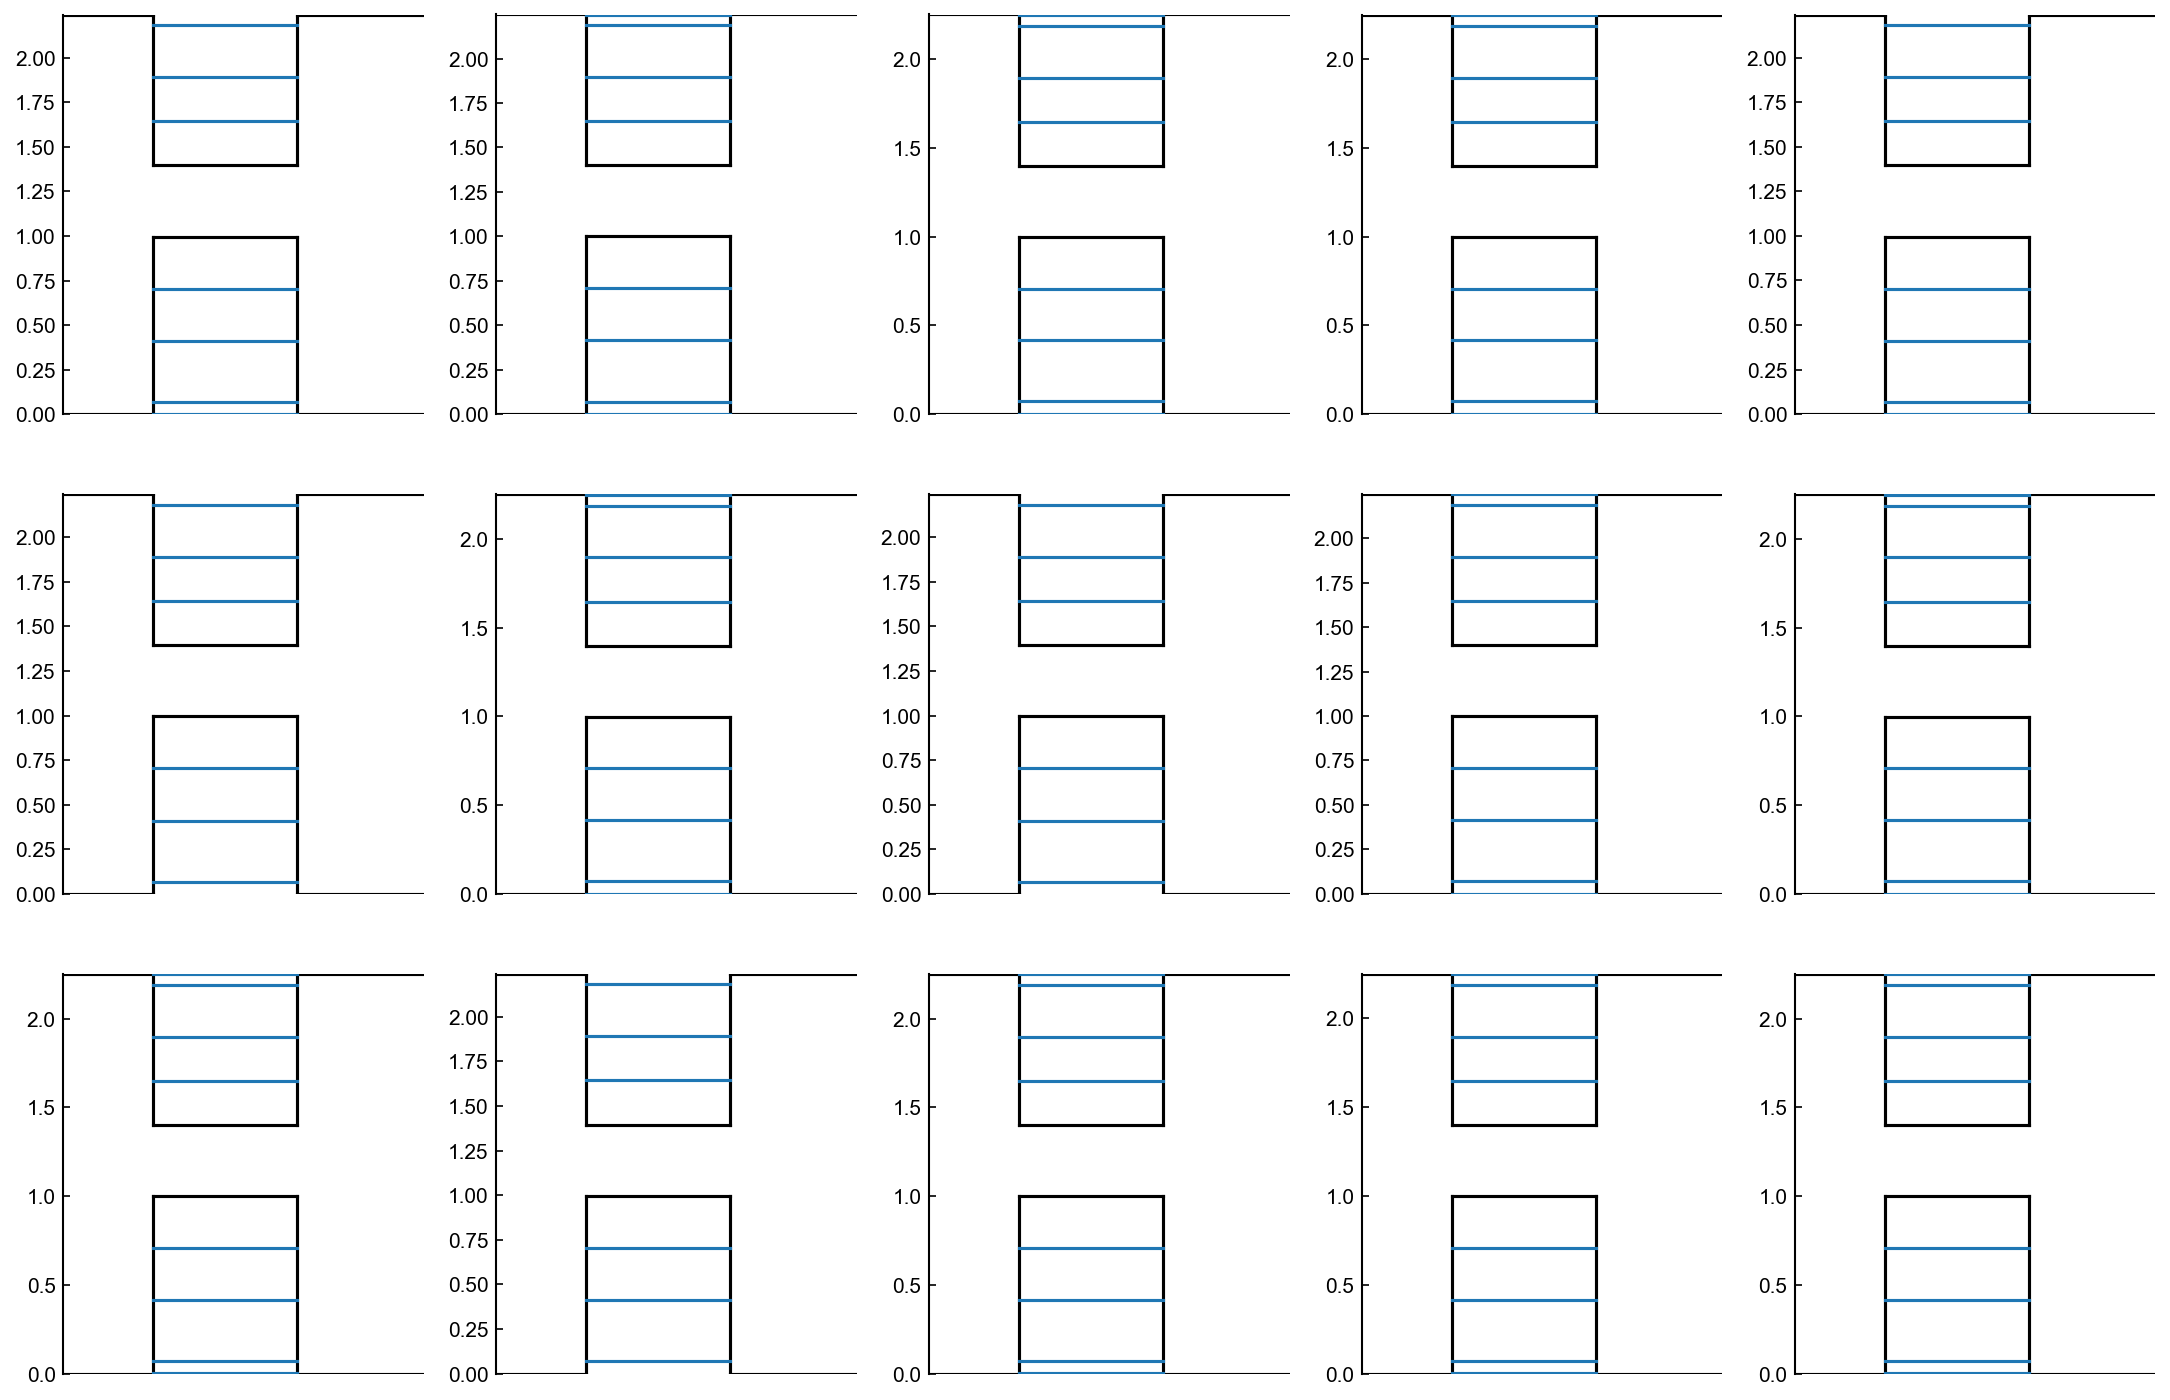

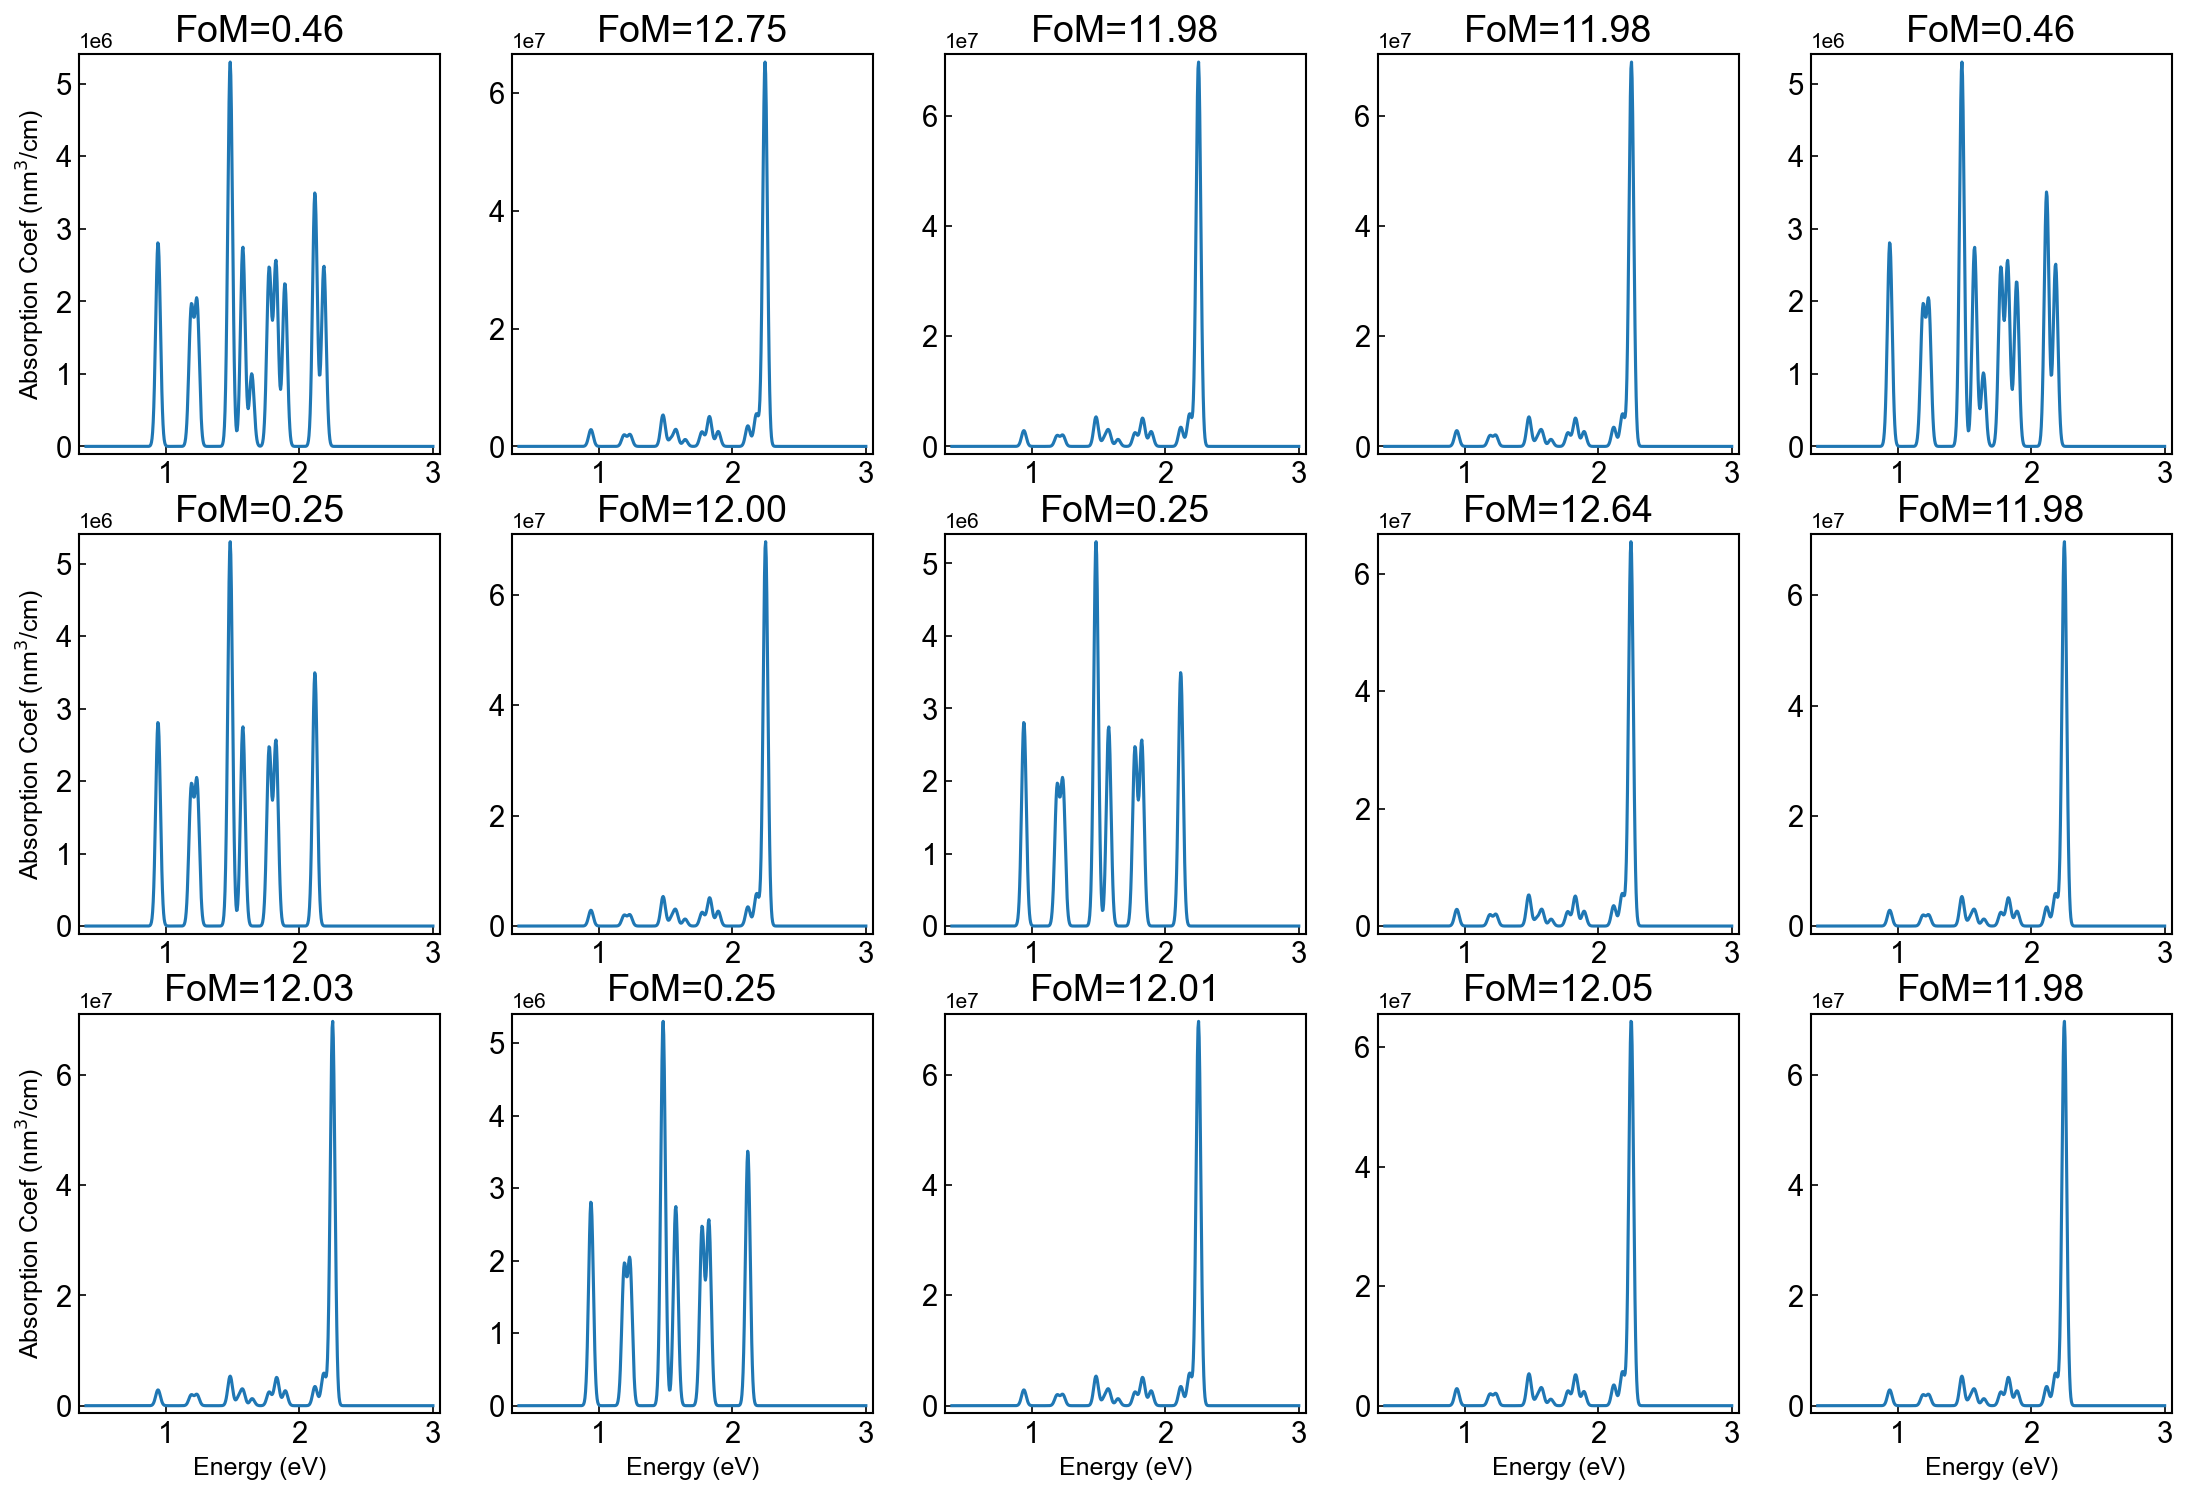

In [5]:
# Check to see the configuration for the best results
fig, ax = plt.subplots(3, 5, figsize=(18,12))
utils.pso_it_energy_profile(ax, "PSO_Results/results_29", save=True)
fig, ax = plt.subplots(3, 5, figsize=(18,12))
utils.pso_it_abs_preview(ax, "PSO_Results/results_29", save=True)

In [6]:
# Make the Monte Carlo analysis
columns = ["qd_size", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
data = pd.read_csv("PSO_Results/results_29", sep=" ", names=columns)
data.sort_values(by="FoM", ascending=False, ignore_index=True, inplace=True)
# Create a dictionary with the list of best parameters
best_res = data.loc[0][:7].to_dict()
mc_rnd = utils.mc_random(**best_res, tol=0.005, n_rnd=1000)

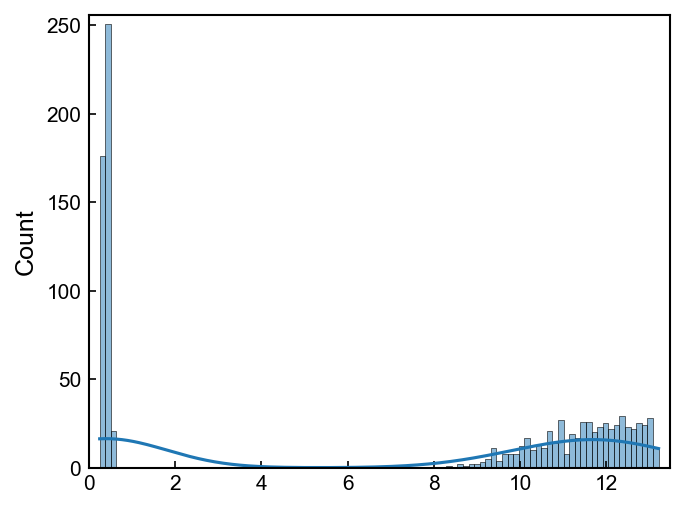

In [44]:
save = True
sns.histplot(mc_rnd, bins=100, kde=True)
if save:
    plt.savefig("Mc_rnd.svg", transparent=True)

In [9]:
res = utils.mc_pso_best_param("PSO_Results/results_29", n_rnd=1000, tol=0.005, save=True)

In [11]:
mc_part_res = np.loadtxt("best_particles.txt").T

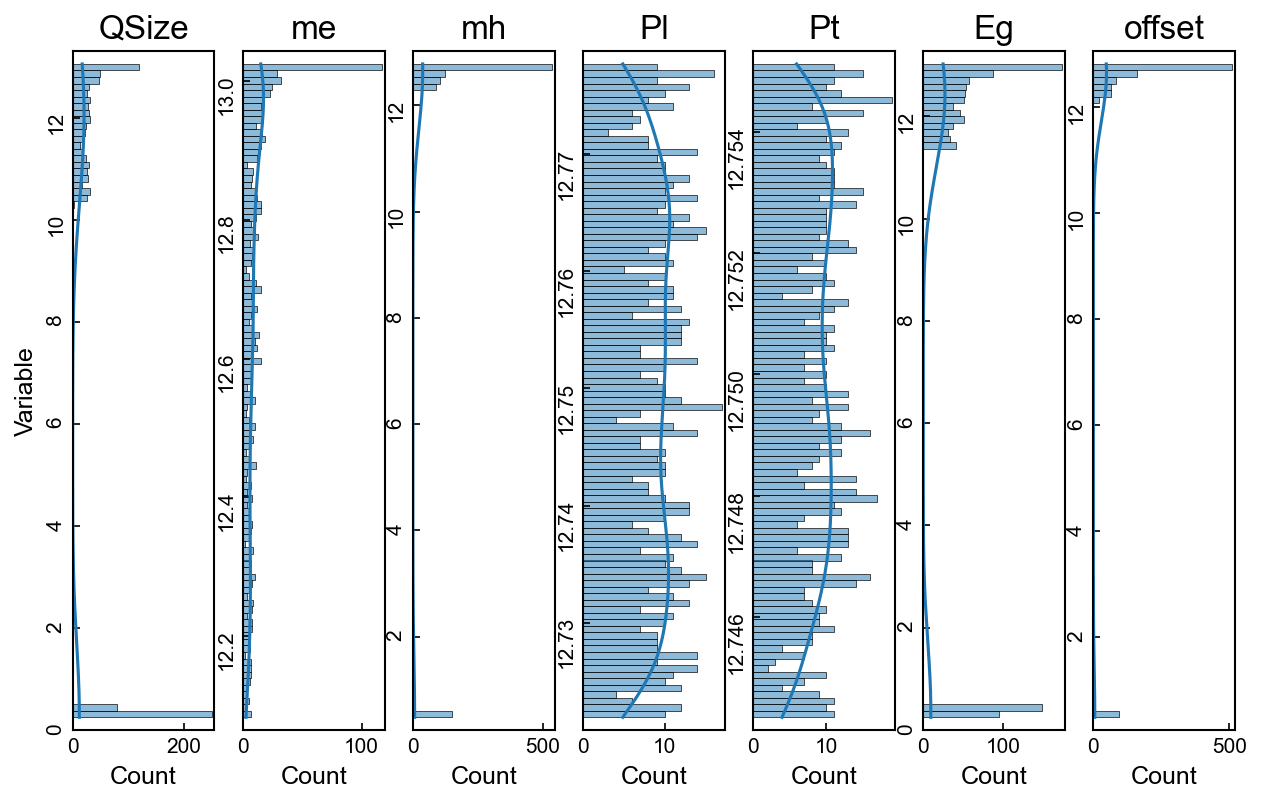

In [23]:
cols = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset"]
fig, ax = plt.subplots(1, 7, figsize=(10,6))
for i in range(7):
    sns.histplot(y=mc_part_res[:, i], bins=100, kde=True, ax=ax[i])
    if i == 0:
        ax[i].set_ylabel("Variable")
    else:
        ax[i].set_ylabel("")
    ax[i].set_title(cols[i])
    ax[i].tick_params(axis="y", rotation=90)
plt.savefig(f"Particle_MC_005.svg", transparent=True)

Cheking the way the values are actually calculated.

- Essentially see where the values are being calculated
- The ~ BG values essentialy are created from energy levels that are too close to VB/CB, which could easily be appearing from errors in the calculations

Solution: Create a cutoff energy for the energy levels (0.05 eV) - anything bellow this values is not considered

In [25]:
columns = [
    "QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize",
    "vme", "vmh", "vPl", "vPt", "vEg", "voffset"
]
data = pd.read_csv("PSO_Results/results_29", sep=" ", names=columns)
data.sort_values(by="FoM",
                 ascending=False,
                 ignore_index=True,
                 inplace=True)
# Unpack into the several variables
qsize, me, mh, Pl, Pt, Eg, offset, *_ = tuple(data.loc[0])

In [37]:
V0 = (Eg-0.4)*(1-offset)
e_geom = -(V0 + 0.001) + np.geomspace(0.001, V0, 10000, endpoint=True)
qbd.spherical_bound_states(e_geom, mh, mh, qsize, V0, 2, True)

array([            nan,  2.09063285e+03,  1.47804465e+03, ...,
       -2.89142050e-01, -2.92402977e-01, -2.95677668e-01])

(this analysis was not used)
Try and determine the envolutes for the best results to see if there is anything out of the ordinary

On a first analysis, the envolutes did not seem to be out of the ordinary...
So a more complete analysis may be needed to check how both envolutes for a specific transition can
be coupled together to give the massive value they are giving

In [ ]:
# Preview the envolutes for the strange case in quesion
# May need to reimport data as it was using a old results that was lost in the meanwhile
vtk = False
sim_size = 15
lat_size = 0.65
l = 0
n = 0
m = 0
center = int(sim_size/lat_size/2)
qsize, me, mh, Pl, Pt, Eg, offset, *_ = tuple(data.loc[0])
P = (Pl, Pt)
band = "CB1"
# Calculate the envolutes for the CB
qd_wavefunction = qbd.qd_results(qsize, (Eg - 0.4)*offset, me, me, band)
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

# Plot a slice of the data
fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cmb.jet, levels=50)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cmb.jet, levels=50)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cmb.jet, levels=50)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cmb.jet, levels=50)
ax[1, 1].set_title("L6pb envolute")
plt.show()

# Export to vtk file for visualization in paraview
if vtk:
    x = np.arange(-sim_size, sim_size, lat_size)
    gridToVTK(f"band_{band}_envolute_S_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_S)**2})
    gridToVTK(f"band_{band}_envolute_Y_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_Y)**2})
    gridToVTK(f"band_{band}_envolute_X_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_X)**2})
    gridToVTK(f"band_{band}_envolute_Z_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_Z)**2})savefig

### Testing the solution to the big peak problem

In [45]:
a = pd.DataFrame({"a": [1, 2, 3], "b": [1, 2, 3]})

In [49]:
a[a == 1] = np.nan

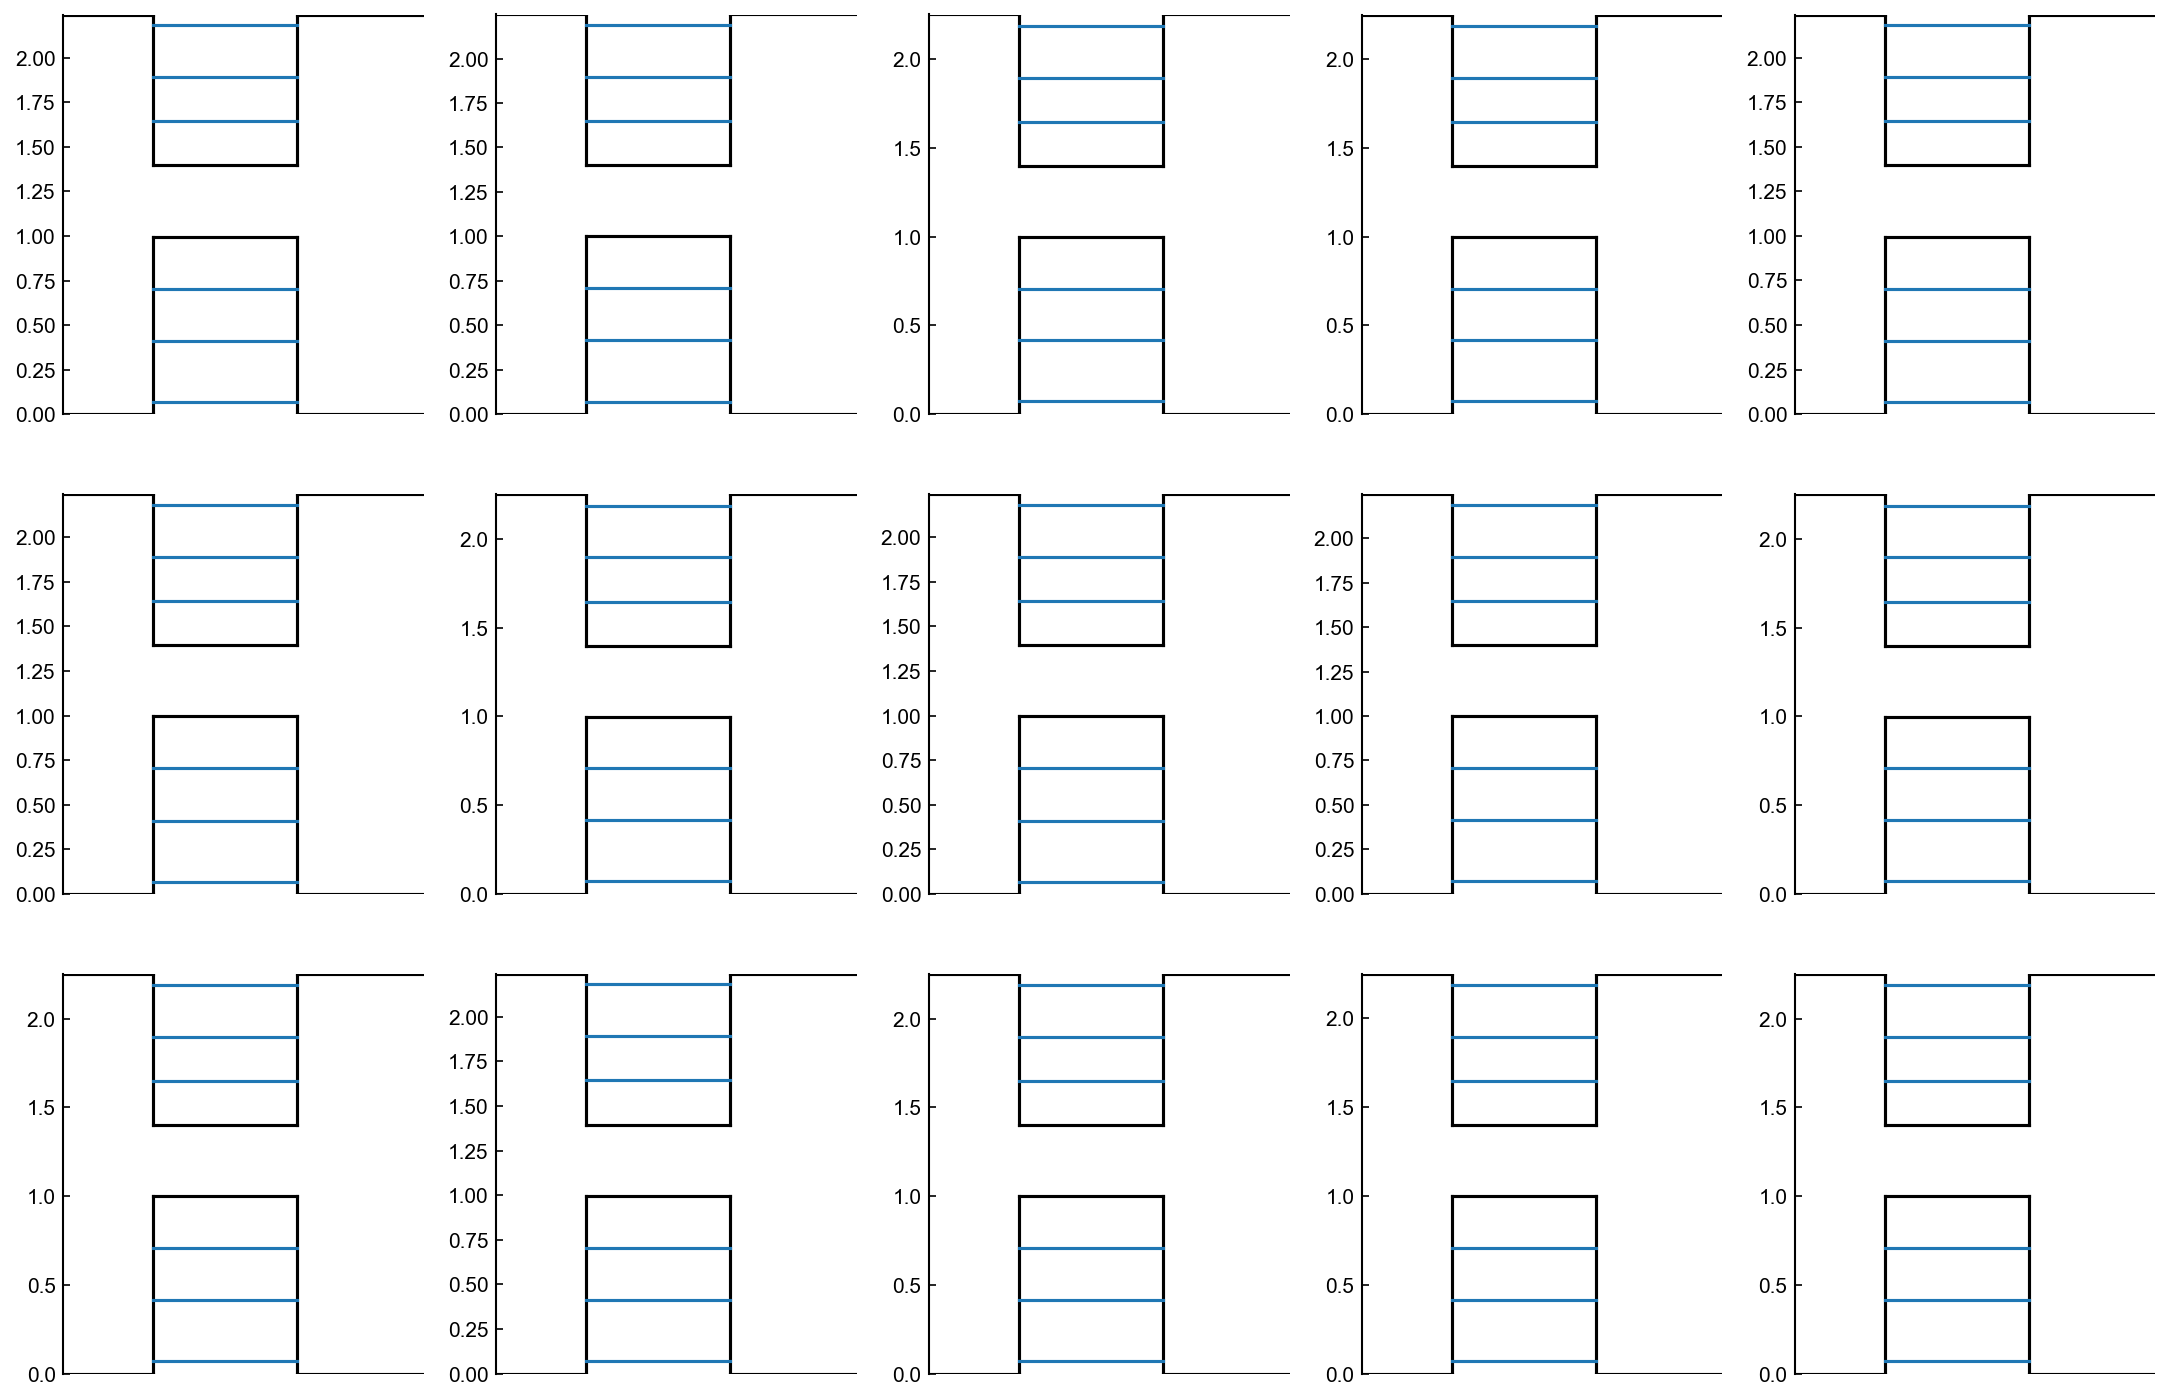

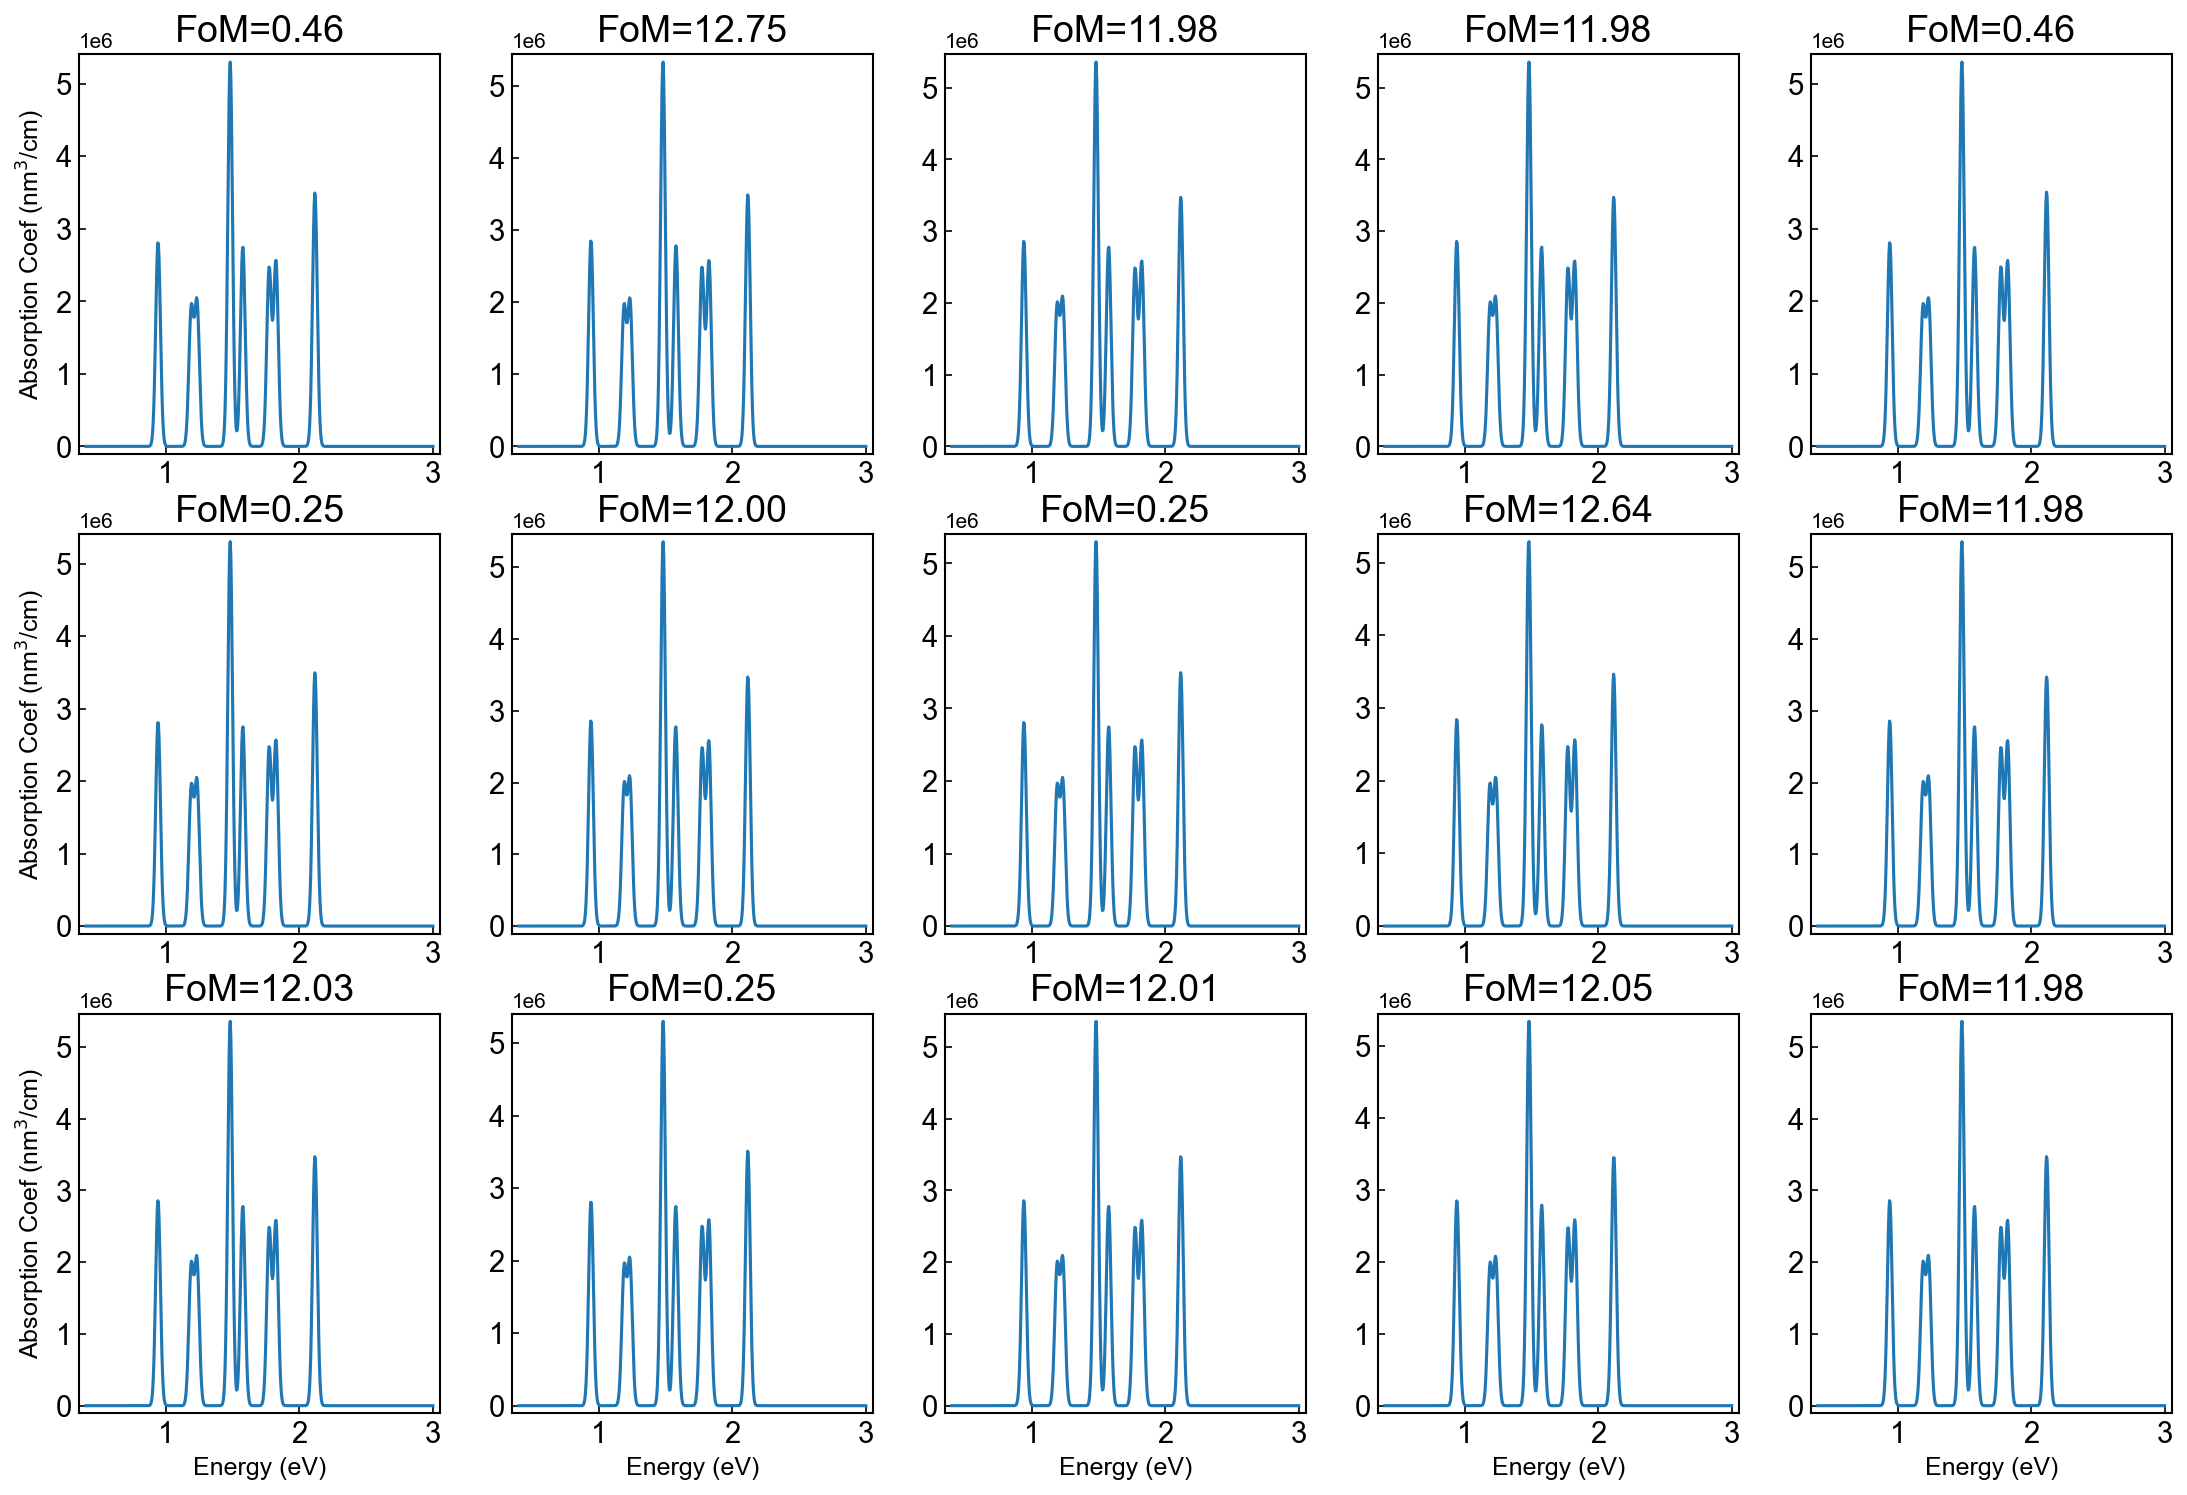

In [53]:
# Check to see the configuration for the best results
fig, ax = plt.subplots(3, 5, figsize=(18,12))
utils.pso_it_energy_profile(ax, "PSO_Results/results_29", save=True)
fig, ax = plt.subplots(3, 5, figsize=(18,12))
utils.pso_it_abs_preview(ax, "PSO_Results/results_29", save=True)

### The final optimization

Perform all the optimization and show/export the results
This is still using the FoM based on the absorption coeffient area and the size of the QD

Essentially the objective here is more to try and and determine if the big peak solution in fact does not lead to any other problematic region

In [7]:
# Perform single optimization
param_dict = {
    "qd_size": [1.5, 3],
    "me": [0.05, 0.15],
    "mh": [0.05, 0.15],
    "Pl": [1e-25, 1e-24],
    "Pt": [1e-25, 1e-24],
    "Eg": [1, 2.5],
    "offset": [0.2, 0.8]
}
const_args = {
    "energy": np.linspace(0.5, 4, 600),
    "lat_size": 0.65,
    "sim_size": 25
}
res = particle_swarm(ab.opt_function, param_dict,
                     n_particles=15, n_iter=30,
                     export=True, swarm_properties=(0.3, 1.5, 1.5),
                     **const_args)

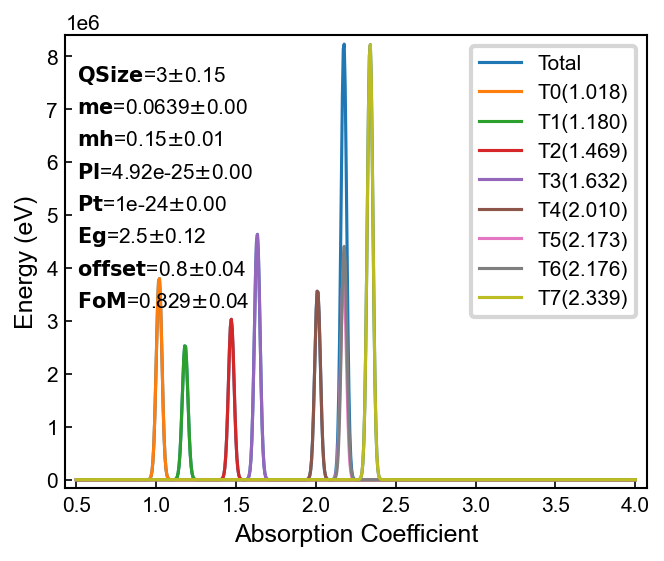

In [8]:
# Plot the best optimization result
utils.pso_best_abs("PSO_Results/results_29", save=True)

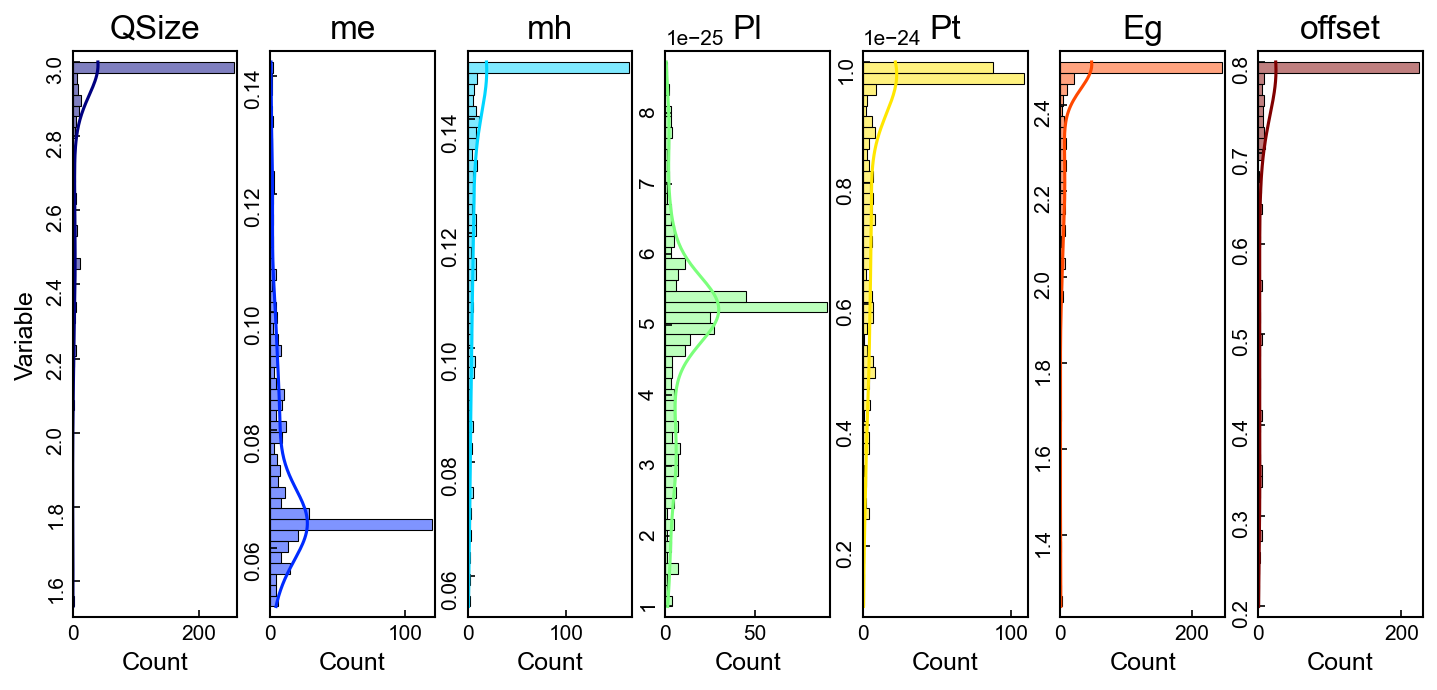

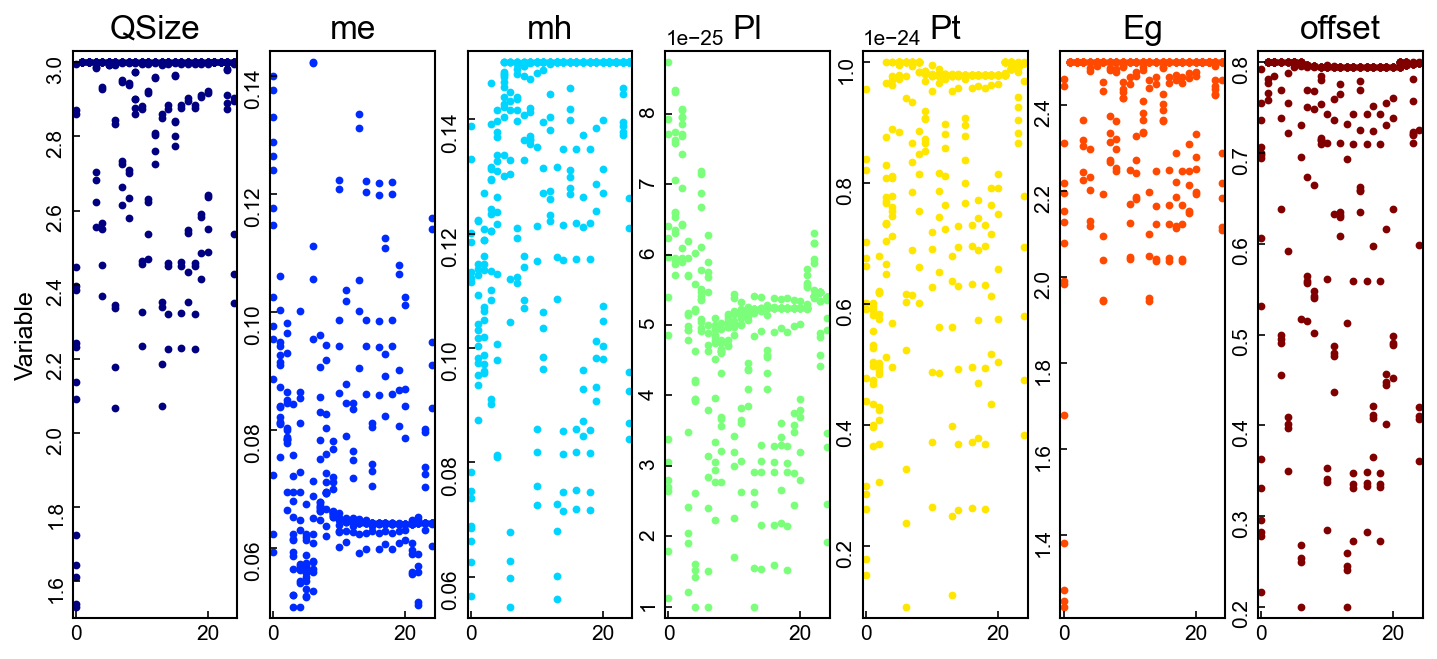

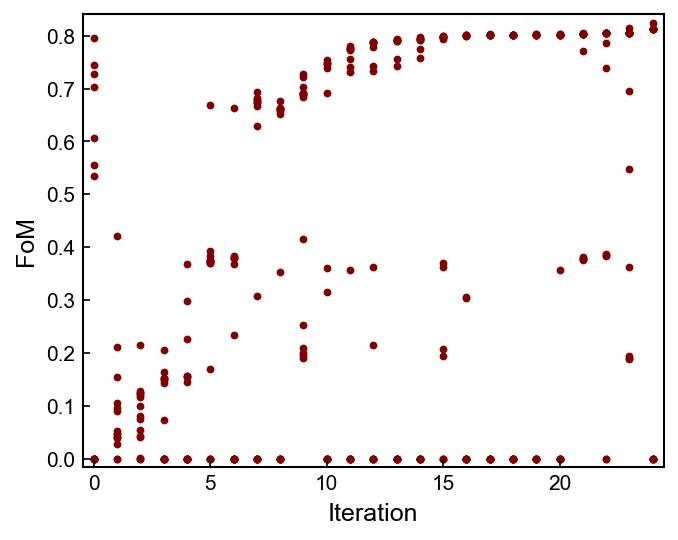

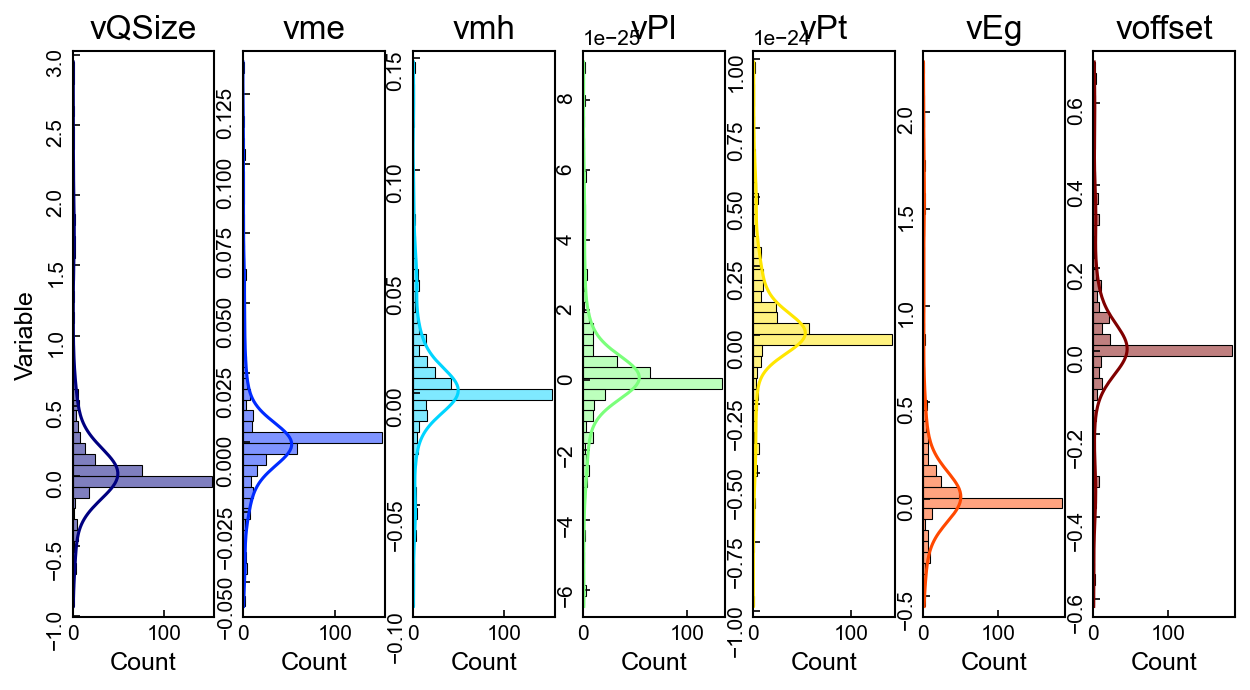

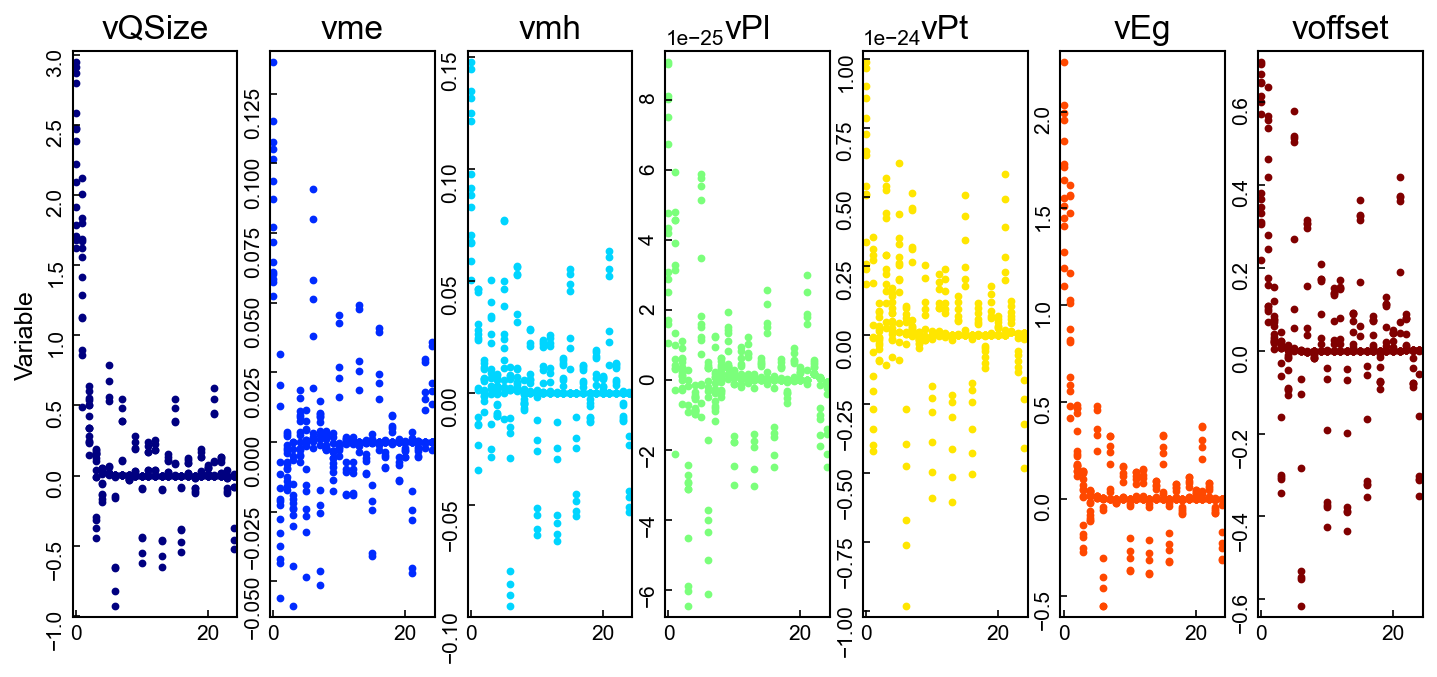

In [9]:
columns=["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
utils.pso_summary("PSO_Results", columns=columns, iterations=25, export=True, **{"figsize": (10, 5)})

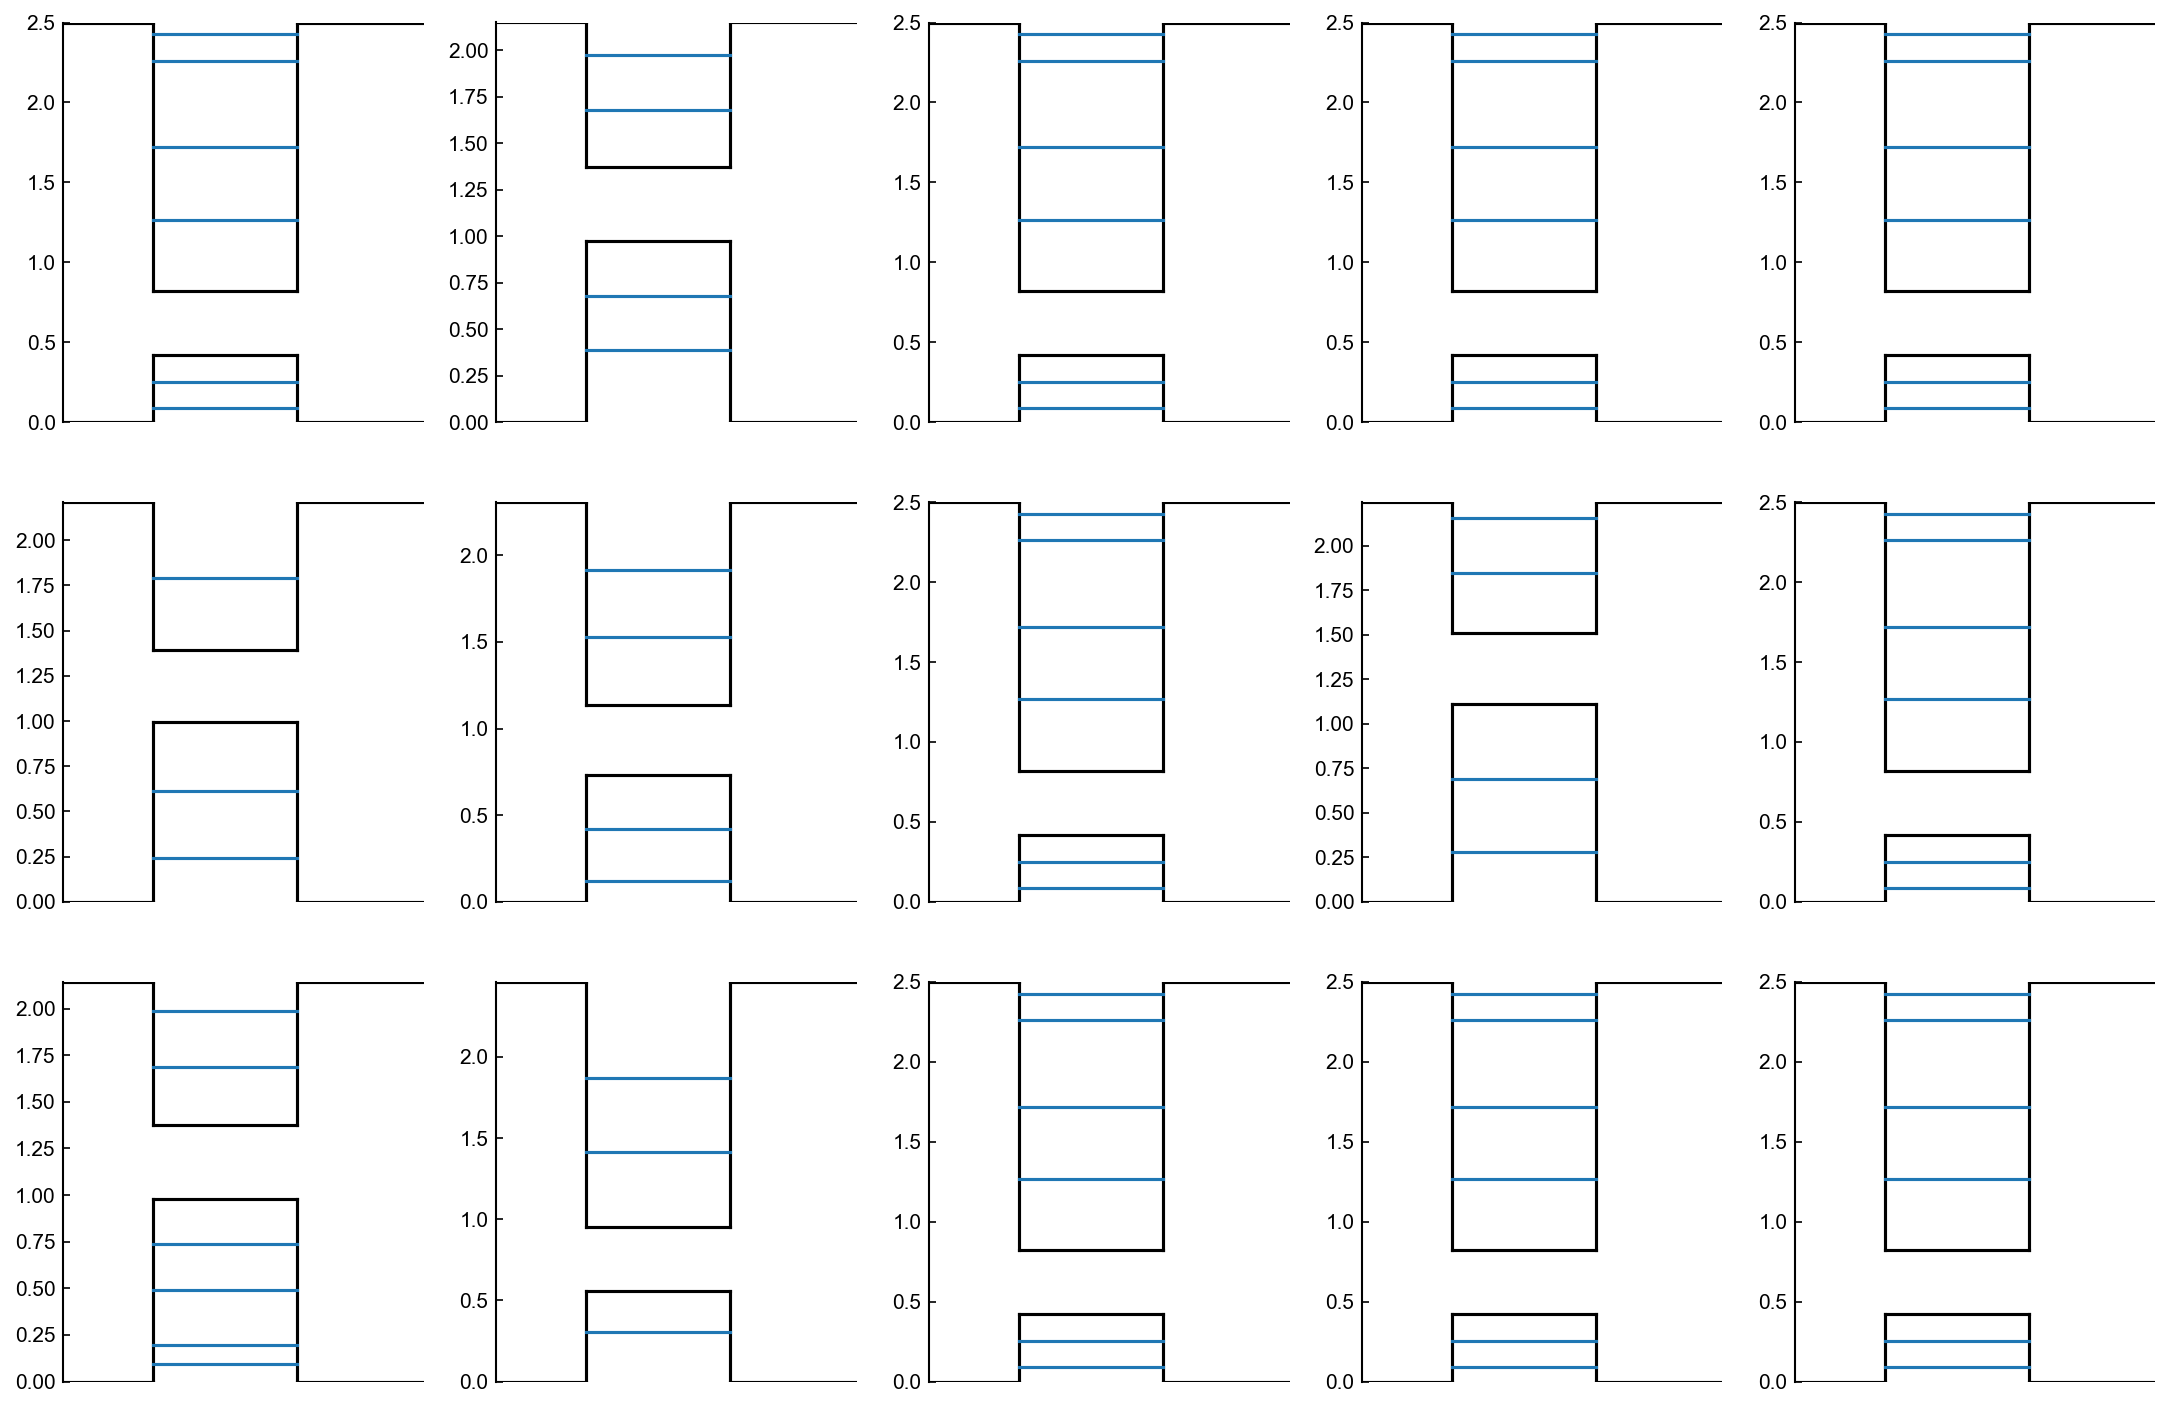

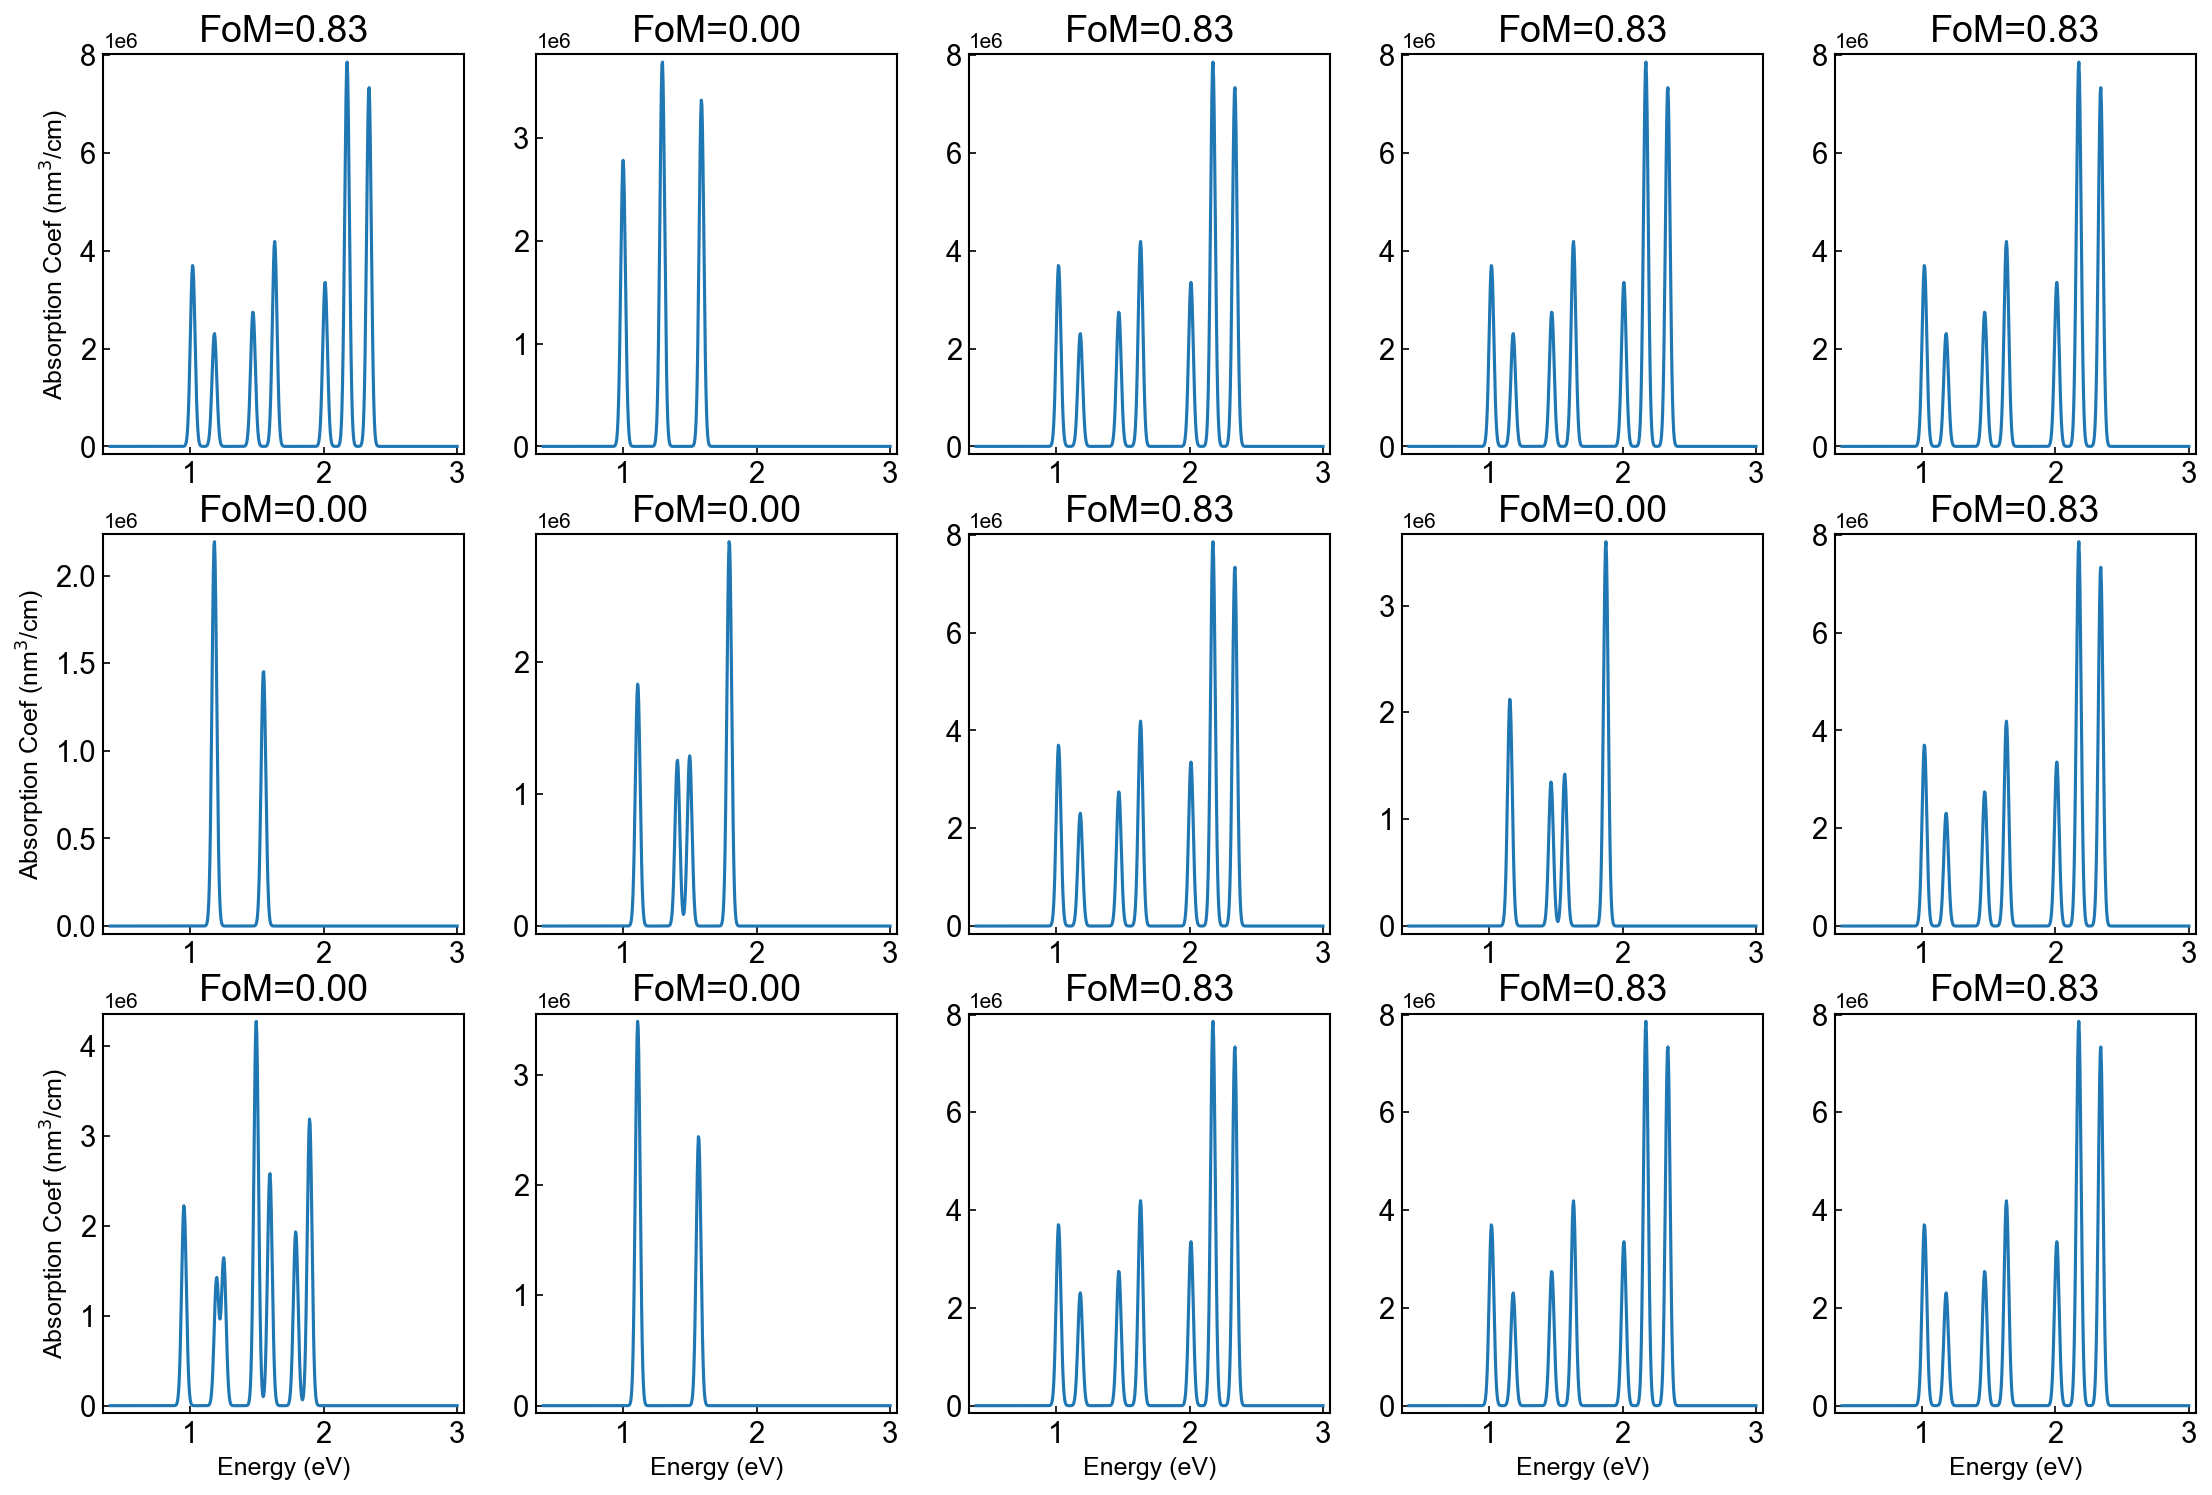

In [10]:
# Check to see the configuration for the best results
fig, ax = plt.subplots(3, 5, figsize=(18,12))
utils.pso_it_energy_profile(ax, "PSO_Results/results_29", save=True)
fig, ax = plt.subplots(3, 5, figsize=(18,12))
utils.pso_it_abs_preview(ax, "PSO_Results/results_29", save=True)

Perform the Monte Carlo analysis (5% and 1000 particles)

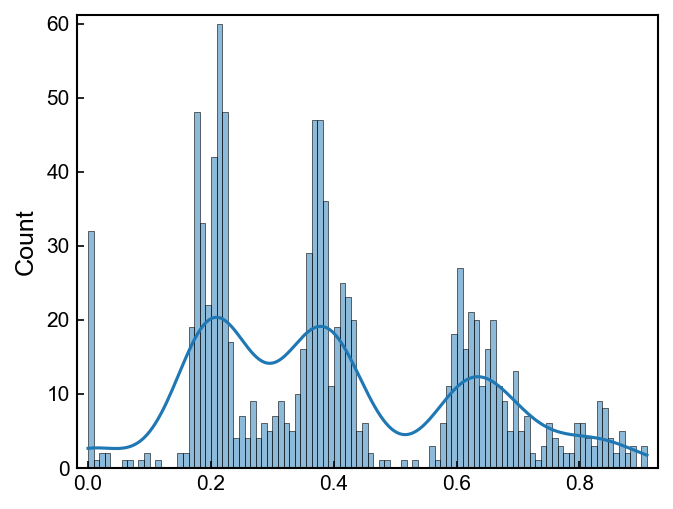

In [11]:
# Make the Monte Carlo analysis
columns = ["qd_size", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
data = pd.read_csv("PSO_Results/results_29", sep=" ", names=columns)
data.sort_values(by="FoM", ascending=False, ignore_index=True, inplace=True)
# Create a dictionary with the list of best parameters
best_res = data.loc[0][:7].to_dict()
mc_rnd = utils.mc_random(**best_res, tol=0.05, n_rnd=1000)
np.savetxt("mc_best_results.txt", mc_rnd.T)
save = True
sns.histplot(mc_rnd, bins=100, kde=True)
if save:
    plt.savefig("Mc_rnd.svg", transparent=True)

In [ ]:
res = utils.mc_pso_best_param("PSO_Results/results_29", n_rnd=1000, tol=0.05, save=True)

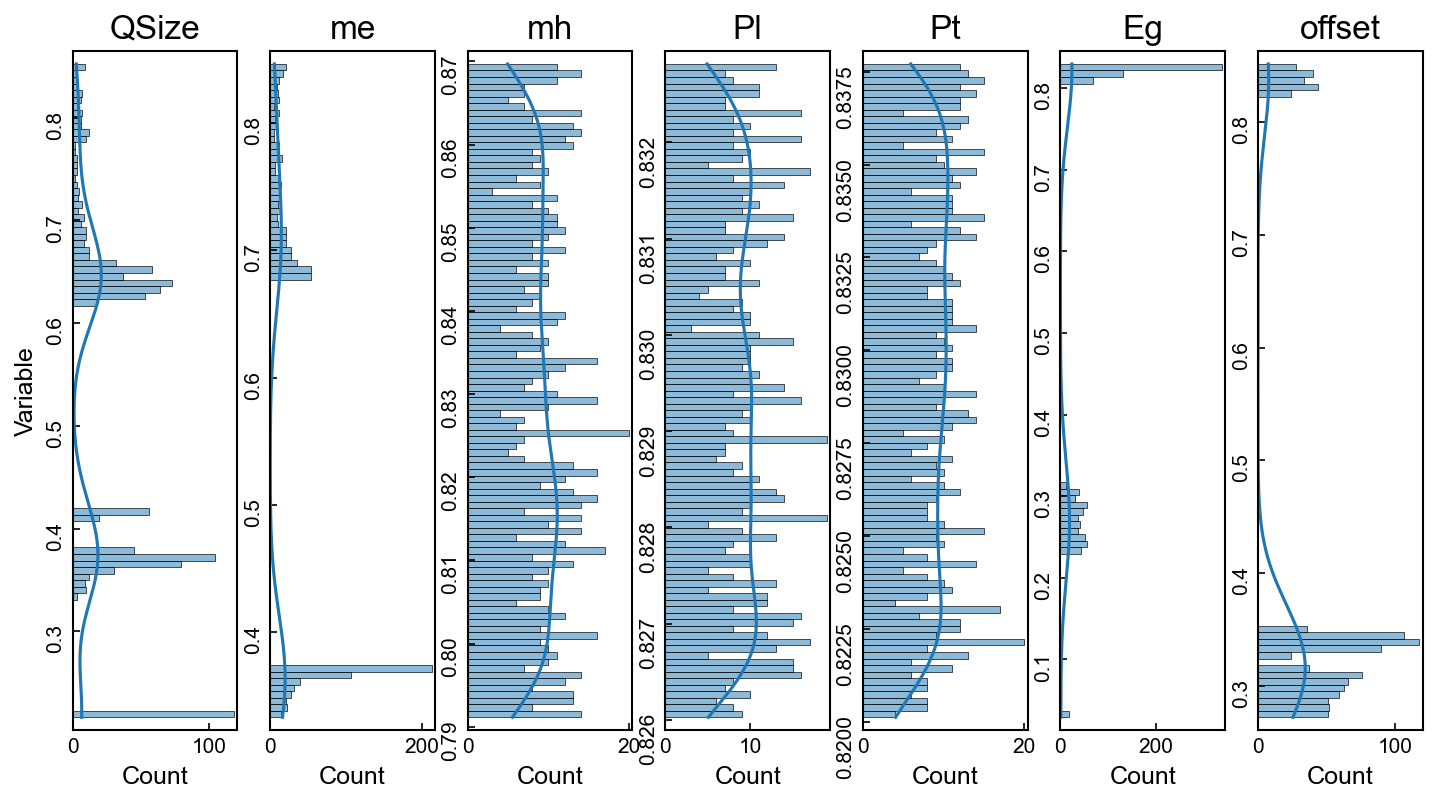

In [4]:
mc_part_res = np.loadtxt("best_particles.txt")
cols = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset"]
fig, ax = plt.subplots(1, 7, figsize=(10,6))
plt.subplots_adjust(wspace=0.2, left=0.05, right=0.95)
for i in range(7):
    sns.histplot(y=mc_part_res[:, i], bins=100, kde=True, ax=ax[i])
    if i == 0:
        ax[i].set_ylabel("Variable")
    else:
        ax[i].set_ylabel("") 
    ax[i].set_title(cols[i])
    ax[i].tick_params(axis="y", rotation=90)
plt.savefig(f"Particle_MC_05.svg", transparent=True)

The above result do not show the peak problem that was happening before, so at least all the calculation seem to be fine without any outlier points. Nevertheless, the previous FoM does not seem to be the best one as it seems it will always tend to max(QSize, Eg, offset) as these parameters are mostly responsible for defining the amount of energy levels, that in turn are responsible by increasing the overall absorption area. Unfortunately this value is not decreased enough by the consideration of the overall energy level.

As such, two other FoM could also be interesting to be studied:
* FoM = difference(Ecb-0.9-ideal)/Ntrn → A Figure of Merit that tries to determine the ideal BG point (0.9) and at the same time tries do decrease the number of transitions
    * This FoM still needs adjustment as the way it is now will almost certainly lead to the smalles QD size that can have the 0.9 energy level
* FoM = difference(Ecb-0.9)*I(absorption coefficient)/QSize → Similar to the original one, but with the added term of the energy difference
    * Here it may also be interesting to consider the number of transitions in order to also help offset the max QDSize

### A new FoM

Try the previous FoM but dividing also by the number of transitions

#### Testing different FoM

Define different FoM functions and then create a random array that will calculate 100 random points inside those arrays and then determines all FoMs for those 100 and then plots the resulting FoM (x axis should show the set of properties)

In [3]:
# Create a uniform array to make the random analysis
def uniform_array(n_rnd, qsize, me, mh, Pl, Pt, Eg, offset):
    """ Create a n_rnd size array for each property of the QD
    Each value should be given as a tuple (min, max) and the values will be
    generated inside those given bounds """
    rnd_qsize = np.random.uniform(qsize[0], qsize[1], size=(n_rnd))
    rnd_me = np.random.uniform(me[0], me[1], size=(n_rnd))
    rnd_mh = np.random.uniform(mh[0], mh[1], size=(n_rnd))
    rnd_Pl = np.random.uniform(Pl[0], Pl[1], size=(n_rnd))
    rnd_Pt = np.random.uniform(Pt[0], Pt[1], size=(n_rnd))
    rnd_Eg = np.random.uniform(Eg[0], Eg[1], size=(n_rnd))
    rnd_offset = np.random.uniform(offset[0], offset[1], size=(n_rnd))
    rnd_Vcb = (rnd_Eg - 0.4)*rnd_offset
    rnd_Vvb = (rnd_Eg - 0.4) - rnd_Vcb
    return rnd_qsize, rnd_me, rnd_mh, rnd_Pl, rnd_Pt, rnd_Eg, rnd_Vcb, rnd_Vvb

In [116]:
# Generate different FoM to show
def FoM1(abs_data, qsize):
    """ """
    int = -sci.simpson(abs_data["Total"], (scc.h * scc.c) / (abs_data["Energy"] * scc.e) * 1e2)
    Nlevels = abs_data.shape[1] - 2
    return int

def FoM2(abs_data, qsize):
    """ """
    int = -sci.simpson(abs_data["Total"], (scc.h * scc.c) / (abs_data["Energy"] * scc.e) * 1e2)
    Nlevels = abs_data.shape[1] - 2
    return int/Nlevels

def FoM3(abs_data, qsize):
    """ """
    int = -sci.simpson(abs_data["Total"], (scc.h * scc.c) / (abs_data["Energy"] * scc.e) * 1e2)
    Nlevels = abs_data.shape[1] - 2
    return int / (Nlevels*qsize)

def FoM4(abs_data, qsize):
    """ """
    int = -sci.simpson(abs_data["Total"], (scc.h * scc.c) / (abs_data["Energy"] * scc.e) * 1e2)
    Nlevels = abs_data.shape[1] - 2
    return int / (Nlevels*qsize**3)

def FoM5(abs_data, qsize):
    """ """
    int = -sci.simpson(abs_data["Total"], (scc.h * scc.c) / (abs_data["Energy"] * scc.e) * 1e2)
    Nlevels = abs_data.shape[1] - 2
    return np.cbrt(int) / (Nlevels*qsize)

FoM_List = [FoM1, FoM2, FoM3, FoM4, FoM5]

In [117]:
# Returns all the FoM applied to a specific set of QD properties
def FoM_aggregator(qd_size_i,
          Vcb_i,
          Vvb_i,
          me_i,
          mh_i,
          Pl_i,
          Pt_i,
          Eg_i,
          energy=np.linspace(2, 3, 200),
          lat_size=0.8,
          sim_size=25):
    """ Calculate the FoM for a single combination of parameters """
    sim_properties = (sim_size, lat_size, Eg_i, (Pl_i, Pt_i))
    # Assuming the energy variation
    logging.info(
        f"FoM:{qd_size_i=:.2f}  {me_i=:.2f}  {mh_i=:.2f}  {Pl_i=:.2g}" +
        f"  {Pt_i=:.2g}  {Eg_i=:.2f}" +
        f"  {Vcb_i=:.2f}  {Vvb_i=:.2f}")
    data = ab.interband_absorption(energy, (qd_size_i, Vcb_i, me_i, me_i),
                                (qd_size_i, Vvb_i, mh_i, mh_i), sim_properties)
    # The 1e2 serves to convert the wavelength from m to cm
    FoM_results = []
    for FoM in FoM_List:
        FoM_results.append(FoM(data, qd_size_i))
    return FoM_results

In [51]:
# Calculate everything
def FoM_global(rnd_qsize, rnd_me, rnd_mh, rnd_Pl, rnd_Pt, rnd_Eg, rnd_Vcb, rnd_Vvb):
    rnd_args = (rnd_qsize, rnd_Vcb, rnd_Vvb, rnd_me, rnd_mh, rnd_Pl, rnd_Pt, rnd_Eg)
    with Pool(multiprocessing.cpu_count() - 2) as p:
        final_results = p.starmap(FoM_aggregator, zip(*rnd_args))
    return final_results

In [160]:
# Generate the random arrays
res = uniform_array(150, (1,2), (0.05, 0.15), (0.05, 0.15), (1e-25, 1e-24), (1e-25, 1e-24), (1, 3), (0.1, 0.9))
fom_res = np.array(FoM_global(*res))

In [161]:
fom_res = np.abs(fom_res)

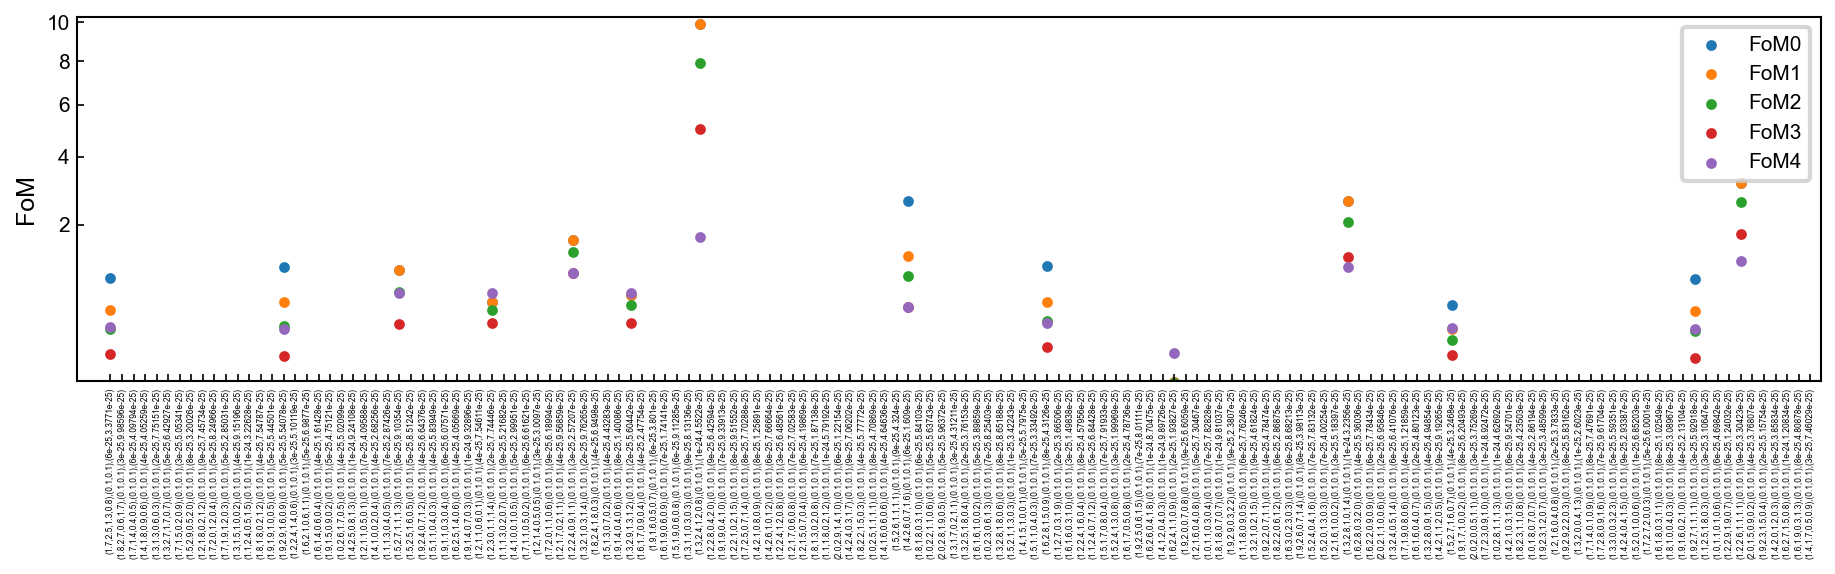

In [162]:
def forward(y):
    return np.sqrt(y)
def backward(y):
    return y**2

x = list(range(fom_res.shape[0]))
xlabel = [f"({qsize:.1f},{Eg:.1f},{Vcb:.1f},{Vvb:.1f}),({me:.1f},{mh:.1f}),({Pl:.1g},{Pt:-1g})" 
          for qsize, me, mh, Pl, Pt, Eg, Vcb, Vvb in zip(*res)]
_, ax = plt.subplots(figsize=(15, 10))
ax.set_aspect(10)
ax.set_ylabel("FoM")
ax.set_xticks(x, xlabel, rotation=90, fontsize=4)
for i in range(fom_res.shape[1]):
    ax.scatter(x, fom_res[:, i], label=f"FoM{i}", s=10)
ax.legend()
ax.set_yscale("function", functions=(forward, backward))

In [64]:
# Test new FoM
Eg = 2.3; Pt = 4.7e-25; Pl = 3.4e-25; lat_size = 0.8; sim_size = 15
me = 0.08; mh = 0.08; Vcb = 0.4; Vvb = 1.5; qd_size = 3;
sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
ab.FoM_int_size_nlevels(qd_size, Vcb, Vvb, me, mh, Pl, Pt, Eg, 0.1)

0.7657095384107965

In [ ]:
# Perform single optimization
param_dict = {
    "qd_size": [1, 3.5],
    "me": [0.05, 0.15],
    "mh": [0.05, 0.15],
    "Pl": [1e-25, 1e-24],
    "Pt": [1e-25, 1e-24],
    "Eg": [1, 3],
    "offset": [0.2, 0.8]
}
# The lat_size of 0.65 is used because there may be smaller QDs during the optimization
const_args = {
    "energy": np.linspace(0.5, 4, 600),
    "lat_size": 0.65,
    "sim_size": 25
}
opt_function = partial(ab.opt_function_general, func = ab.FoM_int_size_nlevels)
res = particle_swarm(opt_function, param_dict,
                     n_particles=20, n_iter=50,
                     export=True, swarm_properties=(0.6, 1.2, 1.2),
                     **const_args)

TypeError: opt_function_general() got an unexpected keyword argument 'n_particles'

In [10]:
res

(13.169890370729261,
 array([1.09642880e+00, 1.17114580e-01, 8.52777162e-02, 9.12706033e-25,
        4.25951625e-25, 2.66995871e+00, 4.34743306e-01]),
 array([[1.09551938e+00, 1.09663271e+00, 1.09683234e+00, 1.09687250e+00,
         1.09652198e+00, 1.09626483e+00, 1.09688038e+00, 1.09555669e+00,
         1.09682910e+00, 1.09555935e+00, 1.09686867e+00, 1.09688128e+00,
         1.09688388e+00, 1.09626745e+00, 1.09430418e+00, 1.09571055e+00,
         1.09621353e+00, 1.09660545e+00, 1.09687238e+00, 1.09639106e+00],
        [1.17168440e-01, 1.17094625e-01, 1.17081273e-01, 1.17077289e-01,
         1.17108485e-01, 1.17126077e-01, 1.17078683e-01, 1.17167396e-01,
         1.17079964e-01, 1.17167249e-01, 1.17077272e-01, 1.17077120e-01,
         1.17077781e-01, 1.17132694e-01, 1.17271001e-01, 1.17168499e-01,
         1.17128516e-01, 1.17114196e-01, 1.17077560e-01, 1.17107553e-01],
        [8.53610817e-02, 8.52924941e-02, 8.52398610e-02, 8.52330937e-02,
         8.52572056e-02, 8.53118761e-02, 8.5

In [12]:
# Best CB QD for the top band
cb_best = qbd.qd_results(1.1, 0.99, 0.12, 0.12, "CB1")
cb_best.e_levels

l0
0 -0.081132

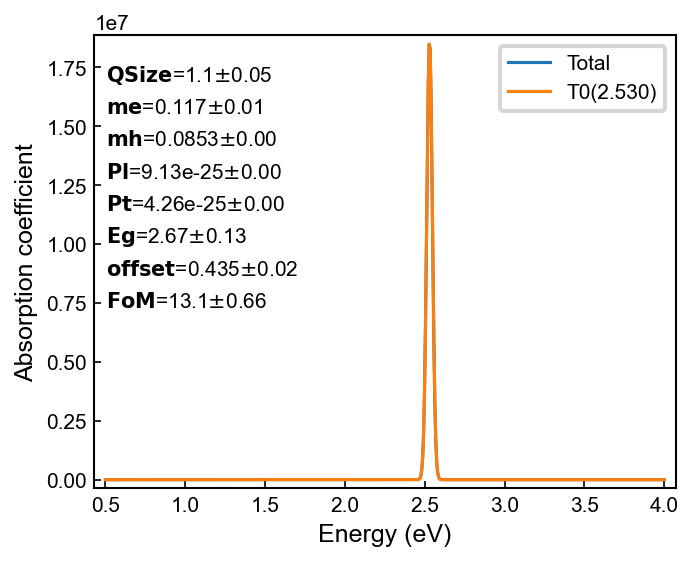

In [11]:
# Plot the best optimization result
utils.pso_best_abs("PSO_Results/results_49", save=True)

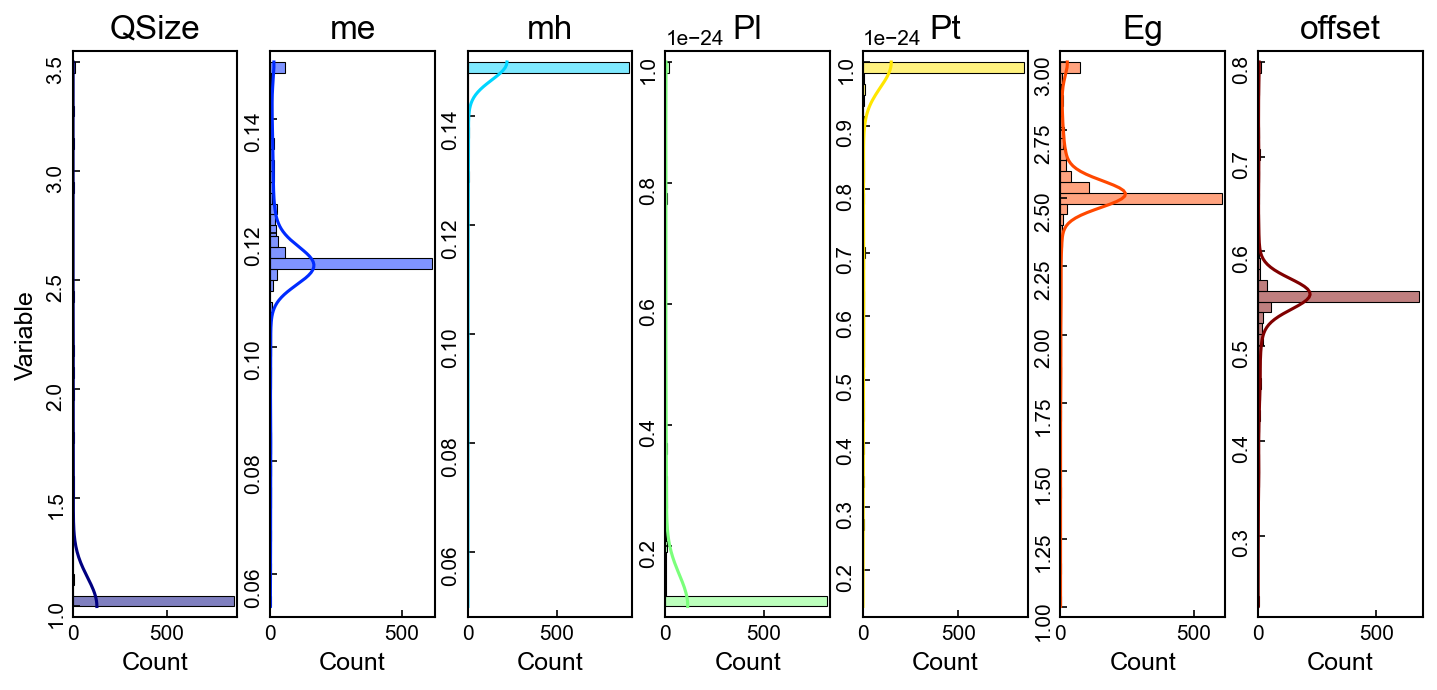

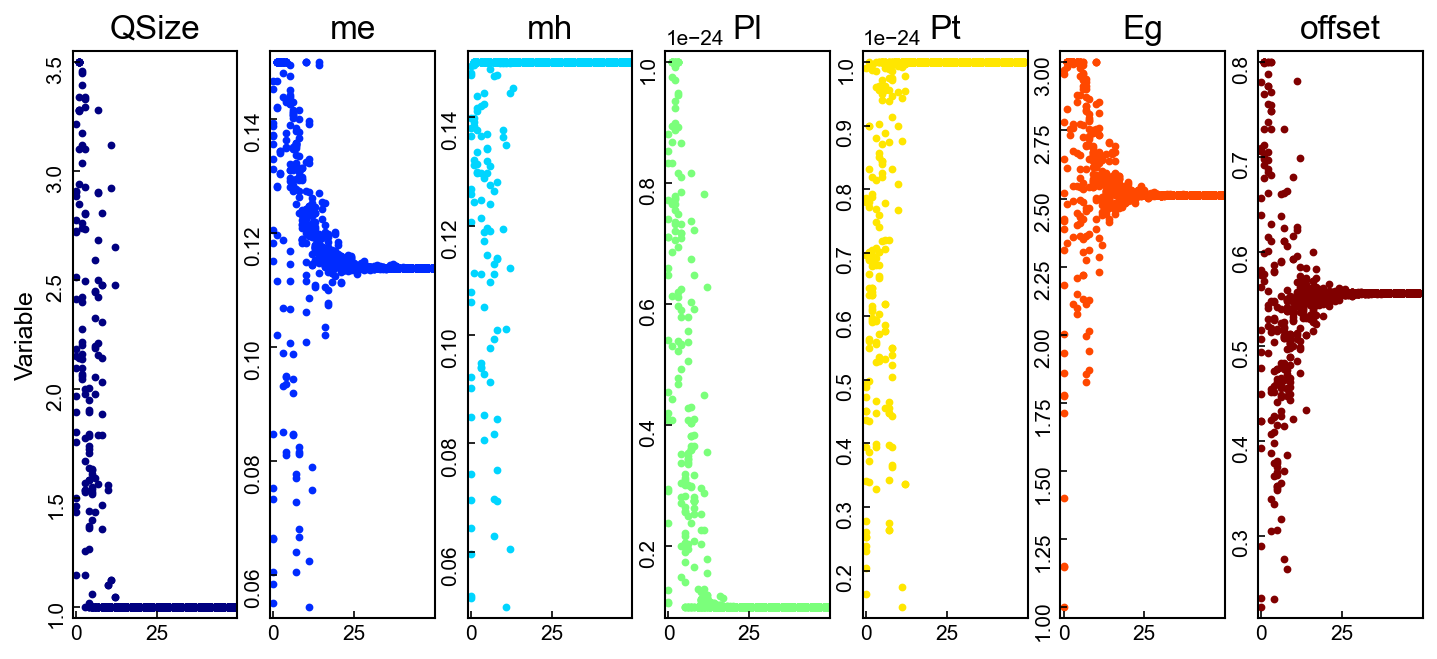

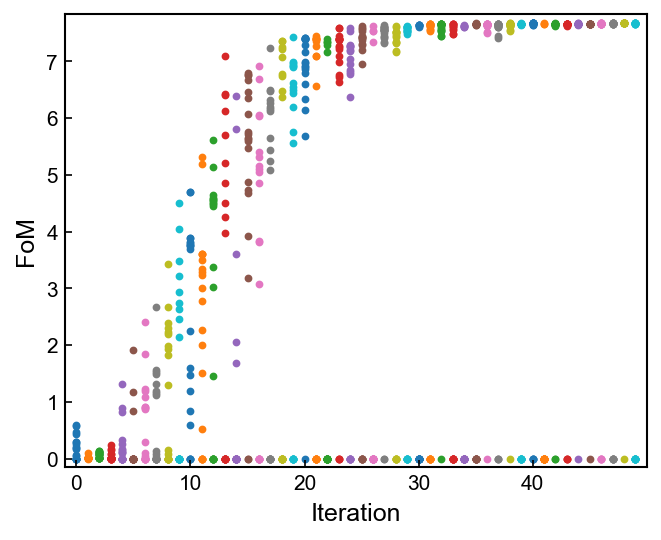

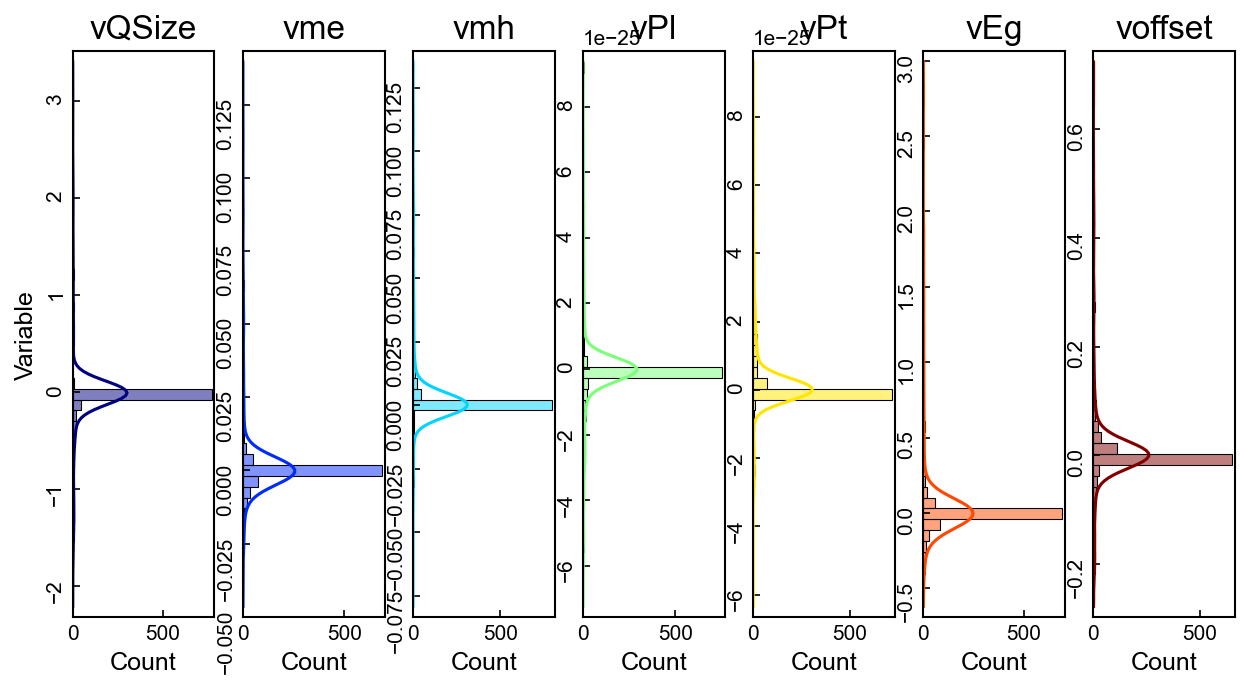

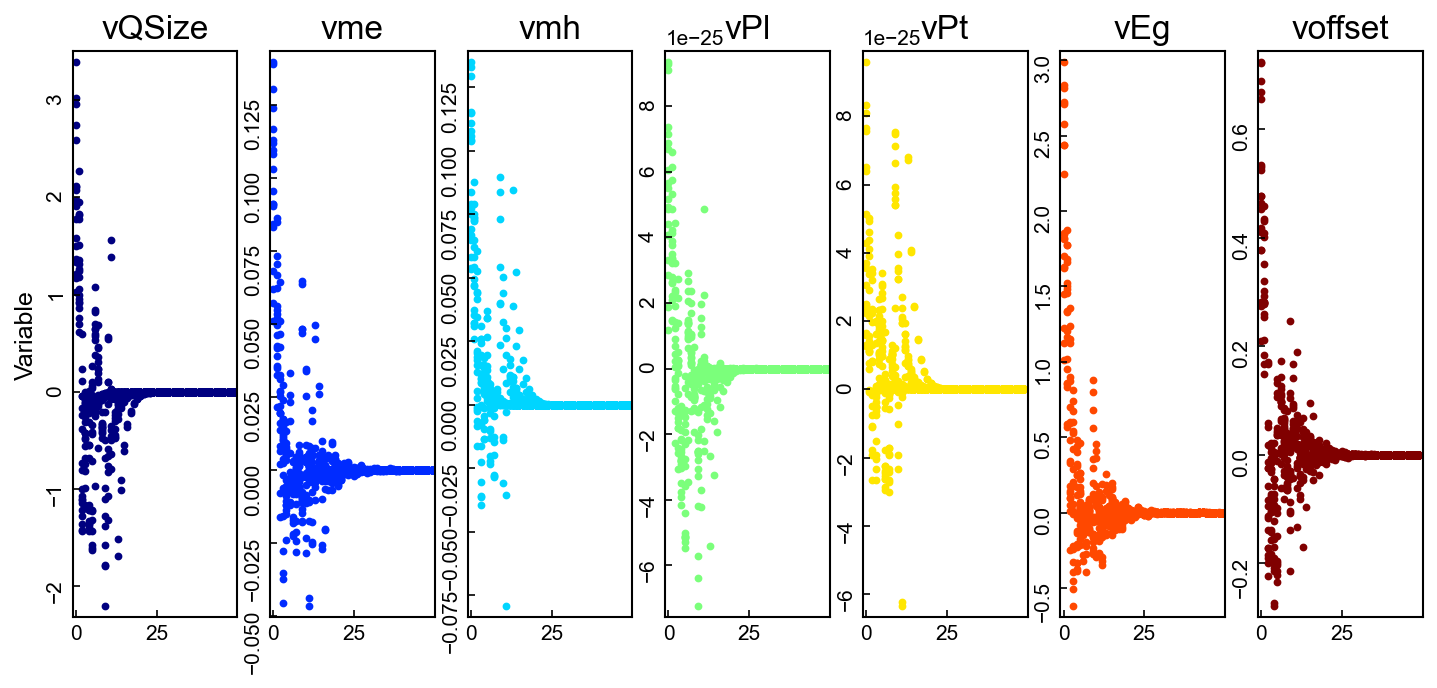

In [6]:
columns=["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
utils.pso_summary("PSO_Results", columns=columns, iterations=50, n_particles=20, export=True, **{"figsize": (10, 5)})

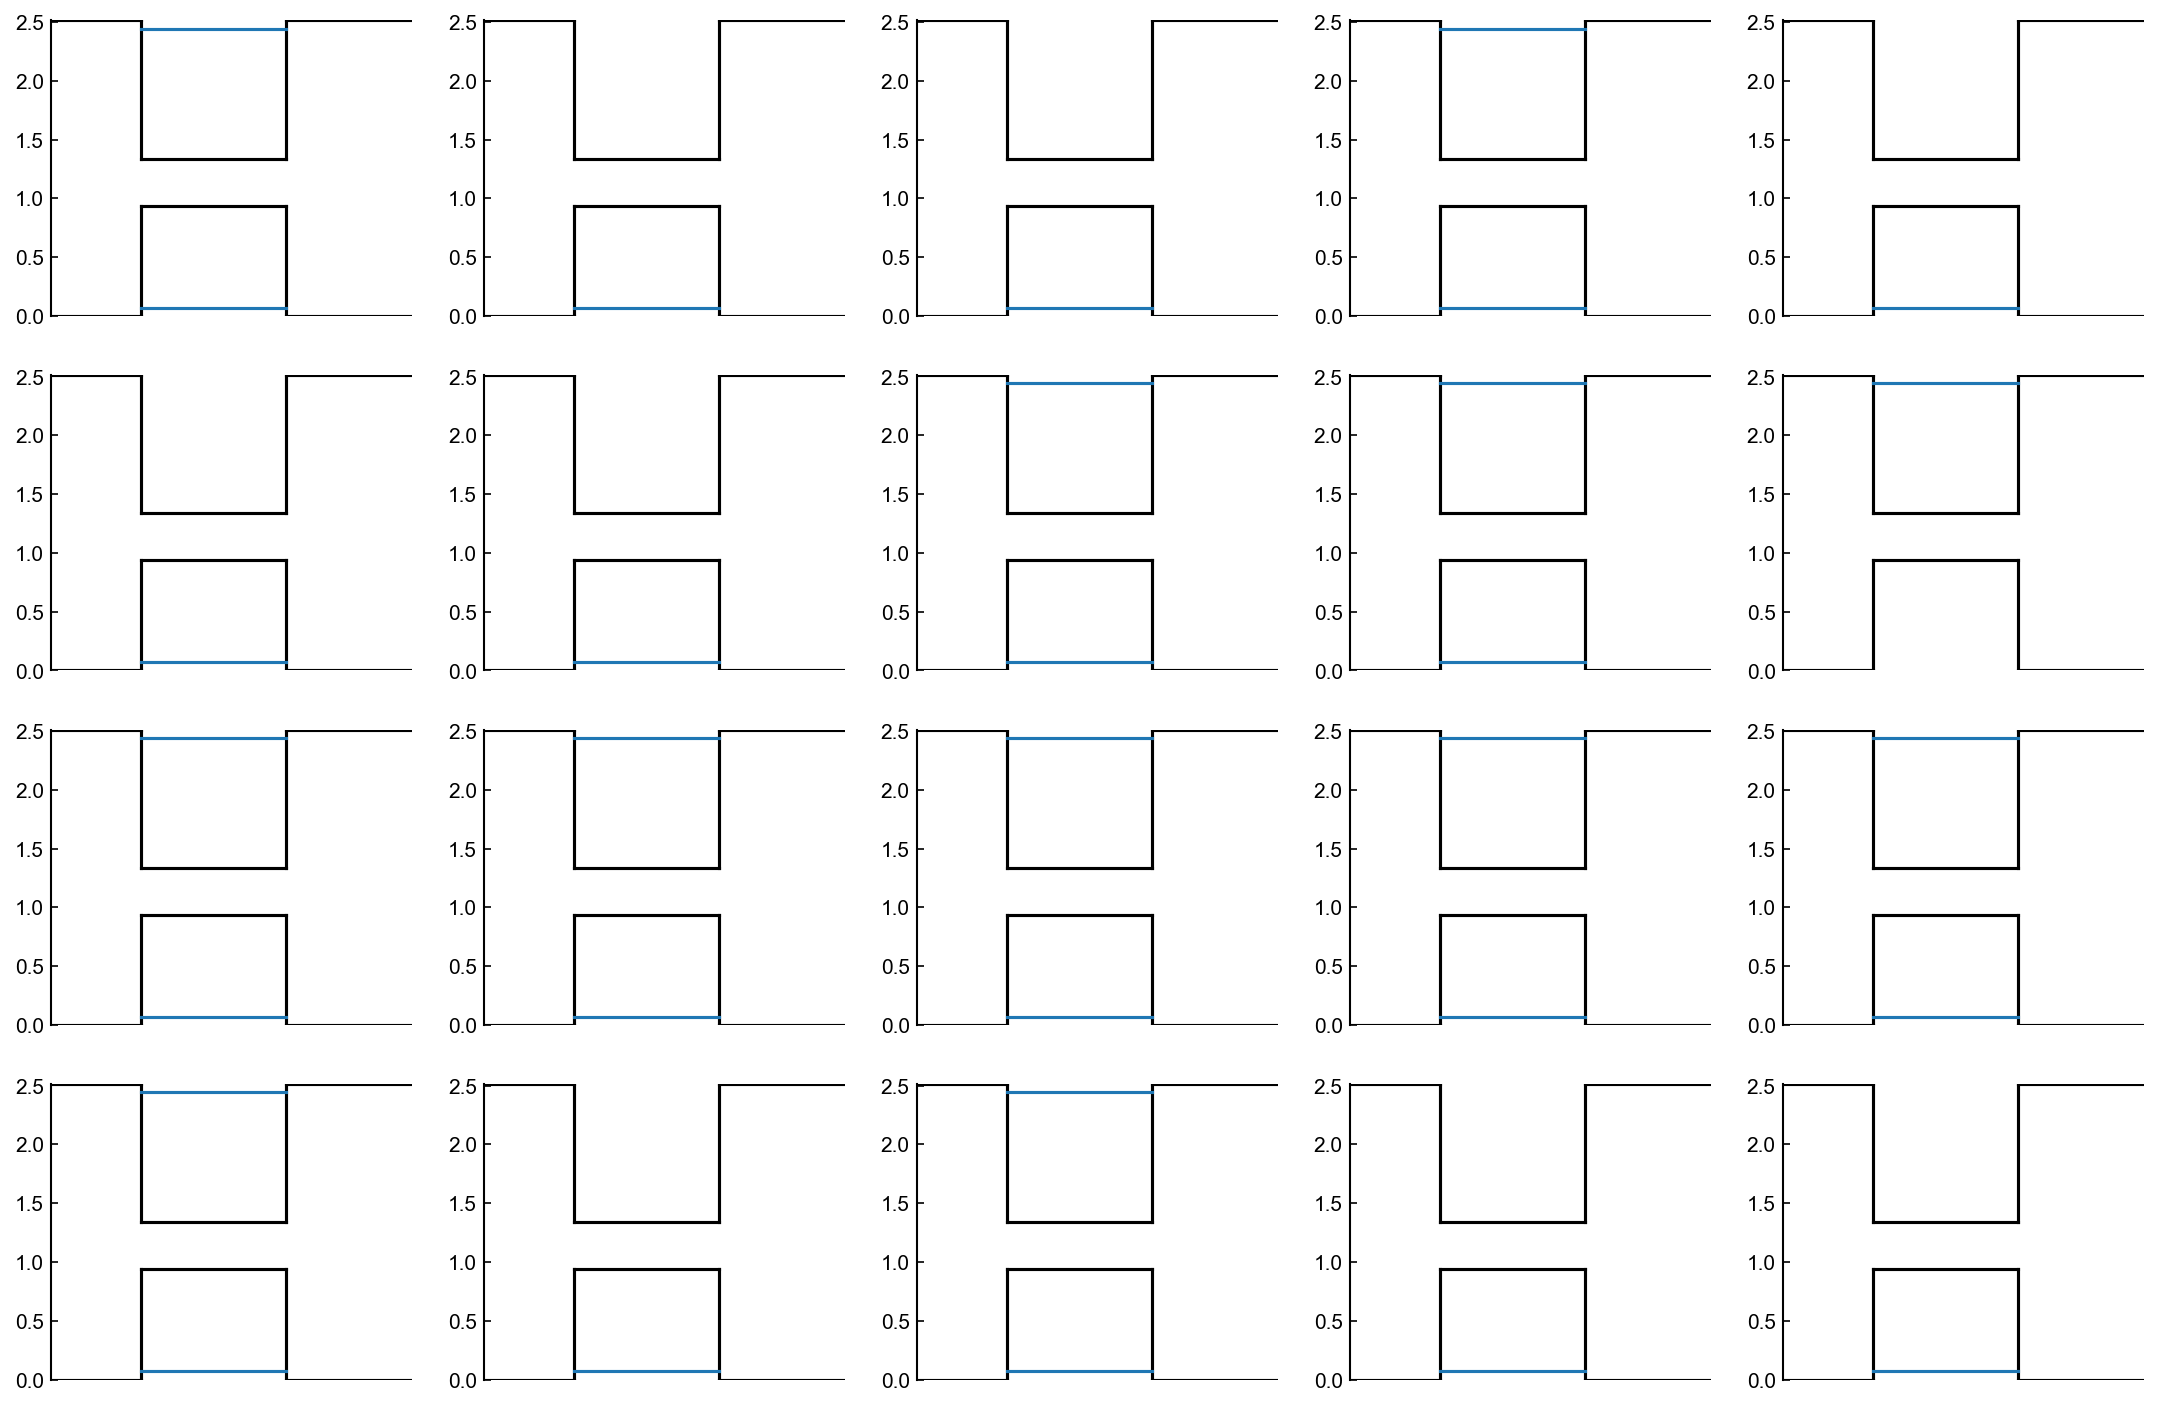

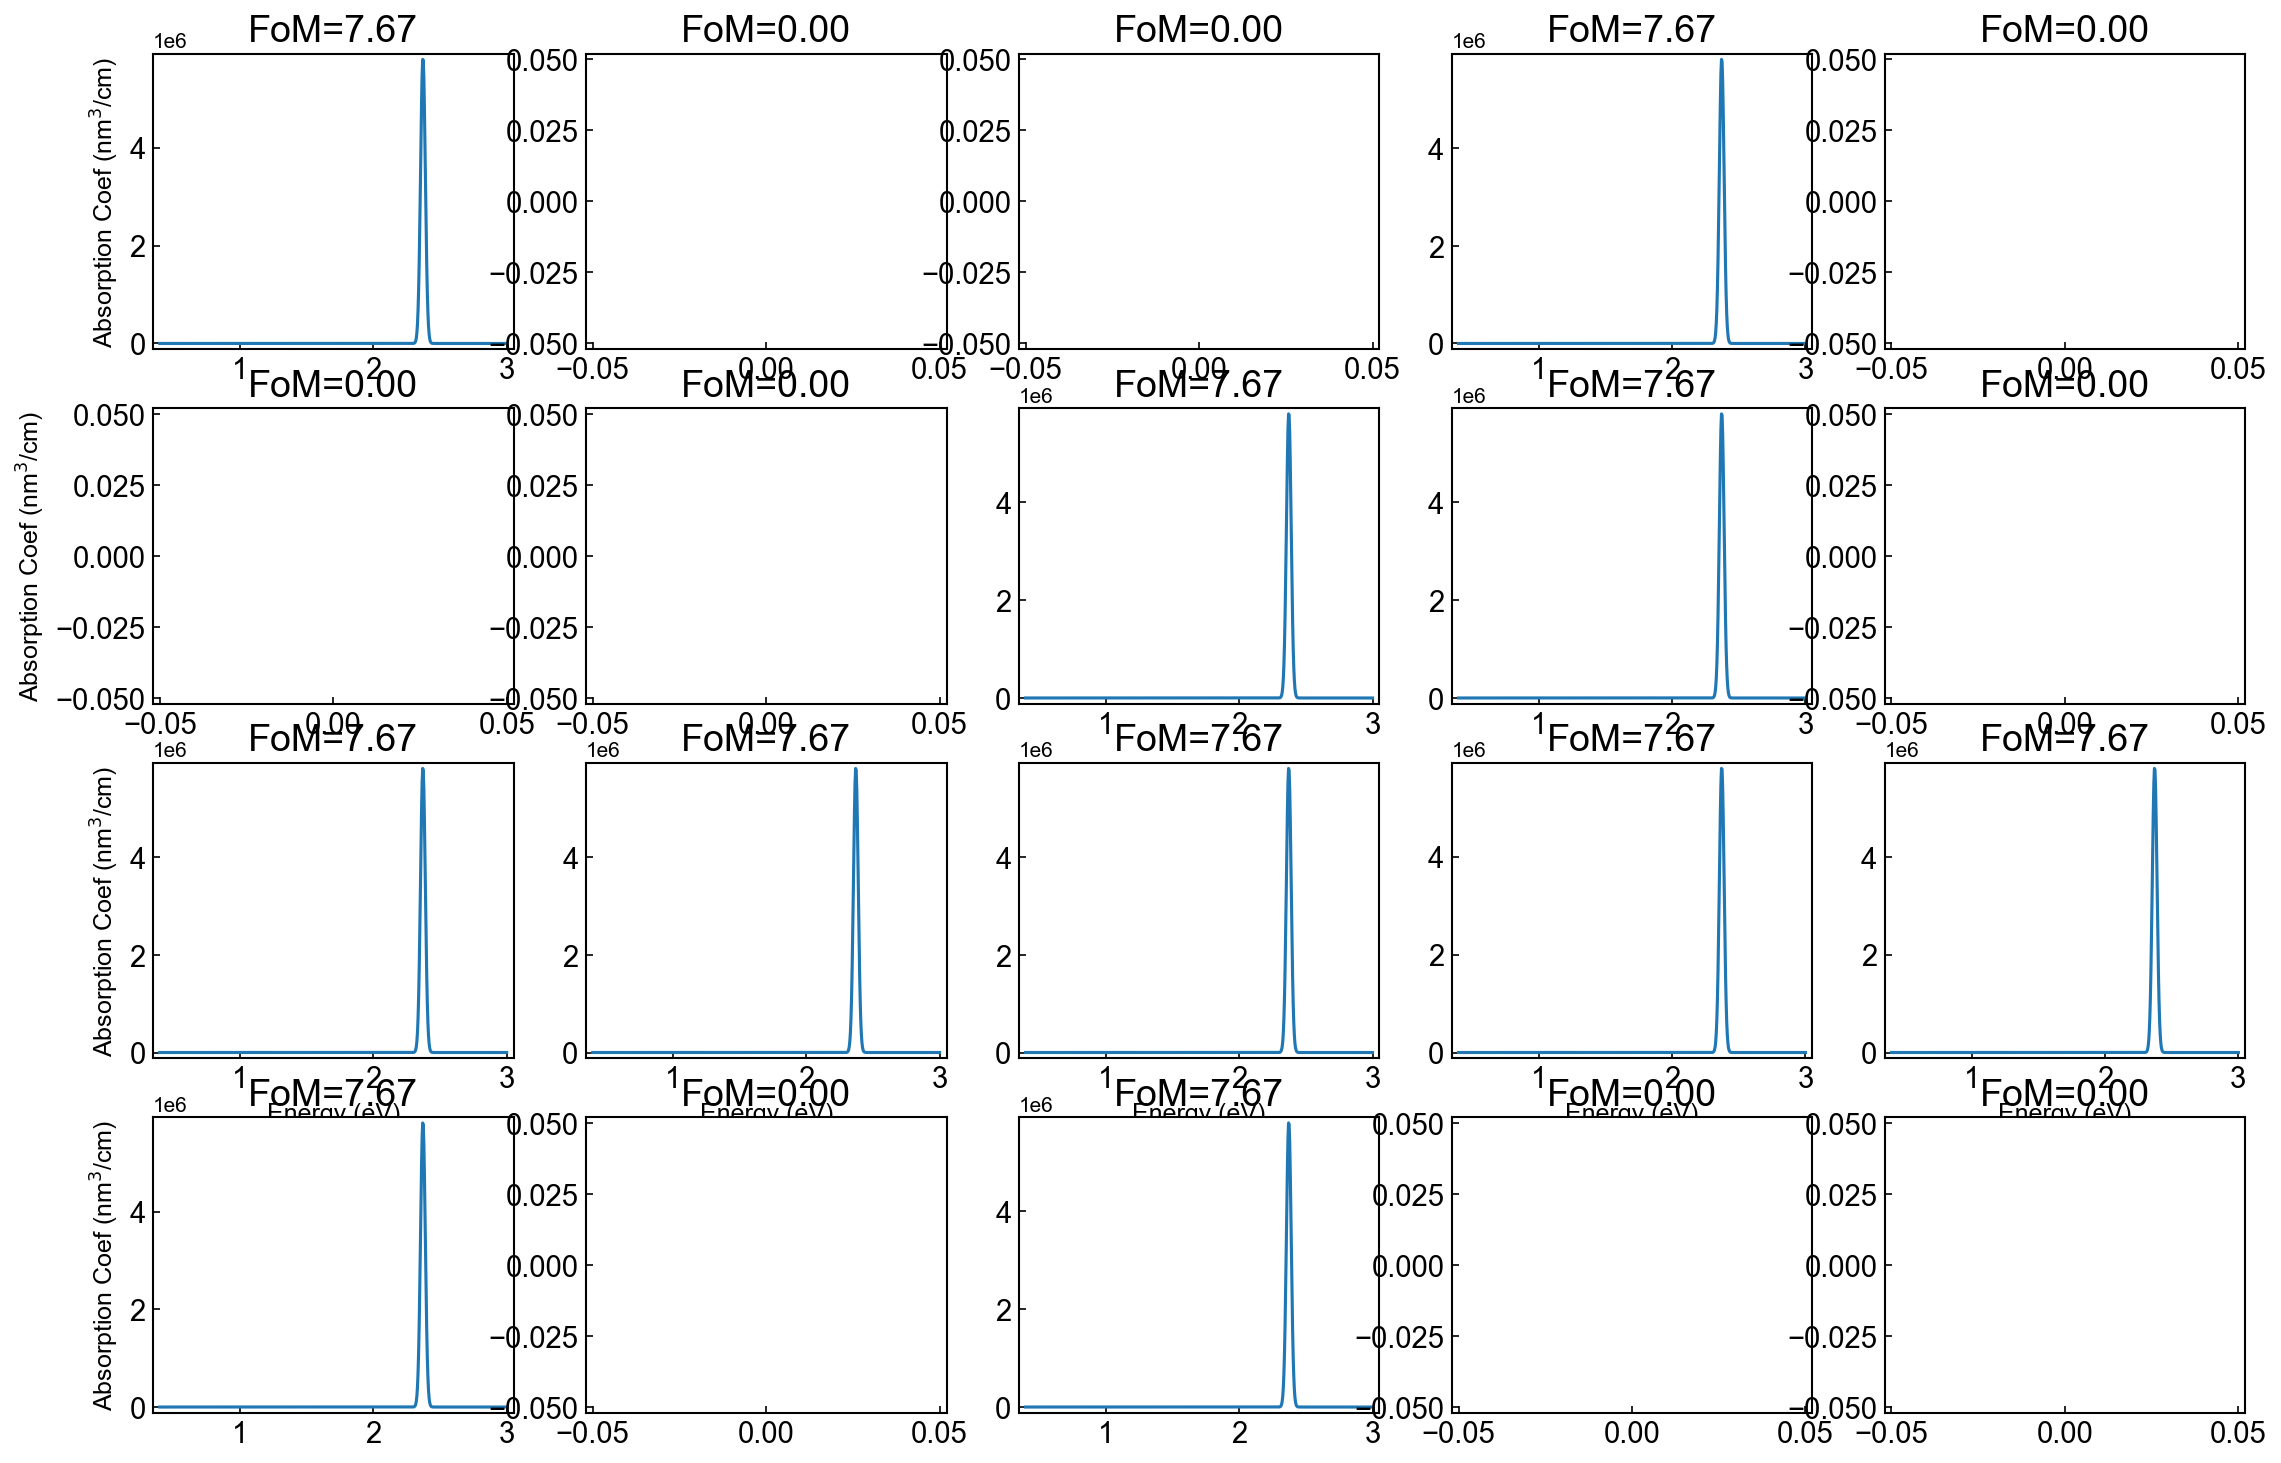

In [8]:
# Check to see the configuration for the best results
fig, ax = plt.subplots(4, 5, figsize=(18,12))
utils.pso_it_energy_profile(ax, "PSO_Results/results_49", save=True)
fig, ax = plt.subplots(4, 5, figsize=(18,12))
utils.pso_it_abs_preview(ax, "PSO_Results/results_49", save=True)

### Composite FoM

Considering the problems seen in the calculation of the FoM for the absorption as it is extremely difficult to properly balance the QD absorption with the number of energy levels. It may be interesting to explore other methodologies to determine the FoM

-- This may also suffer from the fact that bigger QDs do lead to bigger absorption (more energy levels) so considering that any optimization FoM will require bigger absorption essentially only bigger QDs will clearly be the optimized condition even if experimentally they are not the idelly wanted

New Method:

- Smaller number of energy levels
- One energy level in the CB close to 0.9
- Smaller size
- Bigger absorption

```python
def _single_FoM_2(qd_size_i,
                  Vcb_i,
                  Vvb_i,
                  me_i,
                  mh_i,
                  Pl_i,
                  Pt_i,
                  Eg_i,
                  offset_i,
                  energy=np.linspace(2, 3, 200),
                  lat_size=0.8,
                  sim_size=25):
    """
    Calculate the FoM for a single combination of parameters
    This FoM Considers:
        - Number of energy levels (smaller the better)
        - Energy Level close to 0.9 in the CB
        - Smaller QD size
        - Better Absorption
    """
    ideal_ib = -0.9
    sim_properties = (sim_size, lat_size, Eg_i, (Pl_i, Pt_i))
    # Assuming the energy variation
    logging.info(
        f"Single FoM:{qd_size_i=:.2f}  {me_i=:.2f}  {mh_i=:.2f}  {Pl_i=:.2g}" +
        f"  {Pt_i=:.2g}  {Eg_i=:.2f}  {offset_i=:.2f}" +
        f"  {Vcb_i=:.2f}  {Vvb_i=:.2f}")
    qd_data = qbd.qd_results(qd_size_i, Vcb_i, me_i, me_i, "CB1")
    similarity = np.abs(np.nanmin(qd_data.e_levels.values - ideal_ib))
    data = ab.interband_absorption(energy, (qd_size_i, Vcb_i, me_i, me_i),
                                (qd_size_i, Vvb_i, mh_i, mh_i), sim_properties)
    NLevels = data.shape[1] - 2
    # The 1e2 serves to convert the wavelength from m to cm
    FoM = -sci.simpson(data["Total"],
                       (scc.h * scc.c) / (data["Energy"] * scc.e) * 1e2)
    logging.info(f"{FoM=}::{NLevels=}::{qd_size_i=}::{similarity=}")
    return FoM / (qd_size_i**3 * NLevels * similarity)
```

In [4]:
# Create a uniform array to make the random analysis
def uniform_array_test(n_rnd, qsize, me, mh, Pl, Pt, Eg, offset):
    """ Create a n_rnd size array for each property of the QD
    Each value should be given as a tuple (min, max) and the values will be
    generated inside those given bounds """
    rnd_qsize = np.random.uniform(qsize[0], qsize[1], size=(n_rnd))
    rnd_me = np.random.uniform(me[0], me[1], size=(n_rnd))
    rnd_mh = np.random.uniform(mh[0], mh[1], size=(n_rnd))
    rnd_Pl = np.random.uniform(Pl[0], Pl[1], size=(n_rnd))
    rnd_Pt = np.random.uniform(Pt[0], Pt[1], size=(n_rnd))
    rnd_Eg = np.random.uniform(Eg[0], Eg[1], size=(n_rnd))
    rnd_offset = np.random.uniform(offset[0], offset[1], size=(n_rnd))
    return rnd_qsize, rnd_me, rnd_mh, rnd_Pl, rnd_Pt, rnd_Eg, rnd_offset

In [ ]:
# Perform single optimization
# In this case perform the optimization with QSize**3, NLevels and Similarity
param_dict = {
    "qd_size": [1.5, 3.5],
    "me": [0.05, 0.15],
    "mh": [0.05, 0.15],
    "Pl": [1e-25, 1e-24],
    "Pt": [1e-25, 1e-24],
    "Eg": [1.5, 3],
    "offset": [0.2, 0.8]
}
# The lat_size of 0.65 is used because there may be smaller QDs during the optimization
const_args = {
    "energy": np.linspace(0.5, 4, 600),
    "lat_size": 0.65,
    "sim_size": 15
}
opt_function = partial(ab.opt_function_general, func = ab.FoM_similatiry_size)
res_df = pd.DataFrame(index=[i for i in range(10)], columns=param_dict.keys())
res_df["FoM"] = np.nan
for i in range(10):
    res = particle_swarm(opt_function, param_dict,
                         particles=25, iterations=60,
                         export=True,
                         **const_args)
    res_df.iloc[i, 0:-1] = res[1]
    res_df.loc[i, "FoM"] = res[0]
    os.rename("PSO_Results", f"PSO_Results_{i}")

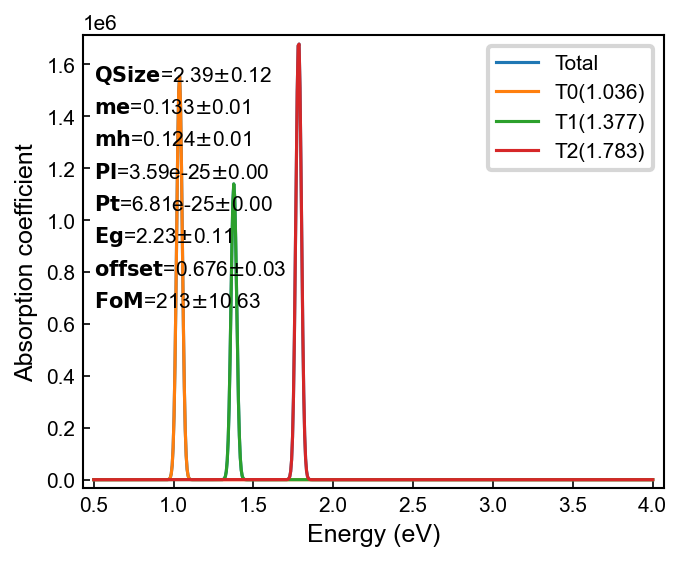

In [32]:
## Plot the best optimization result
utils.pso_best_abs("PSO_Results/results_49", save=True)

### Use sweeps with less parameters instead of Particle Swarm

In [37]:
# Default values
energy=np.linspace(2, 3, 200)
lat_size=0.65
sim_size=15
Pl=3.4e-25
Pt=4.7e-25
n_array=100
# Arrays to determine properties
eg = np.linspace(1, 3, n_array)
qd_size = np.linspace(1.5, 3.5, n_array)
# List of parameters used for the calculation of the FoM
opt_parameter = ["int_abs", "similarity", "NTrn"]
# Create DF list to store data in each opt_parameter
opt_param_df = [pd.DataFrame(index=eg, columns=qd_size) for _ in opt_parameter]
# Loop through all the values to be calculated
for me_i in [0.15]:
    for offset_i in [0.8, 0.9]:
        for index, eg_i in enumerate(eg):
            Vcb = (eg_i - 0.4) * offset_i
            Vvb = (eg_i - 0.4) - Vcb
            # Create a partial funcion with some parameters constant
            __func = partial(ab.opt_data,
                             Vcb_i=Vcb,
                             Vvb_i=Vvb,
                             me_i=me_i,
                             mh_i=me_i,
                             Pl_i=Pl,
                             Pt_i=Pt,
                             Eg_i=eg_i,
                             offset_i=offset_i,
                             energy=energy,
                             lat_size=lat_size,
                             sim_size=sim_size)
            # Calculate all the results
            with Pool(multiprocessing.cpu_count() - 2) as p:
                res = p.map(__func, qd_size)
            # res should be a list of tuples with 3 elements
            # Rearange to be a list where each entry has all the elements
            rearange_results = []
            for i, opt_param_i in enumerate(opt_parameter):
                rearange_results.append([res_j[i] for res_j in res])
            # Store results in the results df
            for i, opt_param_df_i in enumerate(opt_param_df):
                opt_param_df_i.iloc[index, :] = np.array(rearange_results[i])
        for index, opt_param_i in enumerate(opt_parameter):
            opt_param_df[index].to_csv(f"EvsQSize_{opt_param_i}_{me_i}_{offset_i}.csv", na_rep="nan", sep=" ", index_label="nan")

## The final (composite) absorption

The final composite absorption of the device will be calculated using the Bruggerman effective medium method. Where we will consider the QDs to be dispersed in the host material.

The equation for that is as follows:

\begin{equation}
p_{QD}\frac{n_{QD} - n_{eff}}{n_{QD}+2*n_{eff}} + (1-p_{QD})\frac{n_{PVK}-n_{eff}}{n_{PVK}+2n_{eff}}
\end{equation}

Each n is the complex values n.

In the case of the QD, the real part of the refractive index used will be one obtained from the literature, while the complex part will be the the determined absorption coefficient.

$$ n* = n (literature refractive index for PbS) + ik (calculated absorption coefficient) $$

For the perovskite material, the authors will simply use a value obtained from the literature. Here it is also important to consider that by optimizing the bandgap the perovskite properties should also be adapted. The best method for count for this should be to simply shift the overall properties around. So just obtain some high bg perovskite properties and then shift the refractive index and absorption coefficient with the change in host BG

Also tested the Kramers-Kronig method, however it did not seem to provide any meaningfull results

In [ ]:
def kramers_kronig(ang_freq, abs_coef):
    """ Apply the kramers kronig to the abs_coef to return the refractive in the given
    energy interval
    """
    n_data = np.ones_like(ang_freq)
    ang_freq_array = np.broadcast_to(ang_freq, (ang_freq.size, ang_freq.size))
    for index, denominator in enumerate(-ang_freq[:, np.newaxis]**2 + ang_freq**2):
        # Create the lower and upper integration bounds
        l_bound, u_bound = denominator[:index], denominator[index+1:]
        l_abs_bound, u_abs_bound = abs_coef[:index], abs_coef[index+1:]
        # Integrate both bounds, considering the edge cases
        if index == 0:
            l_int = 0
        else:
            l_int = sci.simpson(l_abs_bound/l_bound, ang_freq[:index])
        if index > len(energy) - 2:
            u_int = 0
        else:
            u_int = sci.simpson(u_abs_bound/u_bound, ang_freq[index+1:])
        # The 100 converts c0 to cm/s
        n_data[index] += ((100*scc.c)/scc.pi)*(l_int+u_int)
    return n_dataa

In [31]:
# Read the files with the material data
pbs = pd.read_csv("./band_model/materials/PbS_refractive_index.txt", sep=" ")
pvk = pd.read_csv("./band_model/materials/Perovskite_MAPbBr3_Brittman_PVL_0.4_1.1um.txt", sep=" ")
int_n_pbs = scin.interp1d(pbs.iloc[:, 0], pbs.iloc[:, 1], kind='cubic')
int_n_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 1], kind='cubic')
int_k_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 2], kind='cubic')

### Bruggerman

```python
# Solve the Bruggerman equation
# This plots the n_eff for provided n_qd, n_pvk
def bruggerman(n_eff, n_qd: complex, n_pvk: complex, p_qd: float):
    """ Bruggerman equation:
    n_eff represents the x element
    """
    y = p_qd * (n_qd - n_eff)/(n_qd + 2*n_eff) + (1-p_qd)*(n_pvk - n_eff)/(n_pvk+2*n_eff)
    return y
```

Visualizing the Bruggerman result for a single case. The zero corresponds to the effective value wanted.
(Here the y value used is the absolute, as it is complex... Nevertheless, the 0 requires both components to be zero, so the analysis is equaly useful)

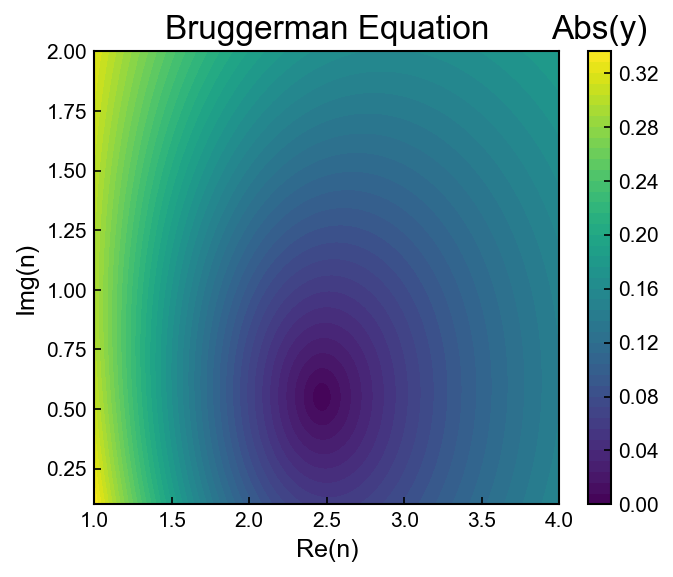

In [47]:
# Visualizing the bruggerman function
x = np.linspace(410, 800, 1000)
n_reff = np.linspace(1, 4, 1000)
k_reff = np.linspace(0.1, 2, 1000)
N_R, K_R = np.meshgrid(n_reff, k_reff)
y = bruggerman(N_R + 1j*K_R, 2+1j*0.5, 3+1j*0.6, 0.5)

plt.contourf(N_R, K_R, np.abs(y), levels=50)
plt.xlabel("Re(n)")
plt.ylabel("Img(n)")
plt.title("Bruggerman Equation")
cbar = plt.colorbar()
cbar.ax.set_title("Abs(y)")
plt.savefig("Bruggerman_2_i05_3_i06.svg")

To determine the zero in the bruggerman function considering a specific set of points (n1, n2 and p) I used the Newton method, as it seems to handle complex numbers quite well

In [50]:
# Determining the 0 from the bruggerman function
sco.newton(bruggerman, 2, args=(2+1j*0.5, 3+1j*0.6, 0.5))

(2.4668474177459636+0.5506381854264689j)

```python
# Function to determine the effective medium dispersion between 2 materials
def bruggerman_dispersion(n1, n2, p):
    """
    Calculate the effective medium dispersion between two materials 1 and 2
    Args:
        n1, n2 (complex arrays): refractive indices for each material
        p: fraction
    Returns:
        n_eff (complex array): effective medium
    """
    n_eff = np.ones_like(n1, dtype=np.complex128)
    for (index, n1_i), n2_i in zip(enumerate(n1), n2):
        n_eff[index] = sco.newton(bruggerman, (n1_i+n2_i)/2, args=(n1_i, n2_i, p))
    return n_eff
```

Visualizing the n transition between n1 and n2 as the % of one material increases.
Essentially the objective is to see the effective medium transition from one material to the other

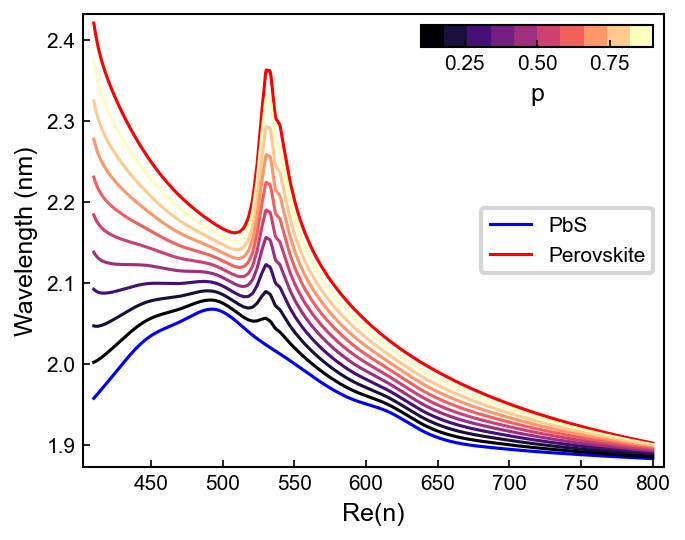

In [102]:
# Calculating the full dispersion
x = np.linspace(410, 800, 1000)
cmap = cm.get_cmap("magma", 10)
fig, ax = plt.subplots(1, 1)
ax1 = ax.plot(x, int_n_pbs(x),'b', label="PbS")
ax.plot(x, int_n_pvk(x), 'r', label="Perovskite")
for p_i in np.linspace(0.1, 0.9, 9):
    eff_med = bruggerman_dispersion(int_n_pbs(x), int_n_pvk(x)+1j*int_k_pvk(x), p_i)
    ax.plot(x, np.real(eff_med), label=f"", color=cmap(1-p_i))

axins = inset_axes(ax, width="40%", height="5%", loc='upper right')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.1, vmax=0.9))
cb = fig.colorbar(sm, cax=axins, orientation="horizontal")
cb.set_label("p")
ax.legend(loc='center right')
ax.set_xlabel("Re(n)")
ax.set_ylabel("Wavelength (nm)")
plt.savefig("Bruggerman_transition.svg")

### Complete absorption coefficient

Determine a complete examples for the QDs.
1. Determine the QD imaginary component
2. Calculate the combined refractive index

__Note__: May be interesting to create a function that does most of the work

__Note2__: Since for the energies of interest the perovskite refractive index is essentialy constant (n=2) for simplicity that value will be used as a constant in the calculation of the absorption coefficient of the material

__Note3__: The calculation of the exctinction cofficient requires the calculation of the absorption coefficient and not the absorption coefficient density. For that, a value of 1e19 cm-3 will be used to remove the density dependency for the remaining calculations

In [110]:
# Read the files with the material data
pbs = pd.read_csv("./band_model/materials/PbS_refractive_index.txt", sep=" ")
pvk = pd.read_csv("./band_model/materials/Perovskite_MAPbBr3_Brittman_PVL_0.4_1.1um.txt", sep=" ")
int_n_pbs = scin.interp1d(pbs.iloc[:, 0], pbs.iloc[:, 1], kind='cubic')
int_n_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 1], kind='cubic')
int_k_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 2], kind='cubic')

In [124]:
e = (scc.h*scc.c)/(pvk.iloc[:, 0]*1e-9*scc.e)
absorption = ab.interband_absorption(e, (3, 1.5, 0.08, 0.08), (3, 0.4, 0.08, 0.08), (15, 0.8, 2.3, (3.4e-25, 4.7e-25)), n_index=2)
wvl, abs_coeff = pvk.iloc[:, 0], absorption["Total"]*1e19*1e-21

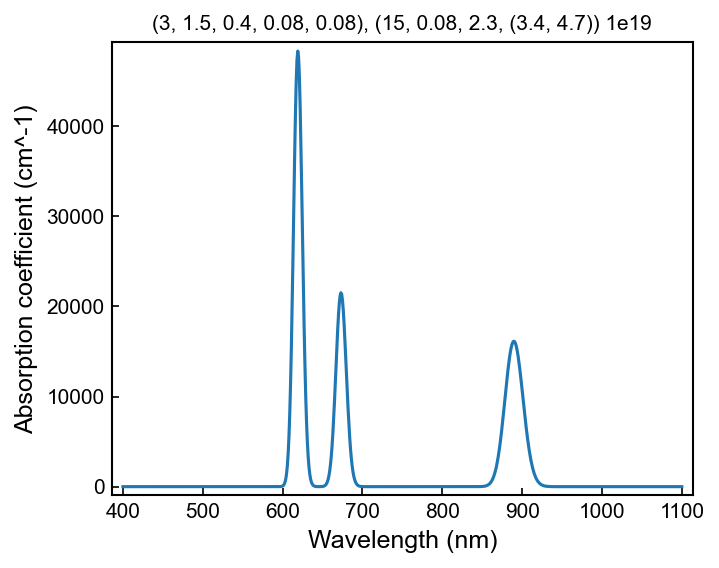

In [125]:
# Plot the absorption coefficient
plt.plot(wvl, abs_coeff)
plt.ylabel("Absorption coefficient (cm^-1)")
plt.xlabel("Wavelength (nm)")
plt.title("(3, 1.5, 0.4, 0.08, 0.08), (15, 0.08, 2.3, (3.4, 4.7)) 1e19", fontsize=10)
plt.savefig("abs_coef_1e19.svg")

In [138]:
pbs_n = int_n_pbs(wvl)
pbs_k = abs_coeff*(wvl*1e-7)/(4*np.pi)
pvk_n = int_n_pvk(wvl)
pvk_k = int_k_pvk(wvl)

In [141]:
mixed_disp = bruggerman_dispersion(pbs_n+1j*pbs_k, pvk_n+1j*pvk_k, 0.2)

Some notes for the results here.

As can be seen bellow in fact there are some peaks that apear in the absorption coefficient and that should lead to improved absorption performance in those areas. Nevertheless, due to the combination method it is important to undertand that for the perovskite absorption region, since the QDs do not absorb then there will also be a reduction oin the absorption coefficient for the overall system.

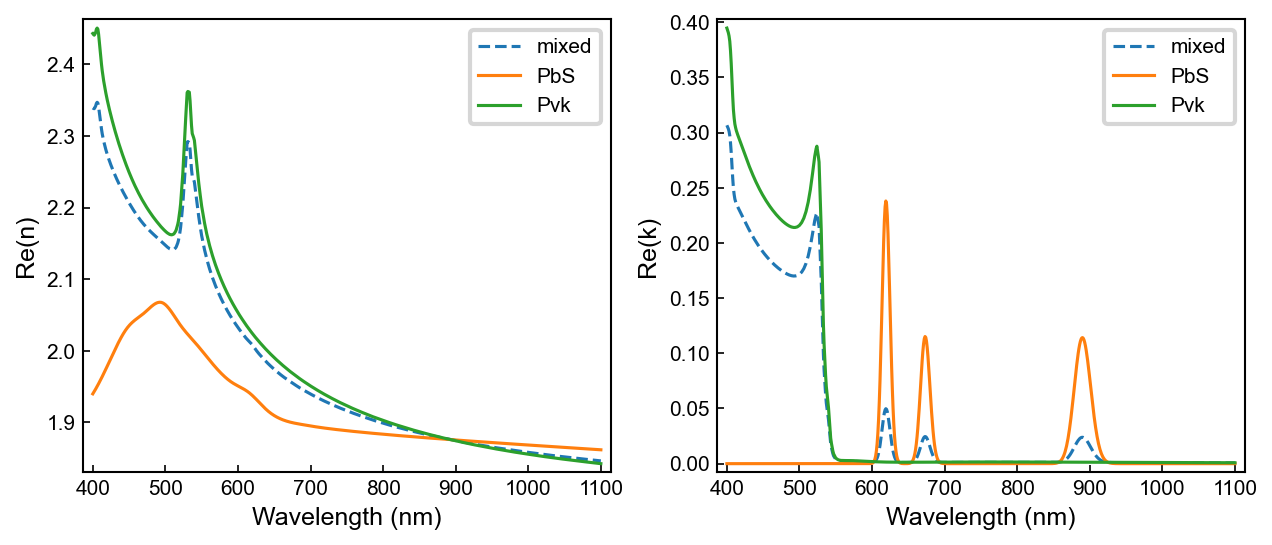

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(wvl, np.real(mixed_disp), '--', label="mixed")
ax[0].plot(wvl, pbs_n, label="PbS")
ax[0].plot(wvl, pvk_n, label="Pvk")
ax[0].set_xlabel("Wavelength (nm)")
ax[0].set_ylabel("Re(n)")
ax[0].legend()
ax[1].plot(wvl, np.imag(mixed_disp), '--', label="mixed")
ax[1].plot(wvl, pbs_k, label="PbS")
ax[1].plot(wvl, pvk_k, label="Pvk")
ax[1].set_xlabel("Wavelength (nm)")
ax[1].set_ylabel("Re(k)")
ax[1].legend()
plt.savefig("Final_abs_coeff.svg")

In [152]:
(1/(4*1.5**3))*1e21

7.407407407407407e+19

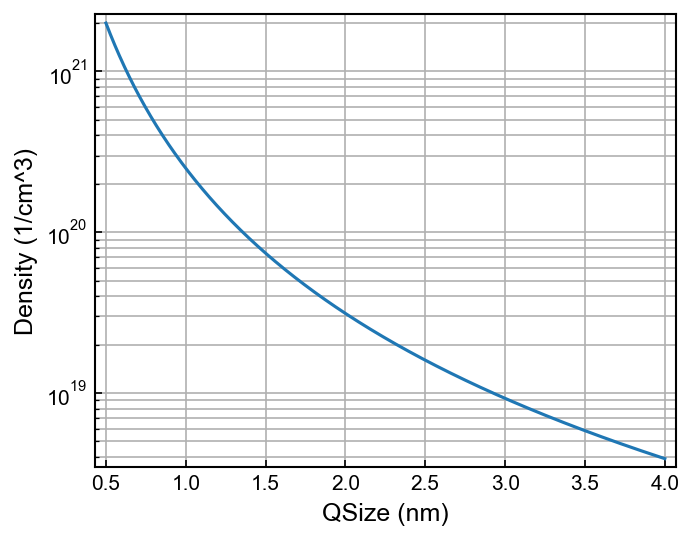

In [34]:
# Plot the close packing vs QD radius
r = np.linspace(0.5, 4, 1000)
plt.plot(r, 1e21/(4*r**3))
plt.yscale('log')
plt.grid(which="both")
plt.ylabel("Density (1/cm^3)")
plt.xlabel("QSize (nm)")
plt.savefig("Max_Density_size.svg")

### SMM absorption of QD@Host

In [3]:
from band_model.smm.s_matrix import Layer3D, smm_broadband

In [4]:
# Read the files with the material data
pbs = pd.read_csv("./band_model/materials/PbS_refractive_index.txt", sep=" ")
pvk = pd.read_csv("./band_model/materials/Perovskite_MAPbBr3_Brittman_PVL_0.4_1.1um.txt", sep=" ")
int_n_pbs = scin.interp1d(pbs.iloc[:, 0], pbs.iloc[:, 1], kind='cubic')
int_n_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 1], kind='cubic')
int_k_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 2], kind='cubic')

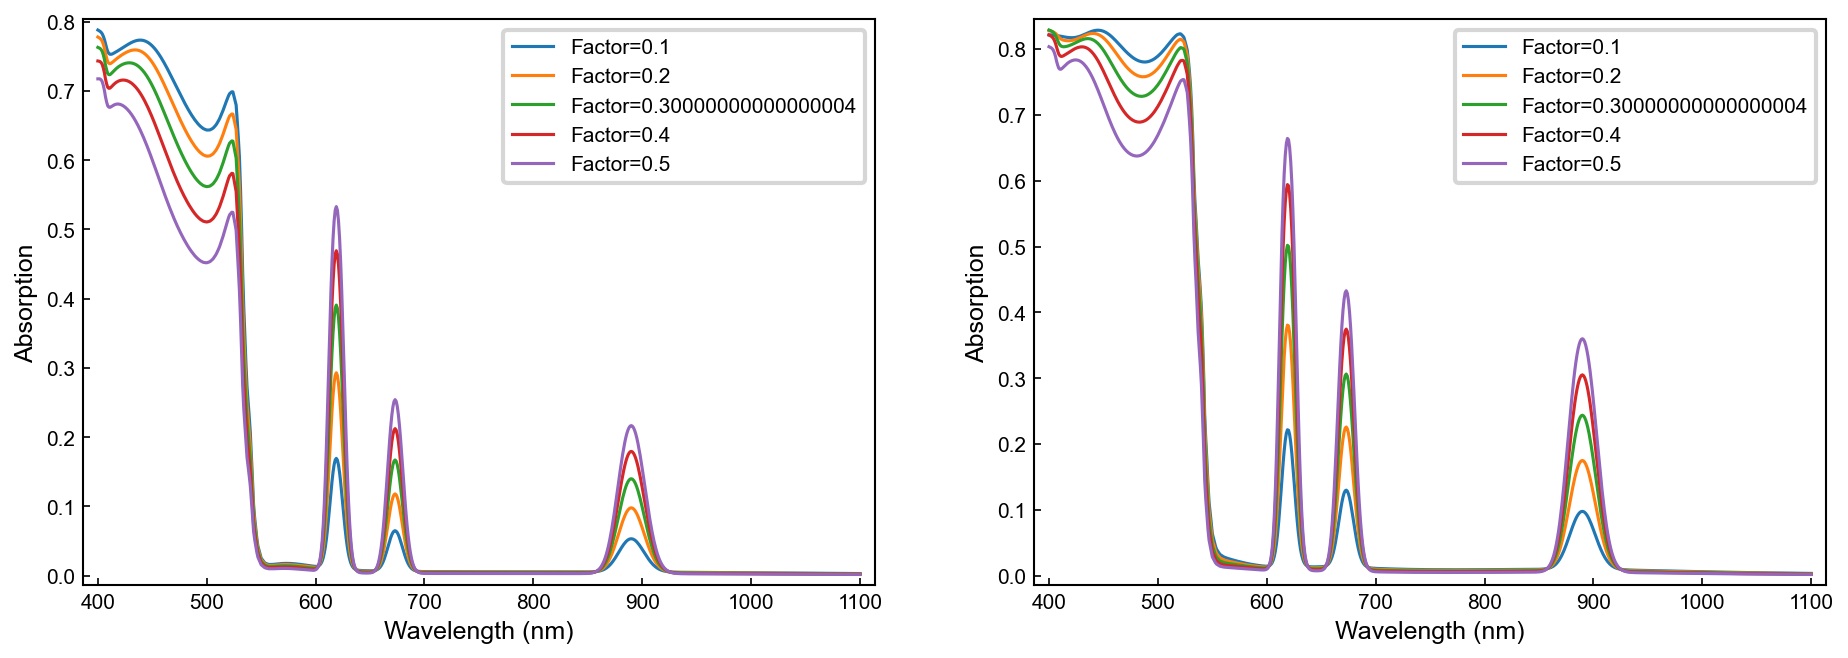

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for index, width in enumerate([300, 500]):
    e = (scc.h*scc.c)/(pvk.iloc[:, 0]*1e-9*scc.e)
    absorption = ab.interband_absorption(e, (3, 1.5, 0.08, 0.08), (3, 0.4, 0.08, 0.08), (15, 0.8, 2.3, (3.4e-25, 4.7e-25)), n_index=2)
    wvl, abs_coeff = pvk.iloc[:, 0], absorption["Total"]*1e19*1e-21
    res = pd.DataFrame()
    res["Wvl"] = wvl
    # Calculate the QD@Host properties for different factors
    for factor in np.linspace(0.1, 0.5, 5):
        mixed_disp = ab.bruggerman_dispersion(int_n_pbs(wvl)+1j*abs_coeff*(wvl*1e-7)/(4*np.pi), int_n_pvk(wvl)+1j*int_k_pvk(wvl), factor)
        pvk_mat = Layer3D("Pvk_comb", width, wvl, np.real(mixed_disp), np.imag(mixed_disp))
        R, T = smm_broadband([pvk_mat], 0, 0, wvl, (1, 0), (1, 1), (1, 1))
        res[f"R_{factor:.2f}"] = R
        res[f"T_{factor:.2f}"] = T
        ax[index].plot(wvl, 1-R-T, label=f"Factor={factor}")
    ax[index].set_ylabel("Absorption")
    ax[index].set_xlabel("Wavelength (nm)")
    ax[index].legend()
    res.to_csv(f"Pvk_{width}.csv", sep=" ", index=False)
    # plt.savefig("single_layer_qd@host_absorption.svg")

## Absorption for the optimized cases

2 different optimized cases where determined, for effective masses of 0.08 and 0.15

Constant values

|Pt[Kang]|Pl[Kang]|Eg-PbS|offset
|--|--|------|------|
|4.7e-25|3.4e-25|0.4|0.8

Changing values

Case 1:
* me = 0.08
* size = 2.87
* Eg = 2.53
* Vcb = 2.024
* Vvb = 0.506

Case 2:
* me = 0.15
* size = 2.44
* Eg= 2.29
* Vcb = 1.832
* Vvb = 0.452

In [5]:
from band_model.smm.s_matrix import Layer3D, smm_broadband
# Read the files with the material data
pbs = pd.read_csv("./band_model/materials/PbS_refractive_index.txt", sep=" ")
pvk = pd.read_csv("./band_model/materials/Perovskite_MAPbBr3_Brittman_PVL_0.4_1.1um.txt", sep=" ")
int_n_pbs = scin.interp1d(pbs.iloc[:, 0], pbs.iloc[:, 1], kind='cubic')
int_n_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 1], kind='cubic')
int_k_pvk = scin.interp1d(pvk.iloc[:, 0], pvk.iloc[:, 2], kind='cubic')

### Optimized Case 1

In [33]:
e = (scc.h*scc.c)/(pvk.iloc[:, 0]*1e-9*scc.e)
# TODO: Consider the perovskite index
qd_mass = 0.15
layer_size = 500
if qd_mass == 0.08:
    absorption = ab.interband_absorption(e, (2.87, 1.704, 0.08, 0.08), (2.87, 0.426, 0.08, 0.08), (25, 0.65, 2.53, (3.4e-25, 4.7e-25)), n_index=2.2)
elif qd_mass == 0.15:
    absorption = ab.interband_absorption(e, (2.44, 1.512, 0.15, 0.15), (2.44, 0.378, 0.15, 0.15), (25, 0.65, 2.29, (3.4e-25, 4.7e-25)), n_index=2.2)
else:
    raise ValueError("Wrong qd_mass value")

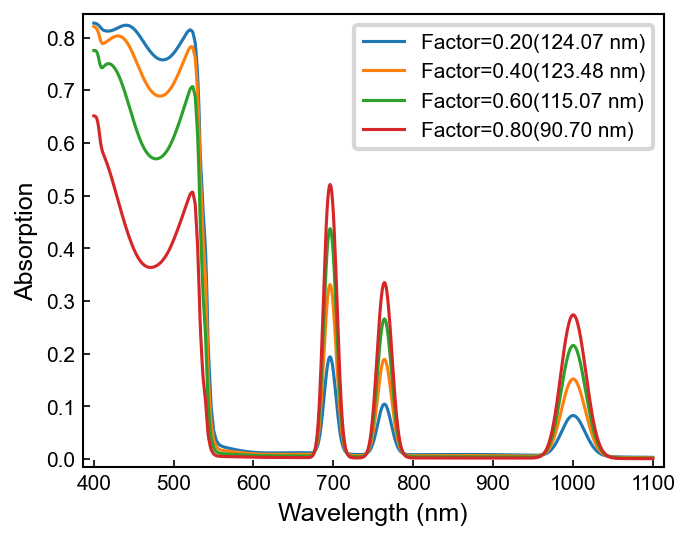

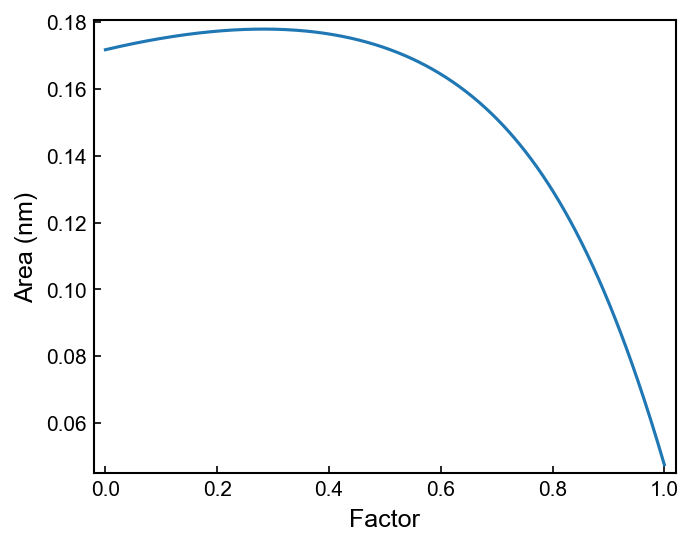

In [34]:
# Calculate the absorption
wvl, abs_coeff = pvk.iloc[:, 0], absorption["Total"]*1e19*1e-21
res = pd.DataFrame()
res["Wvl"] = wvl
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorption")
for factor in [0.2, 0.4, 0.6, 0.8]:
    mixed_disp = ab.bruggerman_dispersion(int_n_pbs(wvl)+1j*abs_coeff*(wvl*1e-7)/(4*np.pi), int_n_pvk(wvl)+1j*int_k_pvk(wvl), factor)
    pvk_mat = Layer3D("Pvk_comb", layer_size, wvl, np.real(mixed_disp), np.imag(mixed_disp))
    R, T = smm_broadband([pvk_mat], 0, 0, wvl, (1, 0), (1, 1), (1, 1))
    area = sci.trapz(1-R-T, wvl)
    res[f"R_{factor:.2f}"] = R
    res[f"T_{factor:.2f}"] = T
    plt.plot(wvl, 1-R-T, label=f"Factor={factor:.2f}({area:.2f} nm)")
plt.legend()
plt.savefig(f"Absorption_{qd_mass}.png")
res.to_csv(f"Absorption_{qd_mass}.csv", sep=" ", index=False)
plt.show()

area_df = pd.DataFrame(
    {
        "Factor": np.linspace(0, 1, 500),
        "Area": [0]*500
    }
)
for index, factor in enumerate(area_df.Factor):
    mixed_disp = ab.bruggerman_dispersion(int_n_pbs(wvl)+1j*abs_coeff*(wvl*1e-7)/(4*np.pi), int_n_pvk(wvl)+1j*int_k_pvk(wvl), factor)
    pvk_mat = Layer3D("Pvk_comb", layer_size, wvl, np.real(mixed_disp), np.imag(mixed_disp))
    R, T = smm_broadband([pvk_mat], 0, 0, wvl, (1, 0), (1, 1), (1, 1))
    area_df.loc[index, "Area"] = sci.trapz(1-R-T, wvl)/np.abs(wvl.values[0]-wvl.values[-1])

plt.xlabel("Factor")
plt.ylabel("Area (nm)")
plt.plot(area_df["Factor"], area_df["Area"])
plt.savefig(f"Area_vs_factor_{qd_mass}.png")
area_df.to_csv(f"Area_vs_factor_{qd_mass}.csv", sep=" ", index=False)

In [30]:
area_df.Area.max()

125.67914265994548

Obtain the band diagrams

In [5]:
# CB 0.08
ideal_ib = -0.9
qd = qbd.qd_results(2.87, 1.704, 0.08, 0.08, "CB1")
print(qd.e_levels)
levels_ib = np.abs((qd.e_levels.values - ideal_ib)/ideal_ib)
print(np.nanmin(levels_ib))
qd = qbd.qd_results(2.87, 0.426, 0.08, 0.08, "VB1")
print(qd.e_levels)

# CB 0.15
qd = qbd.qd_results(2.44, 1.512, 0.15, 0.15, "CB1")
print(qd.e_levels)
qd = qbd.qd_results(2.44, 0.378, 0.15, 0.15, "VB1")
print(qd.e_levels)

         l0        l1        l2
0 -1.302609 -0.894419 -0.398737
1 -0.214711       NaN       NaN
0.006201380973203108
         l0
0 -0.146693
         l0        l1        l2  l3
0 -1.206615 -0.893899 -0.509613 NaN
1 -0.351519       NaN       NaN NaN
         l0
0 -0.157623
